In [1]:
source('./data_processing.R')

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, saveRDS


Loading Seurat v5 beta version 
To maintain compatibility with previous workflows, new Seurat objects will use the previous object structure by default
To use new Seurat v5 assays: Please run: options(Seurat.object.assay.version = 'v5')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Belk CancerCell

## Sample 1

### remove TSO

[1] "MT mutation table"

   A    C D(1) D(2) D(3) D(8)    G I(1)    T 
  41    9   18    2    2    1   38    7   29 
[1] "MT mutation type"

  D   I   S 
 23   7 117 
[1] "MT mutation structure"

gRNA Rest  TSO 
  87   16   44 


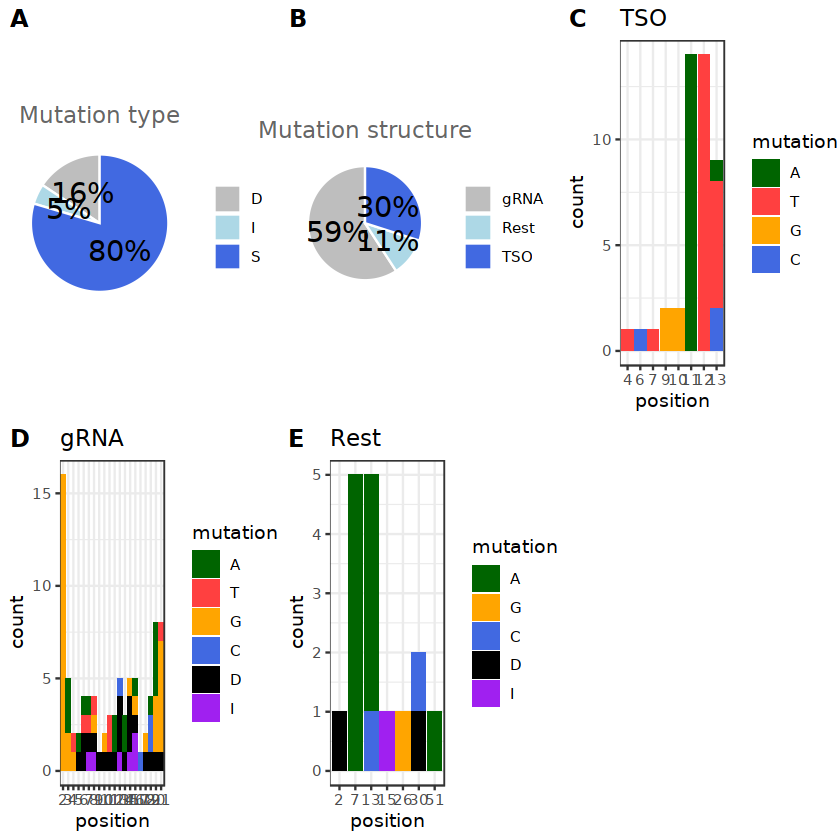

In [2]:
output_dir = './tmp/test'
input_dir = '../Belk_CancerCell/more_barcodes/'
fba_input_dir = '/lustre1/project/stg_00064/projects/cropseq/267genes/develop/public_data/Belk_CancerCell/feature_barcoding/V35_M2B'

MT <- plot_MT_pattern(input_dir, output_dir)
MT2 <- MT
MT2[which(MT2$structure == 'TSO'), 'position'] <- MT2[which(MT2$structure == 'TSO'), 'position']-14
MT2[which(MT2$structure == 'gRNA'), 'position'] <- MT2[which(MT2$structure == 'gRNA'), 'position'] - 1
MT2[which(MT2$structure == 'Rest'),'position'] <- MT2[which(MT2$structure == 'Rest'),'position']+20
MT2 <- MT2[-which(MT2$position < 2),]

######### Needs to be put before factor(MT2$position) otherwise will change the dedup
MT2$dedup <- paste0(MT2$`gene name`, MT2$structure, MT2$`structure length`, MT2$position, MT2$mutation)
tmp <- MT2 %>% group_by(`variant number`) %>% summarise(mutations = list(dedup))
MT2_nodedup <- MT2
MT2 <- MT2[which(!MT2$`variant number` %in% tmp$`variant number`[duplicated(tmp$mutations)]),]
rm(tmp)
#########

MT2$position <- factor(MT2$position, levels = seq(-20,55, by =1))
MT2$mutation2 <- factor(MT2$mutation2, levels = c('A','T','G','C','D','I'))


In [3]:
#dim(MT2) # presumed real mutant sgRNAs after removal of TSO artifacts without dedup
MT2_list_nodedup <- unique(MT2_nodedup$`variant number`)
length(MT2_list_nodedup)

[1] 64

In [4]:
cells_gRNA_file <- paste0(input_dir, '/cells.gRNA.txt')
n_col = max(count.fields(cells_gRNA_file, sep = "\t"))
cells.gRNA <- read.table(cells_gRNA_file, 
                     header = FALSE, fill = TRUE, stringsAsFactors = FALSE,col.names =1:n_col)

colnames(cells.gRNA)[1:7]= c('cb','feature_order','target','WT','num_UMI_WT', 'MT','num_UMI_MT')
cells.gRNA$cb <- paste0(cells.gRNA$cb,'-1')
cells.gRNA.ori <- cells.gRNA

In [5]:
cells.gRNA <- cells.gRNA.ori
cells.gRNA.WTcounts <- cells.gRNA[,1:5]
for(i in seq(6,n_col-2,2)){
    MT.df <- cells.gRNA[,i:(i+1)]
    colnames(MT.df) <- c('MT','num_UMI_MT')
    MT.notInlist <- MT.df[!MT.df$MT %in% MT2_list_nodedup,]
    index <- !MT.df$MT %in% MT2_list_nodedup
    MT.notInlist$num_UMI_MT[is.na(MT.notInlist$num_UMI_MT)] <- 0
    cells.gRNA.WTcounts$num_UMI_WT[index] <- cells.gRNA.WTcounts$num_UMI_WT[index] + MT.notInlist$num_UMI_MT
    cells.gRNA[index,i:(i+1)] <- NA # make MT not in list as NA
}
cells.gRNA[,1:5] <- cells.gRNA.WTcounts
for(i in seq(1, nrow(cells.gRNA))){
    num_MT <- (sum(!is.na(cells.gRNA[i,])) - 5)/2 #updated number of gRNA
    if(cells.gRNA[i,5] > 0){
        cells.gRNA$feature_order[i] <- num_MT + 1
    }else{
        cells.gRNA$feature_order[i] <- num_MT
    }
}
# now feature order is no longer accumulated 
cells.num_features <- cells.gRNA %>% group_by(cb) %>% summarise(num_features = sum(feature_order))
#cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(is_MT))
cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(contain_MT, is_MT))

# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


In [6]:
table(cells.num_features$num_features)
sum(table(cells.num_features$num_features))


   1    2    3    4    5    6    7    8 
2826  690  216   61   23   10    5    4 

[1] 3835

In [7]:
sum(cells.num_features$num_features) # cells (actual cells, count multiplets multiple times)
tmp <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0))
# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA
sum(cells.gRNA[which(cells.gRNA$num_UMI_WT > 0),'feature_order']-1) + sum(cells.gRNA[which(cells.gRNA$num_UMI_WT == 0),'feature_order'])
# cells with mutations (multiplets count as multiple)

[1] 5340

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


[1] 130

Rows: 6260 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


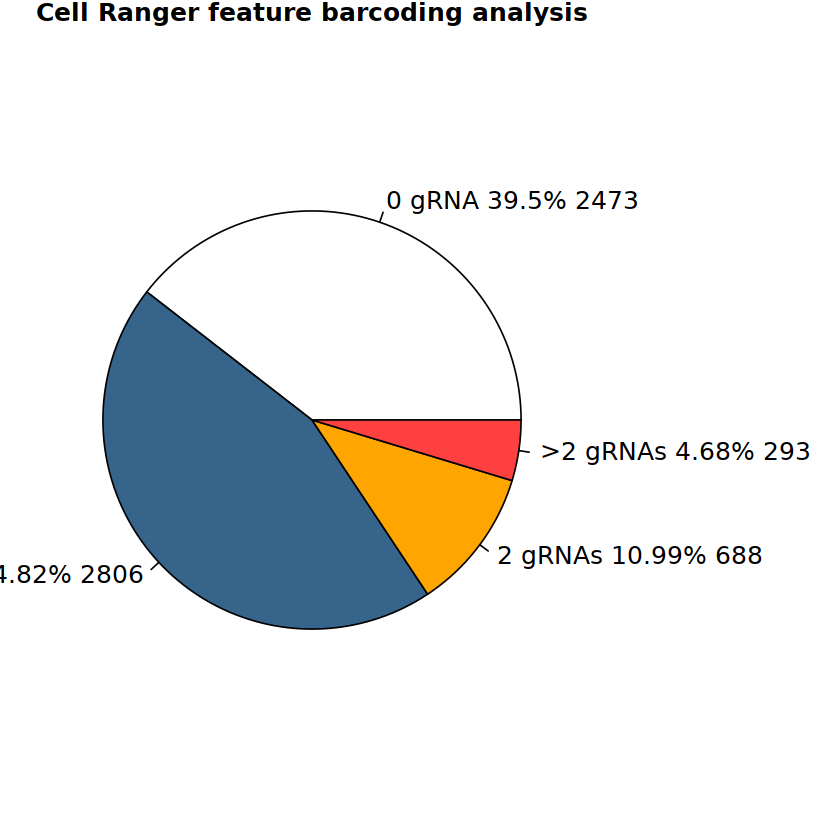

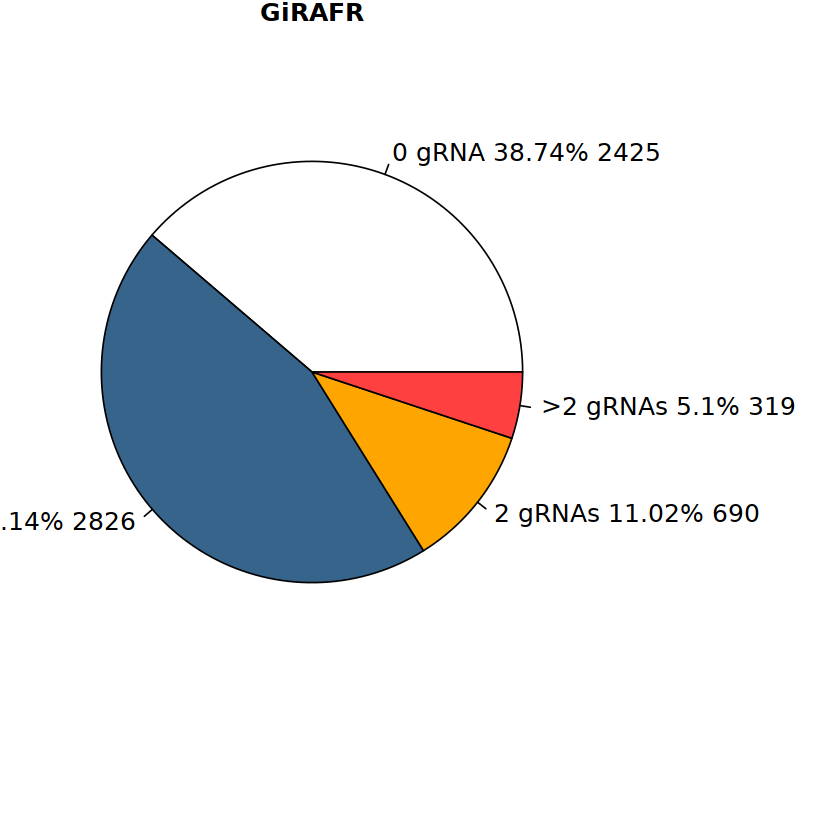

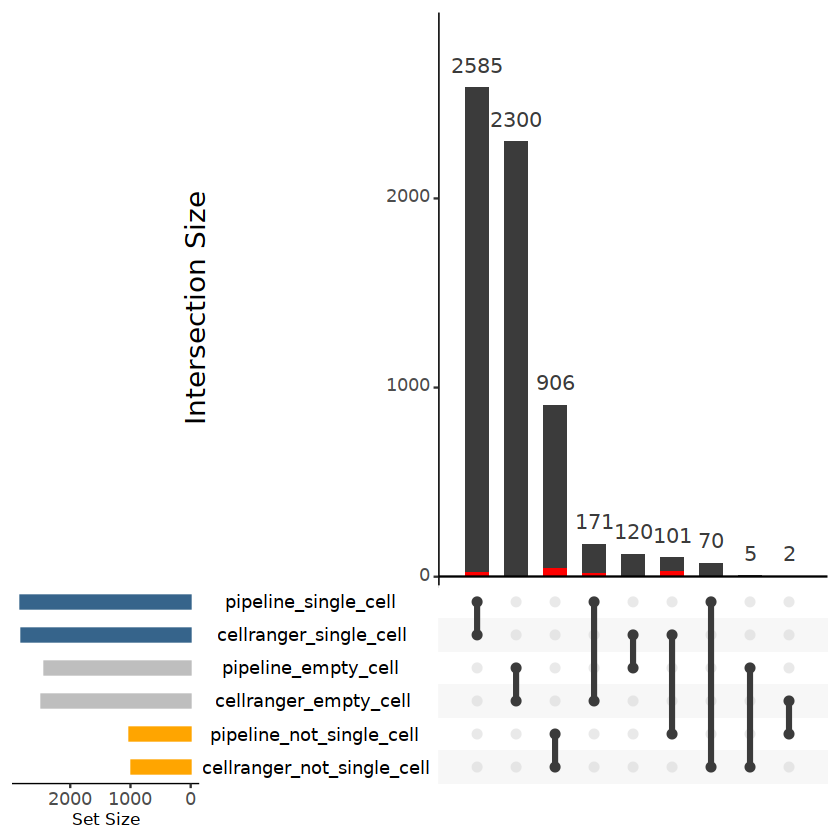

In [8]:
protospacer_file <- paste0(fba_input_dir, '/outs/crispr_analysis/protospacer_calls_per_cell.csv')
barcodes_file <- paste0(fba_input_dir, '/outs/filtered_feature_bc_matrix/barcodes.tsv.gz')
protospacer_calls_per_cell <-read.csv(protospacer_file, stringsAsFactors = FALSE)
cellranger_barcode <- read_csv(barcodes_file, col_names = FALSE)


pipeline_NotEmpty <- cells.num_features$cb
pipeline_Single <- cells.num_features$cb[which(cells.num_features$num_features == 1)]
par(mar = c(1,1,1,10))
slices1 <- c(nrow(cellranger_barcode) - sum(table(protospacer_calls_per_cell$num_features)),
        as.vector(table(protospacer_calls_per_cell$num_features)[1]),
        as.vector(table(protospacer_calls_per_cell$num_features)[2]),
        sum(table(protospacer_calls_per_cell$num_features)[-(1:2)]))
lbls1 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct1 <- round(slices1/sum(slices1)*100, digit =2 )
lbls1 <- paste(lbls1, pct1) # add percents to labels
lbls1 <- paste(lbls1,"%",sep="") # ad % to labels
lbls1 <- paste(lbls1, slices1, sep =' ')
pie(slices1, labels = lbls1, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"), 
    main = 'Cell Ranger feature barcoding analysis')

par(mar = c(5,1,1,10))
slices2 <- c(nrow(cellranger_barcode) - sum(table(cells.num_features$num_features)),
        as.vector(table(cells.num_features$num_features)[1]),
        as.vector(table(cells.num_features$num_features)[2]),
        sum(table(cells.num_features$num_features)[-(1:2)]))
lbls2 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct2 <- round(slices2/sum(slices2)*100, digit = 2)
lbls2 <- paste(lbls2, pct2) # add percents to labels
lbls2 <- paste(lbls2,"%",sep="") # ad % to labels
lbls2 <- paste(lbls2, slices2, sep =' ')
pie(slices2, labels = lbls2, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"),
   main = 'GiRAFR')

all_barcodes <- as.data.frame(cellranger_barcode)
all_barcodes$pipeline_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 1, 0)
all_barcodes$pipeline_empty_cell <- ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 0, 1)
all_barcodes$pipeline_not_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 0, 
                                            ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 1, 0))

all_barcodes$cellranger_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 1, 0)
all_barcodes$cellranger_empty_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 0, 1)
all_barcodes$cellranger_not_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 0, 
                                            ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 1, 0))
all_barcodes <- merge(all_barcodes, cells.has_MT, by.x = 'X1', by.y = 'cb', all.x = TRUE)



Myfunc <- function(row) {data <- (row["has_MT"] == TRUE)}
p <- upset(data = all_barcodes, 
      queries = list(list(query = Myfunc, color = "red", active = T)),
      sets = c('cellranger_not_single_cell','pipeline_not_single_cell',
           'cellranger_empty_cell','pipeline_empty_cell',
           'cellranger_single_cell','pipeline_single_cell'), order.by = "freq",keep.order = TRUE,sets.bar.color=c("orange","orange","grey","grey","steelblue4","steelblue4"), 
      point.size =2.5,line.size = 1.3,text.scale = c(2, 1.5, 1.2, 1.5, 1.5, 2))

p


In [9]:
table(all_barcodes[which(all_barcodes$cellranger_empty_cell == 1),'has_MT'])


FALSE  TRUE 
  152    21 

In [10]:
table(all_barcodes$has_MT)


FALSE  TRUE 
 3716   119 

### Analysis impact of mutant gRNA and doublets

In [11]:
input_dir

[1] "../Belk_CancerCell/more_barcodes/"

In [12]:
cells.gRNA.single.MT <- read.table(paste0(input_dir, 'cells.gRNA.single.MT.txt'), stringsAsFactors = FALSE)
cells.gRNA.single.MT$target <- sapply(strsplit(cells.gRNA.single.MT$V3,"_"), `[`, 1)
cells.gRNA.single.MT[grepl('CTRL1',cells.gRNA.single.MT$target),]$target <- 'Control'
cells.gRNA.single.MT$is_WT <- !grepl(pattern = 'variant',cells.gRNA.single.MT$V3)
#table(cells.gRNA.single.MT$is_WT)
cells.gRNA.single.MT$cb = paste0(cells.gRNA.single.MT$V1, '-1')

In [13]:
diff_cb <- pipeline_Single[!pipeline_Single %in% cells.gRNA.single.MT$cb]

pipeline_Single

In [14]:
all.matrix <- Read10X(paste0(fba_input_dir,'/outs/filtered_feature_bc_matrix/'))
expression.seurat.ori = CreateSeuratObject(counts = all.matrix$`Gene Expression`)
expression.seurat <- subset(expression.seurat.ori, cells = pipeline_Single)

expression.seurat <- NormalizeData(object = expression.seurat, normalization.method = "LogNormalize", scale.factor = 10000)
rownames(cells.gRNA.single.MT) <- cells.gRNA.single.MT$cb
expression.seurat@meta.data$KO <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'target']
expression.seurat@meta.data$is_WT <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'is_WT']
expression.seurat@meta.data$mutation <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'V5']
expression.seurat@meta.data$cb <- rownames(expression.seurat@meta.data)

10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


New single cells after removal of TSO shown as NA

In [15]:
sum(is.na(expression.seurat@meta.data$KO)) 
# should be same as length(diff_cb) 

[1] 29

In [16]:
rownames(cells.has_MT) <- cells.has_MT$cb
expression.seurat@meta.data$has_MT <- cells.has_MT[rownames(expression.seurat@meta.data), ]$has_MT

Warning message:
“Setting row names on a tibble is deprecated.”


In [17]:
diff_cb_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% diff_cb),]
rownames(diff_cb_gRNA) <- diff_cb_gRNA$cb

In [18]:
# replace KO NA into target
expression.seurat@meta.data$KO[which(expression.seurat@meta.data$cb %in% diff_cb)] <- 
sapply(strsplit(diff_cb_gRNA[rownames(expression.seurat@meta.data[which(expression.seurat@meta.data$cb %in% diff_cb),]), 'target'], '_'), `[`, 1)

In [19]:
table(expression.seurat@meta.data$is_WT, expression.seurat@meta.data$has_MT)
# has some discrepancy 

       
        FALSE TRUE
  FALSE     3   41
  TRUE   2753    0

In [20]:
#expression.seurat@meta.data[which(expression.seurat@meta.data$is_WT == FALSE & expression.seurat@meta.data$has_MT == FALSE),]

In [21]:
expression.seurat$KO[expression.seurat$KO == 'CTRL1'] <- 'Control'
expression.seurat$KO[expression.seurat$KO == 'ARID1A'] <- 'Arid1a'
expression.seurat$KO[expression.seurat$KO == 'SMARCC1'] <- 'Smarcc1'
expression.seurat$KO[expression.seurat$KO == 'ACTR5'] <- 'Actr5'
expression.seurat$KO[expression.seurat$KO == 'ARID1B'] <- 'Arid1b'
expression.seurat$KO[expression.seurat$KO == 'INO80C'] <- 'Ino80c'
expression.seurat$KO[expression.seurat$KO == 'ARID2'] <- 'Arid2'
expression.seurat$KO[expression.seurat$KO == 'GATA3'] <- 'Gata3'
expression.seurat$KO[expression.seurat$KO == 'PDCD1'] <- 'Pdcd1'
expression.seurat$KO[expression.seurat$KO == 'SMARCD2'] <- 'Smarcd2'

In [22]:
unique(expression.seurat$KO)

[1] "Arid1a"  "Smarcc1" "Actr5"   "Control" "Arid1b"  "Ino80c"  "Arid2"  
 [8] "Gata3"   "Pdcd1"   "Smarcd2"

In [23]:
targets <- unique(expression.seurat@meta.data$KO)
targets <- targets[targets!='Control']
all.exp2.df <- data.frame()
CTRL_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == 'Control'),])
for(gene in targets){
        KO_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == gene),])
        tmp.df <- rbind(data.frame(expression = expression.seurat@assays$RNA@data[gene, KO_cells], type = 'KO'),
            data.frame(expression = expression.seurat@assays$RNA@data[gene, CTRL_cells], type = 'Control'))

        tmp.df$target = gene
        tmp.df$cb = rownames(tmp.df)
        all.exp2.df <- rbind(all.exp2.df, tmp.df)
}

Target gene expression in Control

In [24]:
avg.exp.control <- all.exp2.df[which(all.exp2.df$type == 'Control'),] %>% group_by(target) %>% summarise(avg = mean(expression))
avg.exp.control <- as.data.frame(avg.exp.control)
rownames(avg.exp.control) <- avg.exp.control$target

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


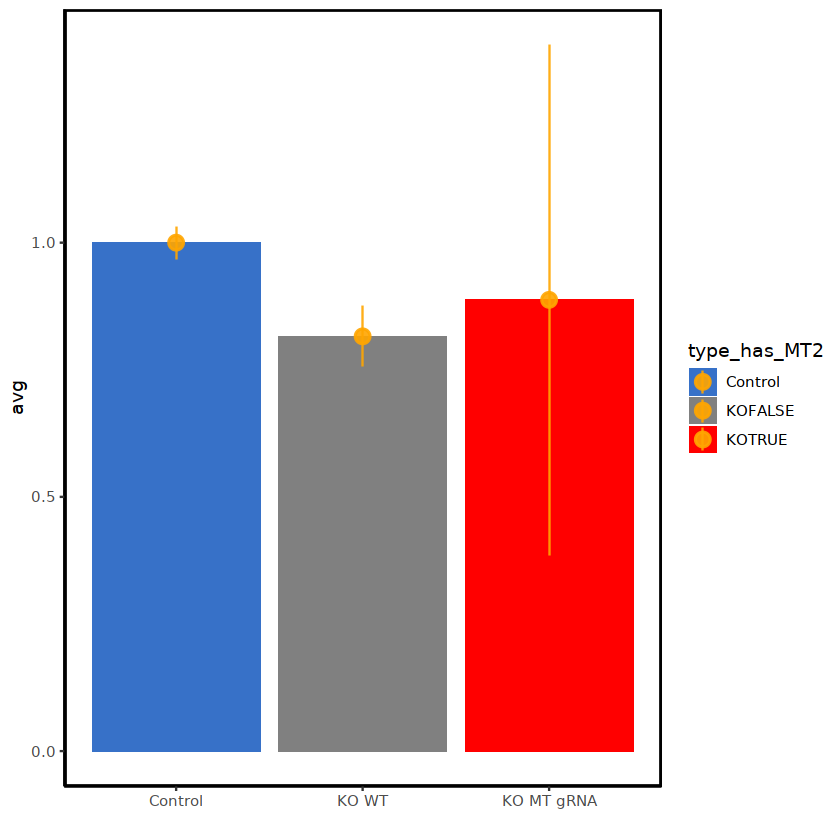

In [25]:
#all.exp2.MT.df <- merge(all.exp2.df, cells.gRNA.single.MT[,c(4,5,8,9)], by = 'cb')
all.exp2.MT.df <- merge(all.exp2.df, expression.seurat@meta.data[,c(4,6,7,8)], by = 'cb')
all.exp2.MT.df$type_has_MT <- paste0(all.exp2.MT.df$type, all.exp2.MT.df$has_MT)

all.exp2.MT.df$type_has_MT2 <- all.exp2.MT.df$type_has_MT
all.exp2.MT.df[which(all.exp2.MT.df$type_has_MT == 'ControlFALSE' |
    all.exp2.MT.df$type_has_MT == 'ControlNA' |
    all.exp2.MT.df$type_has_MT == 'ControlTRUE'),'type_has_MT2'] <- 'Control'


all.exp2.MT.df$expression_norm <- all.exp2.MT.df$expression/avg.exp.control[all.exp2.MT.df$target,'avg']

# high_exp_targets <- avg.exp.control$target[order(avg.exp.control$avg, decreasing = T)]
# tmp.df <- all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets), c('tmp','expression_norm')]

tmp.df <- all.exp2.MT.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm),
                                                 sem = sd(expression_norm)/sqrt(n))

p1 <- ggplot(tmp.df, aes(x = type_has_MT2, y = avg, fill = type_has_MT2)) + geom_col()+
        geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
        theme_classic()+
        xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
        scale_fill_manual(breaks = c("Control", "KOFALSE","KOTRUE"),
                          values=c("#3771c8", "#808080",'#ff0000'))+
        scale_x_discrete(limits = c("Control", "KOFALSE", "KOTRUE"), labels=c("Control" = "Control", "KOFALSE" = "KO WT", "KOTRUE" = "KO MT gRNA"))

print(p1)

### Analysis impact of doublets/multiplets

In [26]:
new_doublets <- all_barcodes[which(all_barcodes$pipeline_not_single_cell == 1 & all_barcodes$cellranger_single_cell == 1), 'X1']
length(new_doublets) 
# pipeline identified doubets, cellranger as single

[1] 101

For new doublets, following scenarios:
1. doublets with the mutant gRNA and wildtype gRNA targeting the same gene, 
2. doublets with the mutant gRNA and wildtype gRNA targeting the different gene
3. doublets with two wildtype gRNA targeting the same gene
4. doublets with two wildtype gRNA targeting different gene
5. doublets with two mutant gRNAs targeting different gene

In [27]:
new_doublets_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% new_doublets),] # the mutant gRNA and wildtype gRNA targeting the same gene,

In [28]:
new_doublets_type1 <- new_doublets_gRNA[which(new_doublets_gRNA$feature_order >= 2),]

In [29]:
new_doublets_gRNA2 <- as.data.frame(new_doublets_gRNA[which(new_doublets_gRNA$feature_order < 2),] %>% group_by(cb) %>% summarise(target = list(target), UMIs = list(num_UMI_WT)))


In [30]:
new_doublets_gRNA2$KO <- lapply(new_doublets_gRNA2$target, function(x) sapply(strsplit(x, '_'), `[`, 1))

In [31]:
if1 <- lapply(new_doublets_gRNA2$KO, function(x) x[1]== x[2])
if2 <- lapply(new_doublets_gRNA2$UMIs, function(x) x[1]>0 & x[2] > 0)
              
new_doublets_type_unknown <- c()
new_doublets_type2 <- c()
new_doublets_type3 <- c()
new_doublets_type4 <- c()
new_doublets_type5 <- c()
for(i in 1:nrow(new_doublets_gRNA2)){
    if(is.na(if1[i]) | is.na(if2[i])){
        new_doublets_type_unknown <- rbind(new_doublets_type_unknown, new_doublets_gRNA2[i,])
    }else{
    if(if1[i] == TRUE & if2[i] == TRUE){ # two wiltype gRNA targeting the same target
        new_doublets_type3 <- rbind(new_doublets_type3, new_doublets_gRNA2[i,])
    }else if(if1[i] == TRUE & if2[i] == FALSE){ #  mutant gRNA and wildtype gRNA or two muatnt targeting the same gene
        new_doublets_type2 <- rbind(new_doublets_type2, new_doublets_gRNA2[i,])
    }else if(if1[i] == FALSE & if2[i] == TRUE){# two wildtype gRNA targeting different gene
        new_doublets_type4 <- rbind(new_doublets_type4, new_doublets_gRNA2[i,]) 
    }else if(if1[i] == FALSE & if2[i] == FALSE){ # mutant gRNA and wildtype gRNA or two muatnt  different gene 
        new_doublets_type5 <- rbind(new_doublets_type5, new_doublets_gRNA2[i,])
    }else{
        print('unknown error')
    }
    }
}

In [32]:
nrow(new_doublets_type1)
nrow(new_doublets_type2)
nrow(new_doublets_type3)
nrow(new_doublets_type4)
nrow(new_doublets_type5)
nrow(new_doublets_type_unknown)

[1] 10

[1] 1

[1] 10

[1] 61

[1] 19

[1] 1

In [33]:
new_doublets_subset <- rbind(new_doublets_type4, new_doublets_type5)$cb
length(new_doublets_subset)

[1] 80

In [34]:
seurat.object.doublets <- subset(expression.seurat.ori, cells = new_doublets_subset)
seurat.object.doublets <- NormalizeData(object = seurat.object.doublets, normalization.method = "LogNormalize", scale.factor = 10000)
seurat.object.doublets

An object of class Seurat 
32333 features across 80 samples within 1 assay 
Active assay: RNA (32333 features, 0 variable features)
 2 layers present: counts, data

In [35]:
head(rbind(new_doublets_type4, new_doublets_type5))

table(cells.num_features[which(cells.num_features$cb %in% new_doublets_subset),'num_features'])


,cb,target,UMIs,KO
,<chr>,<list>,<list>,<list>
3,AACTTTCCATGCCTTC-1,"ARID1A_gRNA3_gene, CTRL1_gRNA12_gene","31, 1","ARID1A, CTRL1"
4,AATCCAGAGAAGATTC-1,"ACTR5_gRNA1_gene , CTRL1_gRNA12_gene","15, 1","ACTR5, CTRL1"
5,AATCCAGGTTGGAGGT-1,"SMARCC1_gRNA3_gene, CTRL1_gRNA12_gene","13, 1","SMARCC1, CTRL1"
6,AATCGGTAGAACTCGG-1,"ARID1A_gRNA1_gene , SMARCC1_gRNA4_gene","10, 145","ARID1A , SMARCC1"
7,ACGATACGTGACGCCT-1,"INO80C_gRNA1_gene, PDCD1_gRNA2_gene","3, 13","INO80C, PDCD1"
9,ACTGCTCCAGATAATG-1,"ARID1A_gRNA1_gene , SMARCC1_gRNA4_gene","8, 26","ARID1A , SMARCC1"


num_features
 2  3 
77  3 

In [36]:
protospacer.df <- read.csv(protospacer_file)
rownames(protospacer.df) <- protospacer.df$cell_barcode

In [37]:
seurat.object.doublets@meta.data <- cbind(seurat.object.doublets@meta.data, protospacer.df[colnames(seurat.object.doublets),])
seurat.object.doublets$KO <- sapply(strsplit(seurat.object.doublets@meta.data$feature_call, '_'), `[`, 1)

In [38]:
seurat.object.doublets$KO[seurat.object.doublets$KO == 'CTRL1'] <- 'Control'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'ARID1A'] <- 'Arid1a'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'SMARCC1'] <- 'Smarcc1'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'ACTR5'] <- 'Actr5'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'ARID1B'] <- 'Arid1b'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'INO80C'] <- 'Ino80c'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'ARID2'] <- 'Arid2'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'GATA3'] <- 'Gata3'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'PDCD1'] <- 'Pdcd1'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'SMARCD2'] <- 'Smarcd2'

In [39]:
doublets_targets <- unique(seurat.object.doublets$KO)[-which(unique(seurat.object.doublets$KO) == 'Control')] # remove 'neg'
doublets.exp.df <- data.frame()
CTRL_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == 'Control'),])

for(gene in doublets_targets){
    KO_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == gene),])
   tmp.df <- rbind(data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, KO_cells], type = 'KO_doublets'),
                    data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, CTRL_cells], type = 'Control_doublets'))
   tmp.df$target = gene
   tmp.df$cb = c(KO_cells, CTRL_cells)
   doublets.exp.df <- rbind(doublets.exp.df, tmp.df)
}

In [40]:
doublets.exp.df$type_has_MT2 <- doublets.exp.df$type

In [41]:
doublets.exp.df$expression_norm <- doublets.exp.df$expression/avg.exp.control[doublets.exp.df$target,'avg']

In [42]:
all.exp2.doublets.df <- rbind(doublets.exp.df, all.exp2.MT.df[, c('expression', 'type', 'target', 'cb', 'type_has_MT2', 'expression_norm')])

In [43]:
table(all.exp2.doublets.df$type_has_MT)


         Control Control_doublets      KO_doublets          KOFALSE 
            8127              144               62             1902 
          KOTRUE 
              21 

In [44]:
tmp.df <- all.exp2.doublets.df
tmp.df <- tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
tmp.df

type_has_MT2,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,8127,1.0000000,2.923751,0.03243211
Control_doublets,144,0.8563712,2.247151,0.18726254
KOFALSE,1902,0.8157068,2.624033,0.06016778
KOTRUE,21,0.8874683,2.302066,0.50235190
KO_doublets,62,0.4246230,1.705223,0.21656350


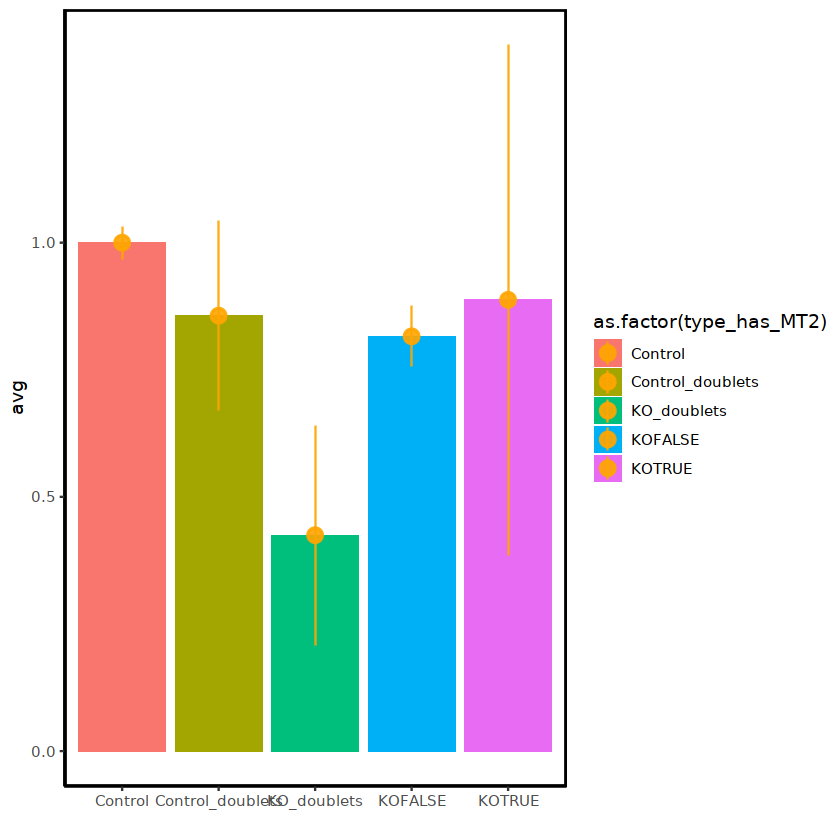

In [45]:
ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = avg, fill = as.factor(type_has_MT2))) + 
geom_col()+
#geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), width=.2,position=position_dodge(.9)) +
#geom_pointrange(aes(x=nr_mutation, y=avg, ymin=avg-sd, ymax=avg+sd), colour="orange", alpha=0.9, size=1.3)+
geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))


In [46]:
dim(all.exp2.doublets.df)
all.exp2.doublets.df_sample1 <- all.exp2.doublets.df

[1] 10256     6

## V41_M2R

### remove TSO

[1] "MT mutation table"

   A    C D(1) D(3)    G I(1)    T 
  80   34   34    3   72    5   96 
[1] "MT mutation type"

  D   I   S 
 37   5 282 
[1] "MT mutation structure"

gRNA Rest  TSO 
 163   15  146 


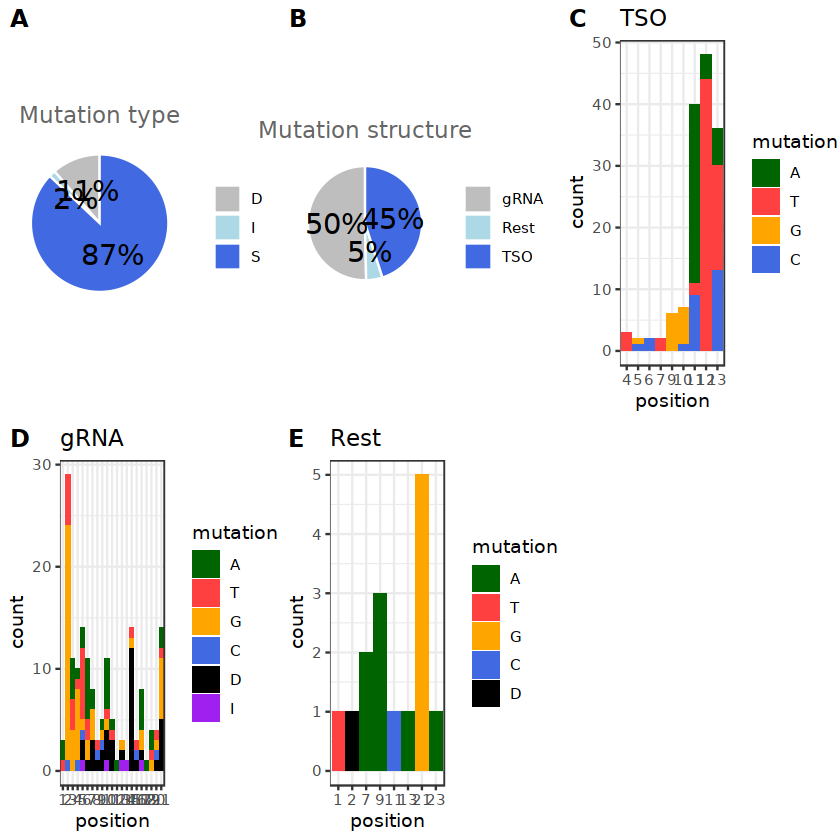

In [47]:
output_dir = './tmp/test'
input_dir = '../Belk_CancerCell/V41_M2R/'
fba_input_dir = '/lustre1/project/stg_00064/projects/cropseq/267genes/develop/public_data/Belk_CancerCell/feature_barcoding/V41_M2R/'

MT <- plot_MT_pattern(input_dir, output_dir)
MT2 <- MT
MT2[which(MT2$structure == 'TSO'), 'position'] <- MT2[which(MT2$structure == 'TSO'), 'position']-14
MT2[which(MT2$structure == 'gRNA'), 'position'] <- MT2[which(MT2$structure == 'gRNA'), 'position'] - 1
MT2[which(MT2$structure == 'Rest'),'position'] <- MT2[which(MT2$structure == 'Rest'),'position']+20
MT2 <- MT2[-which(MT2$position < 2),]

######### Needs to be put before factor(MT2$position) otherwise will change the dedup
MT2$dedup <- paste0(MT2$`gene name`, MT2$structure, MT2$`structure length`, MT2$position, MT2$mutation)
tmp <- MT2 %>% group_by(`variant number`) %>% summarise(mutations = list(dedup))
MT2_nodedup <- MT2
MT2 <- MT2[which(!MT2$`variant number` %in% tmp$`variant number`[duplicated(tmp$mutations)]),]
rm(tmp)
#########

MT2$position <- factor(MT2$position, levels = seq(-20,55, by =1))
MT2$mutation2 <- factor(MT2$mutation2, levels = c('A','T','G','C','D','I'))


In [48]:
#dim(MT2) # presumed real mutant sgRNAs after removal of TSO artifacts without dedup
MT2_list_nodedup <- unique(MT2_nodedup$`variant number`)
length(MT2_list_nodedup)

[1] 106

In [49]:
cells_gRNA_file <- paste0(input_dir, '/cells.gRNA.txt')
n_col = max(count.fields(cells_gRNA_file, sep = "\t"))
cells.gRNA <- read.table(cells_gRNA_file, 
                     header = FALSE, fill = TRUE, stringsAsFactors = FALSE,col.names =1:n_col)

colnames(cells.gRNA)[1:7]= c('cb','feature_order','target','WT','num_UMI_WT', 'MT','num_UMI_MT')
cells.gRNA$cb <- paste0(cells.gRNA$cb,'-1')
cells.gRNA.ori <- cells.gRNA

In [50]:
cells.gRNA <- cells.gRNA.ori
cells.gRNA.WTcounts <- cells.gRNA[,1:5]
for(i in seq(6,n_col-2,2)){
    MT.df <- cells.gRNA[,i:(i+1)]
    colnames(MT.df) <- c('MT','num_UMI_MT')
    MT.notInlist <- MT.df[!MT.df$MT %in% MT2_list_nodedup,]
    index <- !MT.df$MT %in% MT2_list_nodedup
    MT.notInlist$num_UMI_MT[is.na(MT.notInlist$num_UMI_MT)] <- 0
    cells.gRNA.WTcounts$num_UMI_WT[index] <- cells.gRNA.WTcounts$num_UMI_WT[index] + MT.notInlist$num_UMI_MT
    cells.gRNA[index,i:(i+1)] <- NA # make MT not in list as NA
}
cells.gRNA[,1:5] <- cells.gRNA.WTcounts
for(i in seq(1, nrow(cells.gRNA))){
    num_MT <- (sum(!is.na(cells.gRNA[i,])) - 5)/2 #updated number of gRNA
    if(cells.gRNA[i,5] > 0){
        cells.gRNA$feature_order[i] <- num_MT + 1
    }else{
        cells.gRNA$feature_order[i] <- num_MT
    }
}
# now feature order is no longer accumulated 
cells.num_features <- cells.gRNA %>% group_by(cb) %>% summarise(num_features = sum(feature_order))
#cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(is_MT))
cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(contain_MT, is_MT))

# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


In [51]:
table(cells.num_features$num_features)
sum(table(cells.num_features$num_features))


   1    2    3    4    5    6    7    8 
7482 2181  561  186   68   17    9    3 

[1] 10507

In [52]:
sum(cells.num_features$num_features) # cells (actual cells, count multiplets multiple times)
tmp <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0))
# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA
sum(cells.gRNA[which(cells.gRNA$num_UMI_WT > 0),'feature_order']-1) + sum(cells.gRNA[which(cells.gRNA$num_UMI_WT == 0),'feature_order'])
# cells with mutations (multiplets count as multiple)

[1] 14800

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


[1] 306

Rows: 14270 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


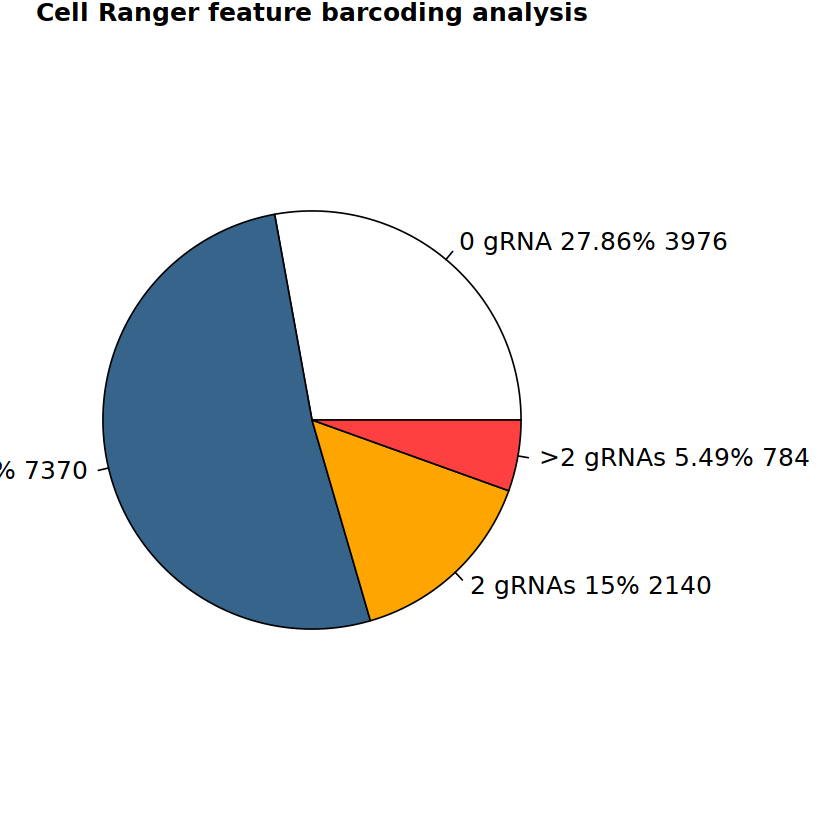

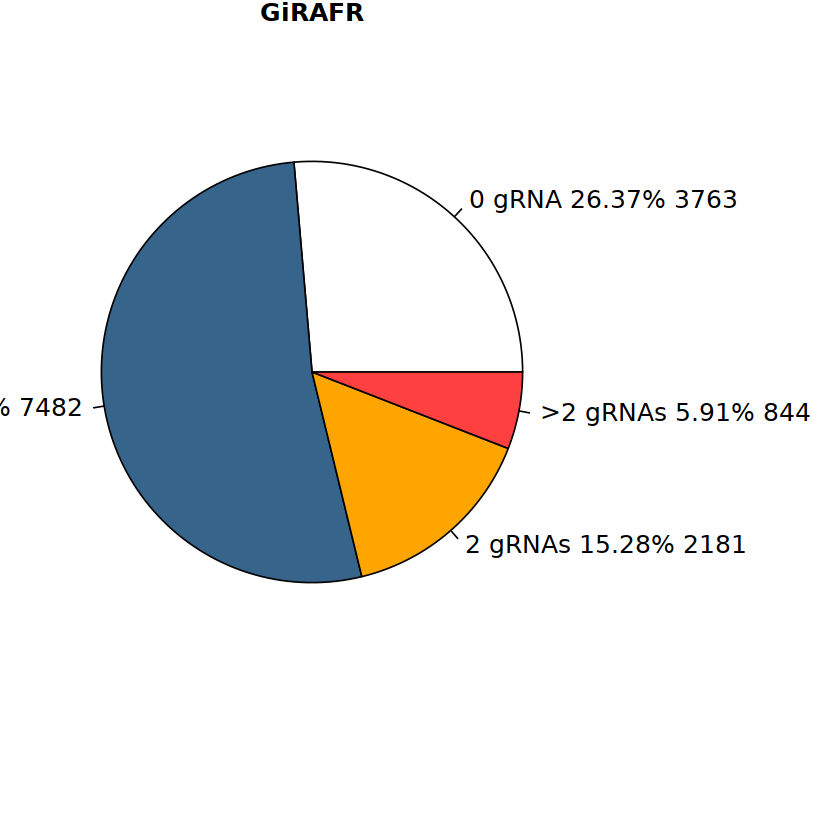

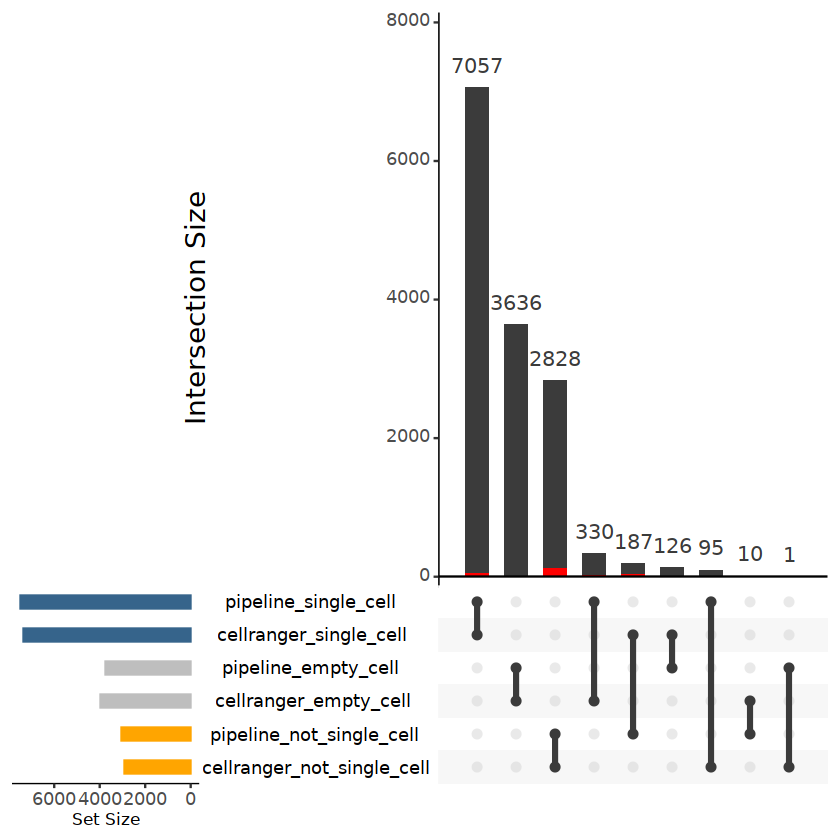

In [53]:
protospacer_file <- paste0(fba_input_dir, '/outs/crispr_analysis/protospacer_calls_per_cell.csv')
barcodes_file <- paste0(fba_input_dir, '/outs/filtered_feature_bc_matrix/barcodes.tsv.gz')
protospacer_calls_per_cell <-read.csv(protospacer_file, stringsAsFactors = FALSE)
cellranger_barcode <- read_csv(barcodes_file, col_names = FALSE)


pipeline_NotEmpty <- cells.num_features$cb
pipeline_Single <- cells.num_features$cb[which(cells.num_features$num_features == 1)]
par(mar = c(1,1,1,10))
slices1 <- c(nrow(cellranger_barcode) - sum(table(protospacer_calls_per_cell$num_features)),
        as.vector(table(protospacer_calls_per_cell$num_features)[1]),
        as.vector(table(protospacer_calls_per_cell$num_features)[2]),
        sum(table(protospacer_calls_per_cell$num_features)[-(1:2)]))
lbls1 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct1 <- round(slices1/sum(slices1)*100, digit =2 )
lbls1 <- paste(lbls1, pct1) # add percents to labels
lbls1 <- paste(lbls1,"%",sep="") # ad % to labels
lbls1 <- paste(lbls1, slices1, sep =' ')
pie(slices1, labels = lbls1, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"), 
    main = 'Cell Ranger feature barcoding analysis')

par(mar = c(5,1,1,10))
slices2 <- c(nrow(cellranger_barcode) - sum(table(cells.num_features$num_features)),
        as.vector(table(cells.num_features$num_features)[1]),
        as.vector(table(cells.num_features$num_features)[2]),
        sum(table(cells.num_features$num_features)[-(1:2)]))
lbls2 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct2 <- round(slices2/sum(slices2)*100, digit = 2)
lbls2 <- paste(lbls2, pct2) # add percents to labels
lbls2 <- paste(lbls2,"%",sep="") # ad % to labels
lbls2 <- paste(lbls2, slices2, sep =' ')
pie(slices2, labels = lbls2, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"),
   main = 'GiRAFR')

all_barcodes <- as.data.frame(cellranger_barcode)
all_barcodes$pipeline_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 1, 0)
all_barcodes$pipeline_empty_cell <- ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 0, 1)
all_barcodes$pipeline_not_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 0, 
                                            ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 1, 0))

all_barcodes$cellranger_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 1, 0)
all_barcodes$cellranger_empty_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 0, 1)
all_barcodes$cellranger_not_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 0, 
                                            ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 1, 0))
all_barcodes <- merge(all_barcodes, cells.has_MT, by.x = 'X1', by.y = 'cb', all.x = TRUE)



Myfunc <- function(row) {data <- (row["has_MT"] == TRUE)}
p <- upset(data = all_barcodes, 
      queries = list(list(query = Myfunc, color = "red", active = T)),
      sets = c('cellranger_not_single_cell','pipeline_not_single_cell',
           'cellranger_empty_cell','pipeline_empty_cell',
           'cellranger_single_cell','pipeline_single_cell'), order.by = "freq",keep.order = TRUE,sets.bar.color=c("orange","orange","grey","grey","steelblue4","steelblue4"), 
      point.size =2.5,line.size = 1.3,text.scale = c(2, 1.5, 1.2, 1.5, 1.5, 2))

p


In [54]:
table(all_barcodes[which(all_barcodes$cellranger_empty_cell == 1),'has_MT'])


FALSE  TRUE 
  319    21 

In [55]:
table(all_barcodes$has_MT)


FALSE  TRUE 
10276   231 

### Analysis impact of mutant gRNA and doublets

In [56]:
input_dir

[1] "../Belk_CancerCell/V41_M2R/"

In [57]:
cells.gRNA.single.MT <- read.table(paste0(input_dir, 'cells.gRNA.single.MT.txt'), stringsAsFactors = FALSE)
cells.gRNA.single.MT$target <- sapply(strsplit(cells.gRNA.single.MT$V3,"_"), `[`, 1)
cells.gRNA.single.MT[grepl('CTRL1',cells.gRNA.single.MT$target),]$target <- 'Control'
cells.gRNA.single.MT$is_WT <- !grepl(pattern = 'variant',cells.gRNA.single.MT$V3)
#table(cells.gRNA.single.MT$is_WT)
cells.gRNA.single.MT$cb = paste0(cells.gRNA.single.MT$V1, '-1')

In [58]:
diff_cb <- pipeline_Single[!pipeline_Single %in% cells.gRNA.single.MT$cb]
length(diff_cb)

[1] 101

pipeline_Single

In [59]:
all.matrix <- Read10X(paste0(fba_input_dir,'/outs/filtered_feature_bc_matrix/'))
expression.seurat.ori = CreateSeuratObject(counts = all.matrix$`Gene Expression`)
expression.seurat <- subset(expression.seurat.ori, cells = pipeline_Single)

expression.seurat <- NormalizeData(object = expression.seurat, normalization.method = "LogNormalize", scale.factor = 10000)
rownames(cells.gRNA.single.MT) <- cells.gRNA.single.MT$cb
expression.seurat@meta.data$KO <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'target']
expression.seurat@meta.data$is_WT <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'is_WT']
expression.seurat@meta.data$mutation <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'V5']
expression.seurat@meta.data$cb <- rownames(expression.seurat@meta.data)

10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


New single cells after removal of TSO shown as NA

In [60]:
sum(is.na(expression.seurat@meta.data$KO)) 
# should be same as length(diff_cb) 

[1] 101

In [61]:
rownames(cells.has_MT) <- cells.has_MT$cb
expression.seurat@meta.data$has_MT <- cells.has_MT[rownames(expression.seurat@meta.data), ]$has_MT

Warning message:
“Setting row names on a tibble is deprecated.”


In [62]:
diff_cb_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% diff_cb),]
rownames(diff_cb_gRNA) <- diff_cb_gRNA$cb

In [63]:
# replace KO NA into target
expression.seurat@meta.data$KO[which(expression.seurat@meta.data$cb %in% diff_cb)] <- 
sapply(strsplit(diff_cb_gRNA[rownames(expression.seurat@meta.data[which(expression.seurat@meta.data$cb %in% diff_cb),]), 'target'], '_'), `[`, 1)

In [64]:
table(expression.seurat@meta.data$is_WT, expression.seurat@meta.data$has_MT)
# has some discrepancy 

       
        FALSE TRUE
  FALSE    20   70
  TRUE   7291    0

In [65]:
#expression.seurat@meta.data[which(expression.seurat@meta.data$is_WT == FALSE & expression.seurat@meta.data$has_MT == FALSE),]

In [66]:
expression.seurat$KO[expression.seurat$KO == 'CTRL1'] <- 'Control'
expression.seurat$KO[expression.seurat$KO == 'ARID1A'] <- 'Arid1a'
expression.seurat$KO[expression.seurat$KO == 'SMARCC1'] <- 'Smarcc1'
expression.seurat$KO[expression.seurat$KO == 'ACTR5'] <- 'Actr5'
expression.seurat$KO[expression.seurat$KO == 'ARID1B'] <- 'Arid1b'
expression.seurat$KO[expression.seurat$KO == 'INO80C'] <- 'Ino80c'
expression.seurat$KO[expression.seurat$KO == 'ARID2'] <- 'Arid2'
expression.seurat$KO[expression.seurat$KO == 'GATA3'] <- 'Gata3'
expression.seurat$KO[expression.seurat$KO == 'PDCD1'] <- 'Pdcd1'
expression.seurat$KO[expression.seurat$KO == 'SMARCD2'] <- 'Smarcd2'

In [67]:
unique(expression.seurat$KO)

[1] "Pdcd1"   "Control" "Smarcc1" "Gata3"   "Arid1a"  "Actr5"   "Smarcd2"
 [8] "Ino80c"  "Arid2"   "Arid1b"

In [68]:
targets <- unique(expression.seurat@meta.data$KO)
targets <- targets[targets!='Control']
all.exp2.df <- data.frame()
CTRL_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == 'Control'),])
for(gene in targets){
        KO_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == gene),])
        tmp.df <- rbind(data.frame(expression = expression.seurat@assays$RNA@data[gene, KO_cells], type = 'KO'),
            data.frame(expression = expression.seurat@assays$RNA@data[gene, CTRL_cells], type = 'Control'))

        tmp.df$target = gene
        tmp.df$cb = rownames(tmp.df)
        all.exp2.df <- rbind(all.exp2.df, tmp.df)
}

Target gene expression in Control

In [69]:
avg.exp.control <- all.exp2.df[which(all.exp2.df$type == 'Control'),] %>% group_by(target) %>% summarise(avg = mean(expression))
avg.exp.control <- as.data.frame(avg.exp.control)
rownames(avg.exp.control) <- avg.exp.control$target

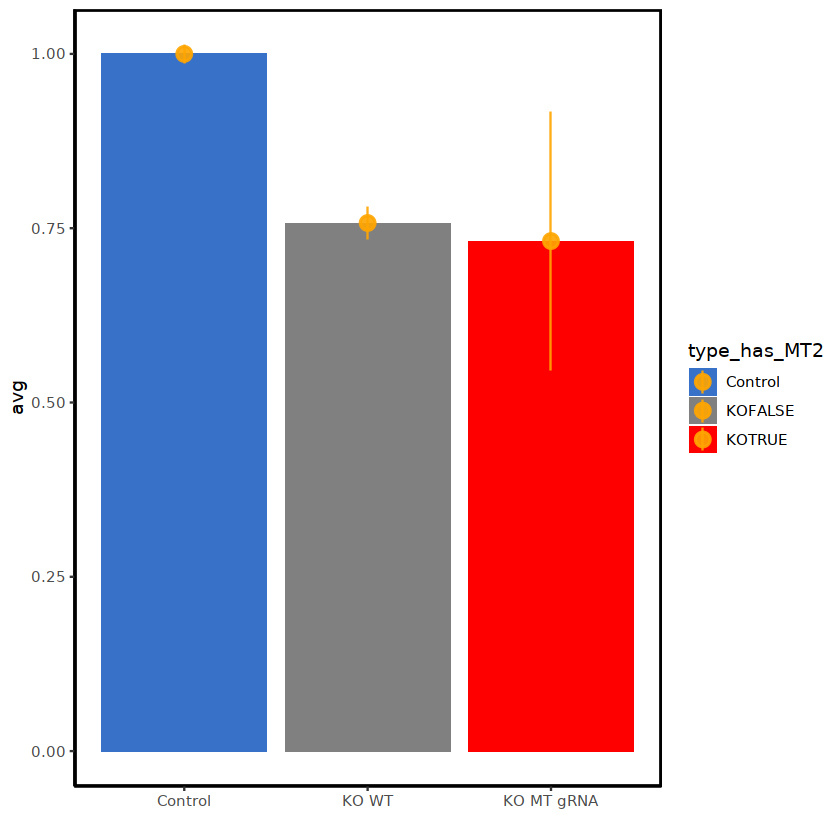

In [70]:
#all.exp2.MT.df <- merge(all.exp2.df, cells.gRNA.single.MT[,c(4,5,8,9)], by = 'cb')
all.exp2.MT.df <- merge(all.exp2.df, expression.seurat@meta.data[,c(4,6,7,8)], by = 'cb')
all.exp2.MT.df$type_has_MT <- paste0(all.exp2.MT.df$type, all.exp2.MT.df$has_MT)

all.exp2.MT.df$type_has_MT2 <- all.exp2.MT.df$type_has_MT
all.exp2.MT.df[which(all.exp2.MT.df$type_has_MT == 'ControlFALSE' |
    all.exp2.MT.df$type_has_MT == 'ControlNA' |
    all.exp2.MT.df$type_has_MT == 'ControlTRUE'),'type_has_MT2'] <- 'Control'


all.exp2.MT.df$expression_norm <- all.exp2.MT.df$expression/avg.exp.control[all.exp2.MT.df$target,'avg']

# high_exp_targets <- avg.exp.control$target[order(avg.exp.control$avg, decreasing = T)]
# tmp.df <- all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets), c('tmp','expression_norm')]

tmp.df <- all.exp2.MT.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm),
                                                 sem = sd(expression_norm)/sqrt(n))

p1 <- ggplot(tmp.df, aes(x = type_has_MT2, y = avg, fill = type_has_MT2)) + geom_col()+
        geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
        theme_classic()+
        xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
        scale_fill_manual(breaks = c("Control", "KOFALSE","KOTRUE"),
                          values=c("#3771c8", "#808080",'#ff0000'))+
        scale_x_discrete(limits = c("Control", "KOFALSE", "KOTRUE"), labels=c("Control" = "Control", "KOFALSE" = "KO WT", "KOTRUE" = "KO MT gRNA"))

print(p1)

### Analysis impact of doublets/multiplets

In [71]:
new_doublets <- all_barcodes[which(all_barcodes$pipeline_not_single_cell == 1 & all_barcodes$cellranger_single_cell == 1), 'X1']
length(new_doublets) 
# pipeline identified doubets, cellranger as single

[1] 187

For new doublets, following scenarios:
1. doublets with the mutant gRNA and wildtype gRNA targeting the same gene, 
2. doublets with the mutant gRNA and wildtype gRNA targeting the different gene
3. doublets with two wildtype gRNA targeting the same gene
4. doublets with two wildtype gRNA targeting different gene
5. doublets with two mutant gRNAs targeting different gene

In [72]:
new_doublets_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% new_doublets),] # the mutant gRNA and wildtype gRNA targeting the same gene,

In [73]:
new_doublets_type1 <- new_doublets_gRNA[which(new_doublets_gRNA$feature_order >= 2),]

In [74]:
new_doublets_gRNA2 <- as.data.frame(new_doublets_gRNA[which(new_doublets_gRNA$feature_order < 2),] %>% group_by(cb) %>% summarise(target = list(target), UMIs = list(num_UMI_WT)))


In [75]:
new_doublets_gRNA2$KO <- lapply(new_doublets_gRNA2$target, function(x) sapply(strsplit(x, '_'), `[`, 1))

In [76]:
if1 <- lapply(new_doublets_gRNA2$KO, function(x) x[1]== x[2])
if2 <- lapply(new_doublets_gRNA2$UMIs, function(x) x[1]>0 & x[2] > 0)
              
new_doublets_type_unknown <- c()
new_doublets_type2 <- c()
new_doublets_type3 <- c()
new_doublets_type4 <- c()
new_doublets_type5 <- c()
for(i in 1:nrow(new_doublets_gRNA2)){
    if(is.na(if1[i]) | is.na(if2[i])){
        new_doublets_type_unknown <- rbind(new_doublets_type_unknown, new_doublets_gRNA2[i,])
    }else{
    if(if1[i] == TRUE & if2[i] == TRUE){ # two wiltype gRNA targeting the same target
        new_doublets_type3 <- rbind(new_doublets_type3, new_doublets_gRNA2[i,])
    }else if(if1[i] == TRUE & if2[i] == FALSE){ #  mutant gRNA and wildtype gRNA or two muatnt targeting the same gene
        new_doublets_type2 <- rbind(new_doublets_type2, new_doublets_gRNA2[i,])
    }else if(if1[i] == FALSE & if2[i] == TRUE){# two wildtype gRNA targeting different gene
        new_doublets_type4 <- rbind(new_doublets_type4, new_doublets_gRNA2[i,]) 
    }else if(if1[i] == FALSE & if2[i] == FALSE){ # mutant gRNA and wildtype gRNA or two muatnt  different gene 
        new_doublets_type5 <- rbind(new_doublets_type5, new_doublets_gRNA2[i,])
    }else{
        print('unknown error')
    }
    }
}

In [77]:
nrow(new_doublets_type1)
nrow(new_doublets_type2)
nrow(new_doublets_type3)
nrow(new_doublets_type4)
nrow(new_doublets_type5)
nrow(new_doublets_type_unknown)

[1] 27

[1] 2

[1] 10

[1] 139

[1] 9

[1] 1

In [78]:
new_doublets_subset <- rbind(new_doublets_type4, new_doublets_type5)$cb
length(new_doublets_subset)

[1] 148

In [79]:
seurat.object.doublets <- subset(expression.seurat.ori, cells = new_doublets_subset)
seurat.object.doublets <- NormalizeData(object = seurat.object.doublets, normalization.method = "LogNormalize", scale.factor = 10000)
seurat.object.doublets

An object of class Seurat 
32333 features across 148 samples within 1 assay 
Active assay: RNA (32333 features, 0 variable features)
 2 layers present: counts, data

In [80]:
#head(rbind(new_doublets_type4, new_doublets_type5))

In [81]:
protospacer.df <- read.csv(protospacer_file)
rownames(protospacer.df) <- protospacer.df$cell_barcode

In [82]:
seurat.object.doublets@meta.data <- cbind(seurat.object.doublets@meta.data, protospacer.df[colnames(seurat.object.doublets),])
seurat.object.doublets$KO <- sapply(strsplit(seurat.object.doublets@meta.data$feature_call, '_'), `[`, 1)

In [83]:
seurat.object.doublets$KO[seurat.object.doublets$KO == 'CTRL1'] <- 'Control'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'ARID1A'] <- 'Arid1a'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'SMARCC1'] <- 'Smarcc1'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'ACTR5'] <- 'Actr5'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'ARID1B'] <- 'Arid1b'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'INO80C'] <- 'Ino80c'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'ARID2'] <- 'Arid2'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'GATA3'] <- 'Gata3'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'PDCD1'] <- 'Pdcd1'
seurat.object.doublets$KO[seurat.object.doublets$KO == 'SMARCD2'] <- 'Smarcd2'

In [84]:
doublets_targets <- unique(seurat.object.doublets$KO)[-which(unique(seurat.object.doublets$KO) == 'Control')] # remove 'neg'
doublets.exp.df <- data.frame()
CTRL_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == 'Control'),])

for(gene in doublets_targets){
    KO_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == gene),])
   tmp.df <- rbind(data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, KO_cells], type = 'KO_doublets'),
                    data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, CTRL_cells], type = 'Control_doublets'))
   tmp.df$target = gene
   tmp.df$cb = c(KO_cells, CTRL_cells)
   doublets.exp.df <- rbind(doublets.exp.df, tmp.df)
}

In [85]:
doublets.exp.df$type_has_MT2 <- doublets.exp.df$type

In [86]:
doublets.exp.df$expression_norm <- doublets.exp.df$expression/avg.exp.control[doublets.exp.df$target,'avg']

In [87]:
all.exp2.doublets.df <- rbind(doublets.exp.df, all.exp2.MT.df[, c('expression', 'type', 'target', 'cb', 'type_has_MT2', 'expression_norm')])

In [88]:
table(all.exp2.doublets.df$type_has_MT)


         Control Control_doublets      KO_doublets          KOFALSE 
           20718              441               99             5129 
          KOTRUE 
              51 

In [89]:
tmp.df <- all.exp2.doublets.df
tmp.df <- tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
tmp.df

type_has_MT2,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,20718,1.0000000,1.948739,0.01353879
Control_doublets,441,1.1289152,1.883176,0.08967503
KOFALSE,5129,0.7574174,1.685079,0.02352903
KOTRUE,51,0.7315601,1.326862,0.18579781
KO_doublets,99,1.2845309,1.999312,0.20093837


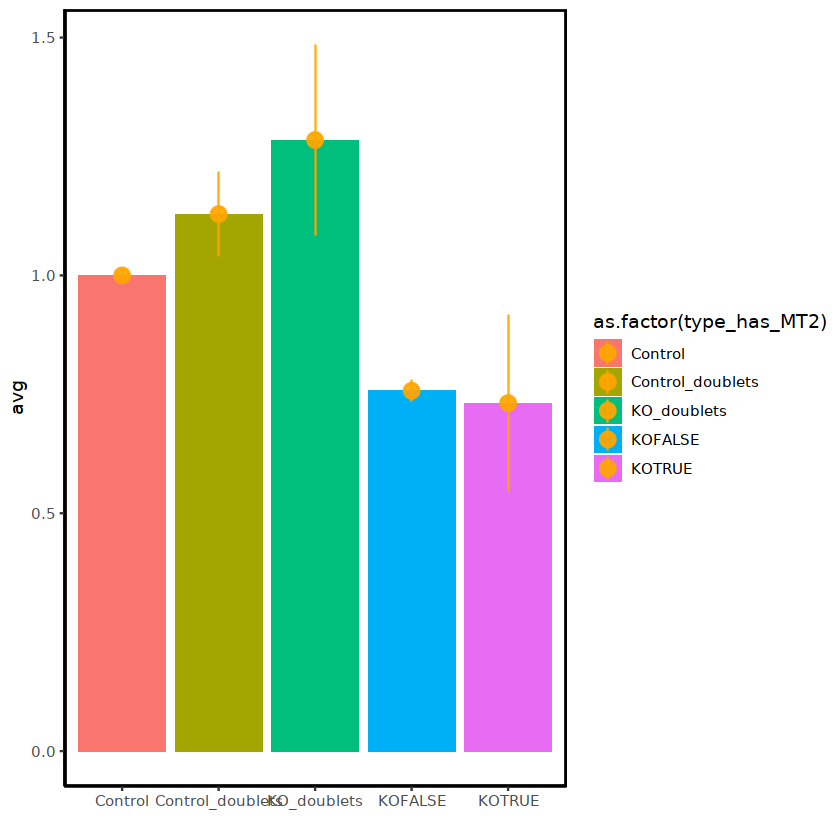

In [90]:
ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = avg, fill = as.factor(type_has_MT2))) + 
geom_col()+
#geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), width=.2,position=position_dodge(.9)) +
#geom_pointrange(aes(x=nr_mutation, y=avg, ymin=avg-sd, ymax=avg+sd), colour="orange", alpha=0.9, size=1.3)+
geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))


In [91]:
dim(all.exp2.doublets.df)
all.exp2.doublets.df_sample2 <- all.exp2.doublets.df

[1] 26438     6

## Combine two samples for Belk

In [92]:
dim(all.exp2.doublets.df_sample1)
dim(all.exp2.doublets.df_sample2)

[1] 10256     6

[1] 26438     6

In [93]:
all.exp2.doublets.df_combine <- rbind(all.exp2.doublets.df_sample1, all.exp2.doublets.df_sample2)

type_has_MT2,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,28845,1.0000000,2.266239,0.01334352
Control_doublets,585,1.0618275,1.980454,0.08188168
KOFALSE,7031,0.7731856,1.983397,0.02365381
KOTRUE,72,0.7770333,1.654613,0.19499799
KO_doublets,161,0.9533862,1.932123,0.15227259


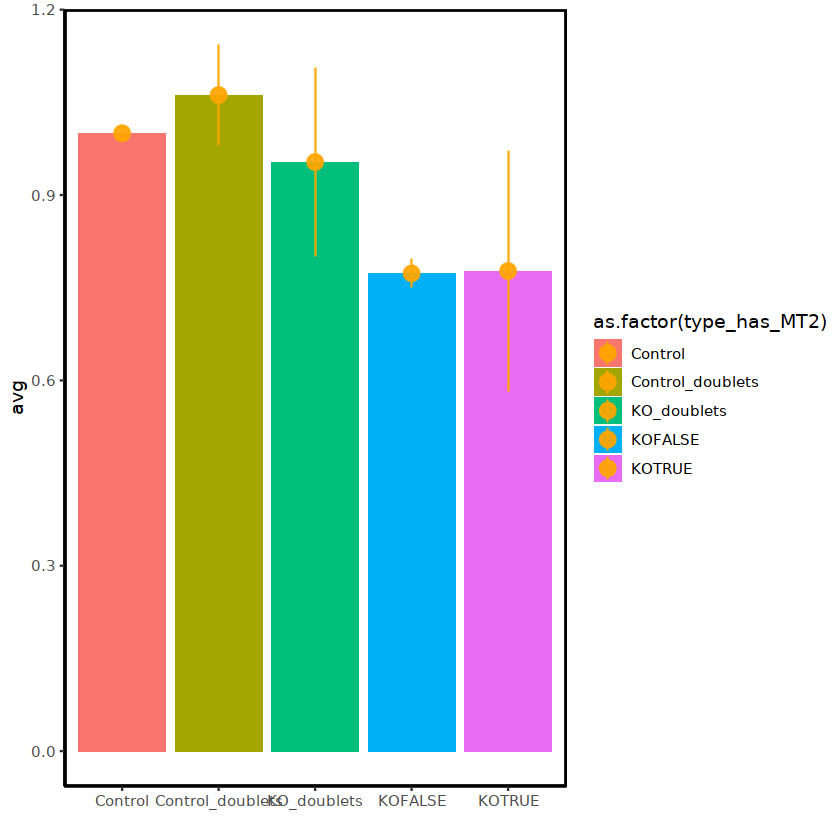

In [94]:
#pdf('Belk_gRNA_target_exp.pdf')
tmp.df <- all.exp2.doublets.df_combine
tmp.df <- tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
tmp.df

ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = avg, fill = as.factor(type_has_MT2))) + 
geom_col()+
#geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), width=.2,position=position_dodge(.9)) +
#geom_pointrange(aes(x=nr_mutation, y=avg, ymin=avg-sd, ymax=avg+sd), colour="orange", alpha=0.9, size=1.3)+
geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))
#dev.off()

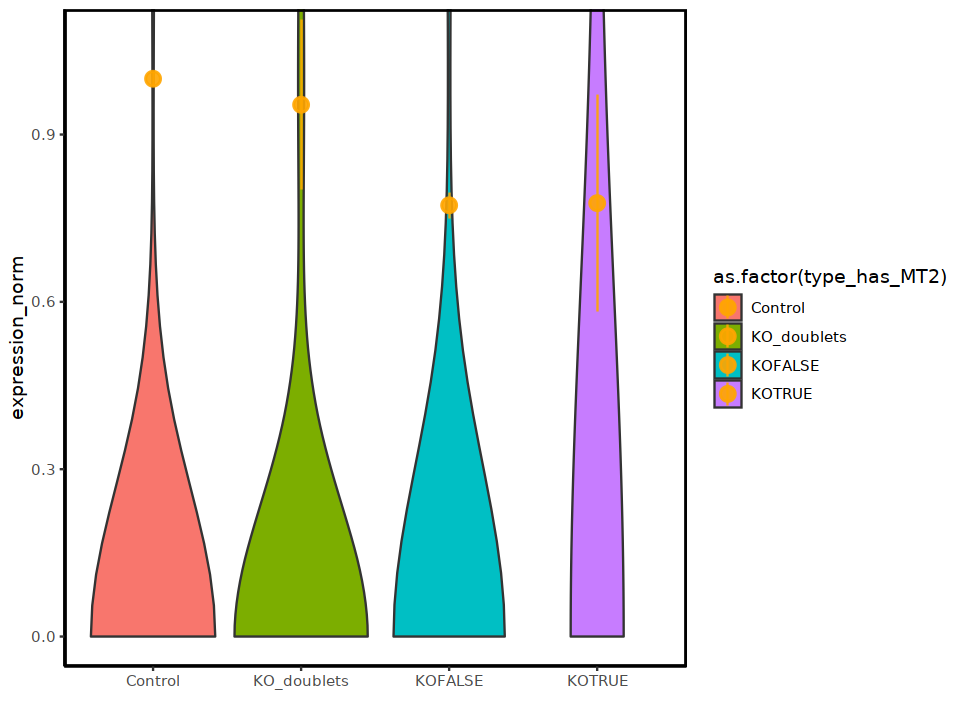

In [104]:
options(repr.plot.width = 8, repr.plot.height = 6)
#pdf('Belk_gRNA_target_exp_violin.pdf')
tmp.df <- all.exp2.doublets.df_combine
tmp.df <- tmp.df[which(tmp.df$type_has_MT2 != 'Control_doublets'),]
tmp <-  tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), 
                                                 sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
ylims <- tmp.df %>%
  group_by(type_has_MT2) %>%
  summarise(Q1 = quantile(expression_norm, 1/4), Q3 = quantile(expression_norm, 3/4)) %>%
  ungroup() %>%
  #get lowest Q1 and highest Q3
  summarise(lowQ1 = min(Q1), highQ3 = max(Q3))

ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = expression_norm, fill = as.factor(type_has_MT2))) + 
geom_violin()+
coord_cartesian(ylim = as.numeric(ylims)*1.1)+ # zoom in
geom_pointrange(data = tmp, aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem),
                colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme(panel.border =element_rect(colour = 'black', fill = NA, size = 1))
#dev.off()

# Direct Capture seq

## Sample 1

### remove TSO

In [105]:
output_dir = './tmp/test'
input_dir = '../Direct_perturb_seq/'
fba_input_dir = '/lustre1/project/stg_00064/projects/cropseq/267genes/develop/public_data/Direct_perturb_seq/feature_barcoding_analysis/sgRNAcs2'

[1] "MT mutation table"

   A    C D(1) D(2) D(3) D(4) D(5) D(8)    G I(1) I(2) I(3)    T 
  53    9   23   15   10    5    2    1    7   86   23    3    5 
[1] "MT mutation type"

  D   I   S 
 56 112  74 
[1] "MT mutation structure"

gRNA Rest  TSO 
  76   50  116 


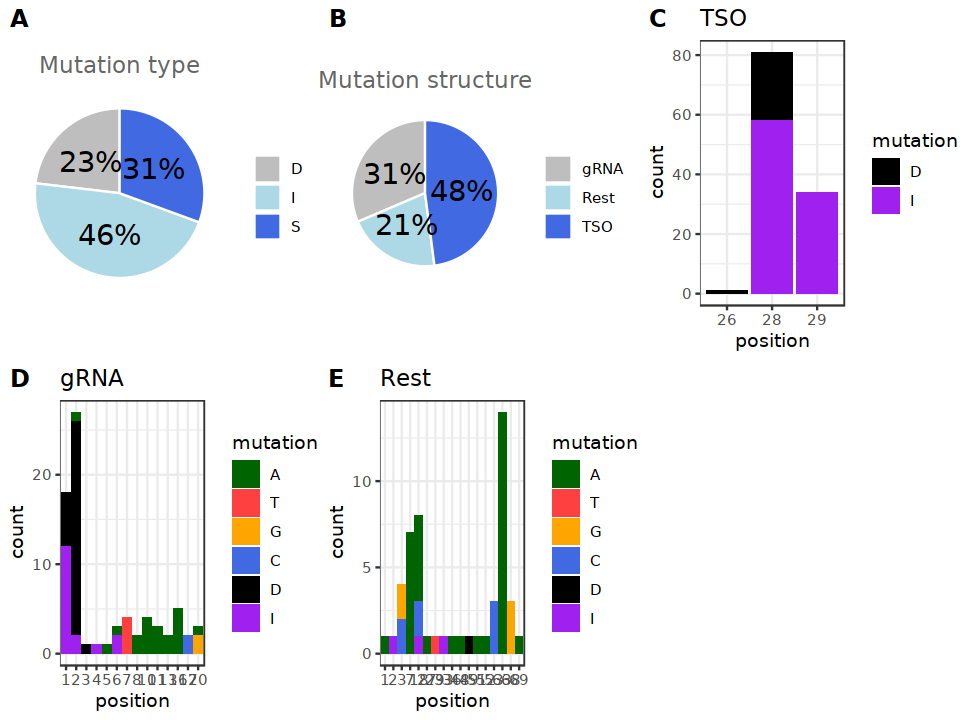

In [106]:
MT <- plot_MT_pattern(input_dir, output_dir)
MT2 <- MT
MT2[which(MT2$structure == 'TSO'), 'position'] <- MT2[which(MT2$structure == 'TSO'), 'position']-30
MT2[which(MT2$structure == 'gRNA'), 'position'] <- MT2[which(MT2$structure == 'gRNA'), 'position'] - 1
MT2[which(MT2$structure == 'Rest'),'position'] <- MT2[which(MT2$structure == 'Rest'),'position']+20

MT2 <- MT2[-which(MT2$position %in% c(-1, -2,0) & MT2$mutation2 %in% c('I','D')),]
######### Needs to be put before factor(MT2$position) otherwise will change the dedup
MT2$dedup <- paste0(MT2$`gene name`, MT2$structure, MT2$`structure length`, MT2$position, MT2$mutation)
tmp <- MT2 %>% group_by(`variant number`) %>% summarise(mutations = list(dedup))
MT2_nodedup <- MT2
MT2 <- MT2[which(!MT2$`variant number` %in% tmp$`variant number`[duplicated(tmp$mutations)]),]
rm(tmp)
#########



In [107]:
#dim(MT2) # presumed real mutant sgRNAs after removal of TSO artifacts without dedup
MT2_list_nodedup <- unique(MT2_nodedup$`variant number`)
length(MT2_list_nodedup)

[1] 102

In [108]:
cells_gRNA_file <- paste0(input_dir, '/cells.gRNA.txt')
n_col = max(count.fields(cells_gRNA_file, sep = "\t"))
cells.gRNA <- read.table(cells_gRNA_file, 
                     header = FALSE, fill = TRUE, stringsAsFactors = FALSE,col.names =1:n_col)

colnames(cells.gRNA)[1:7]= c('cb','feature_order','target','WT','num_UMI_WT', 'MT','num_UMI_MT')
cells.gRNA$cb <- paste0(cells.gRNA$cb,'-1')
cells.gRNA.ori <- cells.gRNA

In [109]:
cells.gRNA <- cells.gRNA.ori
cells.gRNA.WTcounts <- cells.gRNA[,1:5]
for(i in seq(6,n_col-2,2)){
    MT.df <- cells.gRNA[,i:(i+1)]
    colnames(MT.df) <- c('MT','num_UMI_MT')
    MT.notInlist <- MT.df[!MT.df$MT %in% MT2_list_nodedup,]
    index <- !MT.df$MT %in% MT2_list_nodedup
    MT.notInlist$num_UMI_MT[is.na(MT.notInlist$num_UMI_MT)] <- 0
    cells.gRNA.WTcounts$num_UMI_WT[index] <- cells.gRNA.WTcounts$num_UMI_WT[index] + MT.notInlist$num_UMI_MT
    cells.gRNA[index,i:(i+1)] <- NA # make MT not in list as NA
}
cells.gRNA[,1:5] <- cells.gRNA.WTcounts
for(i in seq(1, nrow(cells.gRNA))){
    num_MT <- (sum(!is.na(cells.gRNA[i,])) - 5)/2 #updated number of gRNA
    if(cells.gRNA[i,5] > 0){
        cells.gRNA$feature_order[i] <- num_MT + 1
    }else{
        cells.gRNA$feature_order[i] <- num_MT
    }
}
# now feature order is no longer accumulated 
cells.num_features <- cells.gRNA %>% group_by(cb) %>% summarise(num_features = sum(feature_order))
#cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(is_MT))
cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(contain_MT, is_MT))

# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


In [110]:
table(cells.num_features$num_features)
sum(table(cells.num_features$num_features))


   1    2    3    4    5 
4965 1376  207   38    5 

[1] 6591

In [111]:
sum(cells.num_features$num_features) # cells (actual cells, count multiplets multiple times)
tmp <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0))
# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA
sum(cells.gRNA[which(cells.gRNA$num_UMI_WT > 0),'feature_order']-1) + sum(cells.gRNA[which(cells.gRNA$num_UMI_WT == 0),'feature_order'])
# cells with mutations (multiplets count as multiple)

[1] 8515

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


[1] 1438

Rows: 8272 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


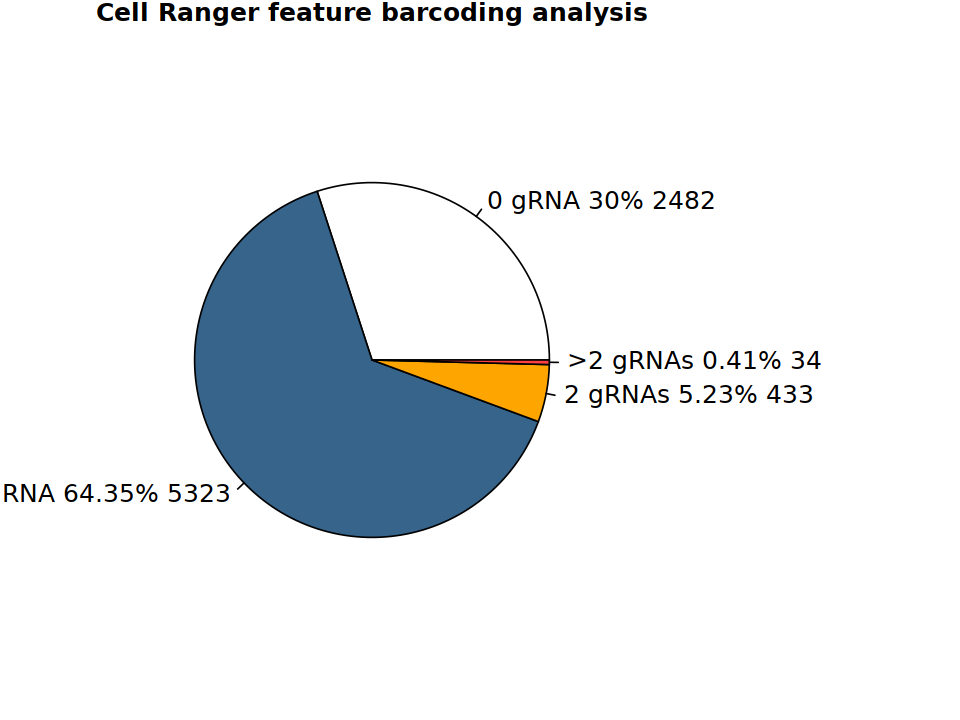

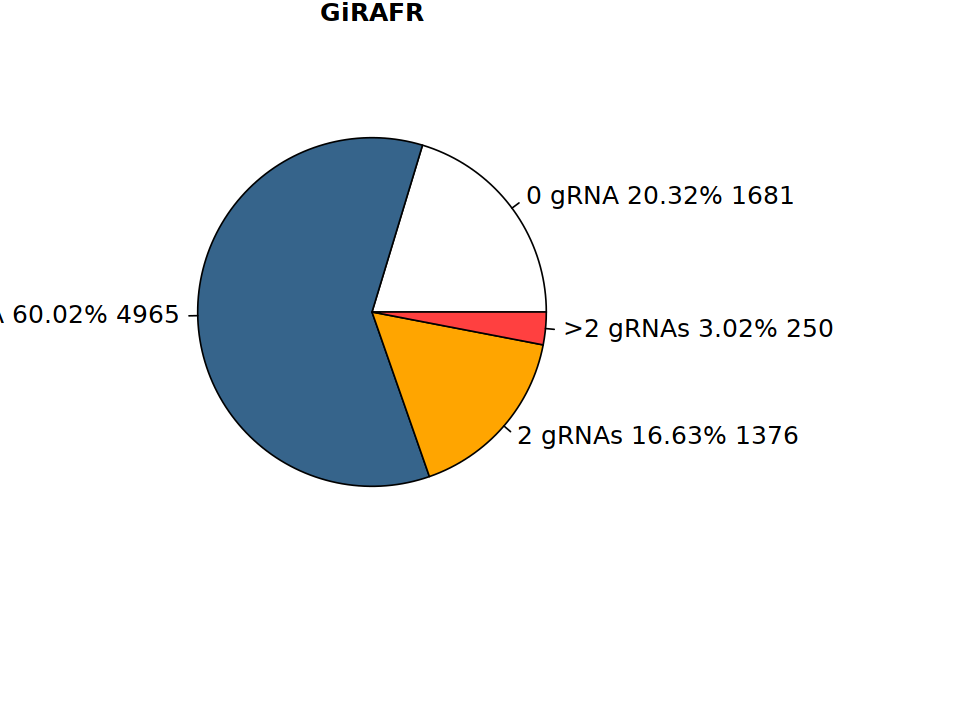

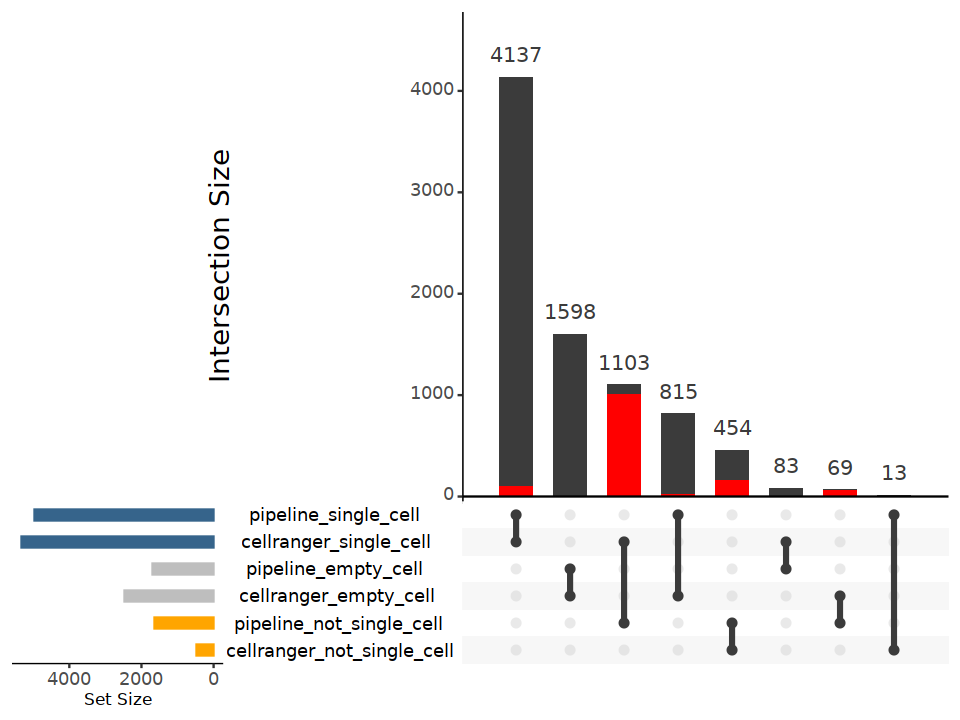

In [112]:
protospacer_file <- paste0(fba_input_dir, '/outs/crispr_analysis/protospacer_calls_per_cell.csv')
barcodes_file <- paste0(fba_input_dir, '/outs/filtered_feature_bc_matrix/barcodes.tsv.gz')
protospacer_calls_per_cell <-read.csv(protospacer_file, stringsAsFactors = FALSE)
cellranger_barcode <- read_csv(barcodes_file, col_names = FALSE)


pipeline_NotEmpty <- cells.num_features$cb
pipeline_Single <- cells.num_features$cb[which(cells.num_features$num_features == 1)]
par(mar = c(1,1,1,10))
slices1 <- c(nrow(cellranger_barcode) - sum(table(protospacer_calls_per_cell$num_features)),
        as.vector(table(protospacer_calls_per_cell$num_features)[1]),
        as.vector(table(protospacer_calls_per_cell$num_features)[2]),
        sum(table(protospacer_calls_per_cell$num_features)[-(1:2)]))
lbls1 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct1 <- round(slices1/sum(slices1)*100, digit =2 )
lbls1 <- paste(lbls1, pct1) # add percents to labels
lbls1 <- paste(lbls1,"%",sep="") # ad % to labels
lbls1 <- paste(lbls1, slices1, sep =' ')
pie(slices1, labels = lbls1, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"), 
    main = 'Cell Ranger feature barcoding analysis')

par(mar = c(5,1,1,10))
slices2 <- c(nrow(cellranger_barcode) - sum(table(cells.num_features$num_features)),
        as.vector(table(cells.num_features$num_features)[1]),
        as.vector(table(cells.num_features$num_features)[2]),
        sum(table(cells.num_features$num_features)[-(1:2)]))
lbls2 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct2 <- round(slices2/sum(slices2)*100, digit = 2)
lbls2 <- paste(lbls2, pct2) # add percents to labels
lbls2 <- paste(lbls2,"%",sep="") # ad % to labels
lbls2 <- paste(lbls2, slices2, sep =' ')
pie(slices2, labels = lbls2, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"),
   main = 'GiRAFR')

all_barcodes <- as.data.frame(cellranger_barcode)
all_barcodes$pipeline_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 1, 0)
all_barcodes$pipeline_empty_cell <- ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 0, 1)
all_barcodes$pipeline_not_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 0, 
                                            ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 1, 0))

all_barcodes$cellranger_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 1, 0)
all_barcodes$cellranger_empty_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 0, 1)
all_barcodes$cellranger_not_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 0, 
                                            ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 1, 0))
all_barcodes <- merge(all_barcodes, cells.has_MT, by.x = 'X1', by.y = 'cb', all.x = TRUE)



Myfunc <- function(row) {data <- (row["has_MT"] == TRUE)}
p <- upset(data = all_barcodes, 
      queries = list(list(query = Myfunc, color = "red", active = T)),
      sets = c('cellranger_not_single_cell','pipeline_not_single_cell',
           'cellranger_empty_cell','pipeline_empty_cell',
           'cellranger_single_cell','pipeline_single_cell'), order.by = "freq",keep.order = TRUE,sets.bar.color=c("orange","orange","grey","grey","steelblue4","steelblue4"), 
      point.size =2.5,line.size = 1.3,text.scale = c(2, 1.5, 1.2, 1.5, 1.5, 2))

p


In [113]:
table(all_barcodes[which(all_barcodes$cellranger_empty_cell == 1),'has_MT'])


FALSE  TRUE 
  806    78 

In [114]:
table(all_barcodes$has_MT)


FALSE  TRUE 
 5256  1335 

### Analysis impact of mutant gRNA and doublets

In [115]:
input_dir

[1] "../Direct_perturb_seq/"

In [116]:
cells.gRNA.single.MT <- read.table(paste0(input_dir, 'cells.gRNA.single.MT.txt'), stringsAsFactors = FALSE)
cells.gRNA.single.MT$target <- sapply(strsplit(cells.gRNA.single.MT$V3,"_"), `[`, 1)
cells.gRNA.single.MT[grepl('NegCtrl',cells.gRNA.single.MT$target),]$target <- 'Control'
cells.gRNA.single.MT$is_WT <- !grepl(pattern = 'variant',cells.gRNA.single.MT$V3)
#table(cells.gRNA.single.MT$is_WT)
cells.gRNA.single.MT$cb = paste0(cells.gRNA.single.MT$V1, '-1')

In [117]:
diff_cb <- pipeline_Single[!pipeline_Single %in% cells.gRNA.single.MT$cb]

pipeline_Single

In [118]:
all.matrix <- Read10X(paste0(fba_input_dir,'/outs/filtered_feature_bc_matrix/'))
expression.seurat.ori = CreateSeuratObject(counts = all.matrix$`Gene Expression`)
expression.seurat <- subset(expression.seurat.ori, cells = pipeline_Single)

expression.seurat <- NormalizeData(object = expression.seurat, normalization.method = "LogNormalize", scale.factor = 10000)
rownames(cells.gRNA.single.MT) <- cells.gRNA.single.MT$cb
expression.seurat@meta.data$KO <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'target']
expression.seurat@meta.data$is_WT <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'is_WT']
expression.seurat@meta.data$mutation <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'V5']
expression.seurat@meta.data$cb <- rownames(expression.seurat@meta.data)

10X data contains more than one type and is being returned as a list containing matrices of each type.



New single cells after removal of TSO shown as NA

In [119]:
sum(is.na(expression.seurat@meta.data$KO)) 
# should be same as length(diff_cb) 

[1] 2918

In [120]:
rownames(cells.has_MT) <- cells.has_MT$cb
expression.seurat@meta.data$has_MT <- cells.has_MT[rownames(expression.seurat@meta.data), ]$has_MT

Warning message:
“Setting row names on a tibble is deprecated.”


In [121]:
diff_cb_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% diff_cb),]
rownames(diff_cb_gRNA) <- diff_cb_gRNA$cb

In [122]:
# replace KO NA into target
expression.seurat@meta.data$KO[which(expression.seurat@meta.data$cb %in% diff_cb)] <- 
sapply(strsplit(diff_cb_gRNA[rownames(expression.seurat@meta.data[which(expression.seurat@meta.data$cb %in% diff_cb),]), 'target'], '_'), `[`, 1)

In [123]:
table(expression.seurat@meta.data$is_WT, expression.seurat@meta.data$has_MT)
# has some discrepancy 

       
        FALSE TRUE
  FALSE  1914  113
  TRUE     20    0

In [124]:
#expression.seurat@meta.data[which(expression.seurat@meta.data$is_WT == FALSE & expression.seurat@meta.data$has_MT == FALSE),]

In [125]:
expression.seurat$KO[grepl('NegCtrl', expression.seurat$KO)] <- 'Control'
expression.seurat$KO[which(expression.seurat$KO == 'SRPR')] <- 'SRPRA'
expression.seurat$KO[which(expression.seurat$KO == 'ATP5B')] <- 'ATP5F1B'

In [126]:
unique(expression.seurat$KO)

[1] "DDRGK1"   "IER3IP1"  "SRP68"    "UFM1"     "TTI2"     "TTI1"    
 [7] "Control"  "CARS"     "TMEM167A" "TELO2"    "OST4"     "EIF2B3"  
[13] "DAD1"     "SRPRA"    "TMED10"   "HARS"     "UFL1"     "SRP72"   
[19] "TIMM23"   "SEC61G"   "DDOST"    "MRPL39"   "QARS"     "EIF2B4"  
[25] "SCYL1"    "ATP5F1B"  "EIF2B2"   "YIPF5"    "SRPRB"    "TMED2"   
[31] "SEC61A1"

In [127]:
targets <- unique(expression.seurat@meta.data$KO)
targets <- targets[targets!='Control']
all.exp2.df <- data.frame()
CTRL_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == 'Control'),])
for(gene in targets){
        KO_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == gene),])
        tmp.df <- rbind(data.frame(expression = expression.seurat@assays$RNA@data[gene, KO_cells], type = 'KO'),
            data.frame(expression = expression.seurat@assays$RNA@data[gene, CTRL_cells], type = 'Control'))

        tmp.df$target = gene
        tmp.df$cb = rownames(tmp.df)
        all.exp2.df <- rbind(all.exp2.df, tmp.df)
}

Target gene expression in Control

In [128]:
avg.exp.control <- all.exp2.df[which(all.exp2.df$type == 'Control'),] %>% group_by(target) %>% summarise(avg = mean(expression))
avg.exp.control <- as.data.frame(avg.exp.control)
rownames(avg.exp.control) <- avg.exp.control$target

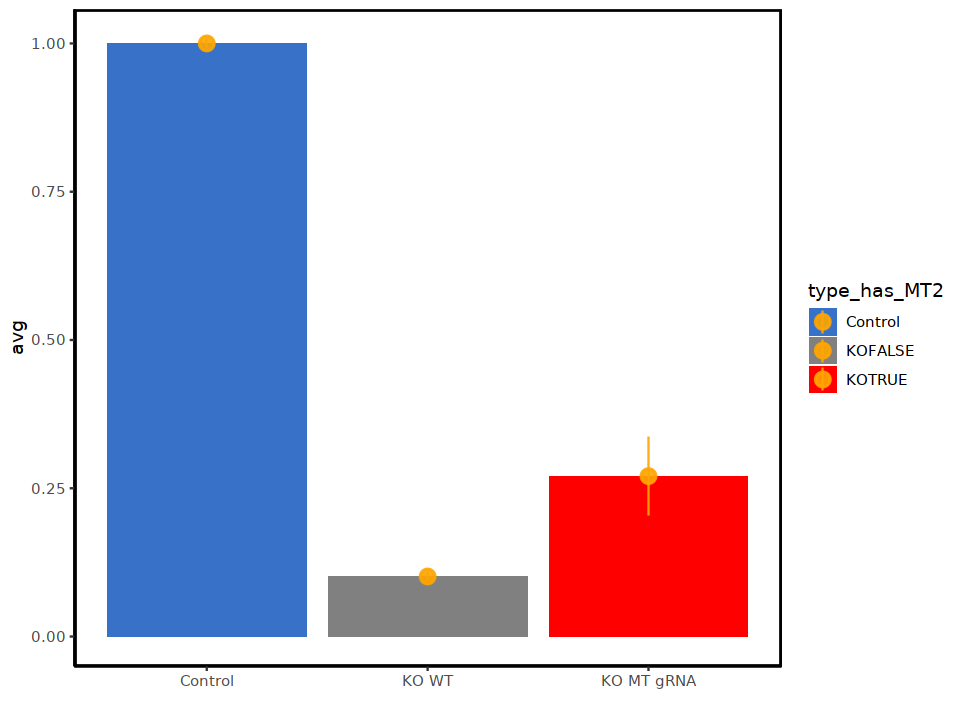

In [129]:
#all.exp2.MT.df <- merge(all.exp2.df, cells.gRNA.single.MT[,c(4,5,8,9)], by = 'cb')
all.exp2.MT.df <- merge(all.exp2.df, expression.seurat@meta.data[,c(4,6,7,8)], by = 'cb')
all.exp2.MT.df$type_has_MT <- paste0(all.exp2.MT.df$type, all.exp2.MT.df$has_MT)

all.exp2.MT.df$type_has_MT2 <- all.exp2.MT.df$type_has_MT
all.exp2.MT.df[which(all.exp2.MT.df$type_has_MT == 'ControlFALSE' |
    all.exp2.MT.df$type_has_MT == 'ControlNA' |
    all.exp2.MT.df$type_has_MT == 'ControlTRUE'),'type_has_MT2'] <- 'Control'


all.exp2.MT.df$expression_norm <- all.exp2.MT.df$expression/avg.exp.control[all.exp2.MT.df$target,'avg']

# high_exp_targets <- avg.exp.control$target[order(avg.exp.control$avg, decreasing = T)]
# tmp.df <- all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets), c('tmp','expression_norm')]

tmp.df <- all.exp2.MT.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm),
                                                 sem = sd(expression_norm)/sqrt(n))

p1 <- ggplot(tmp.df, aes(x = type_has_MT2, y = avg, fill = type_has_MT2)) + geom_col()+
        geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
        theme_classic()+
        xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
        scale_fill_manual(breaks = c("Control", "KOFALSE","KOTRUE"),
                          values=c("#3771c8", "#808080",'#ff0000'))+
        scale_x_discrete(limits = c("Control", "KOFALSE", "KOTRUE"), labels=c("Control" = "Control", "KOFALSE" = "KO WT", "KOTRUE" = "KO MT gRNA"))

print(p1)

### Analysis impact of doublets/multiplets

In [130]:
new_doublets <- all_barcodes[which(all_barcodes$pipeline_not_single_cell == 1 & all_barcodes$cellranger_single_cell == 1), 'X1']
length(new_doublets) 
# pipeline identified doubets, cellranger as single

[1] 1103

For new doublets, following scenarios:
1. doublets with the mutant gRNA and wildtype gRNA targeting the same gene, 
2. doublets with the mutant gRNA and wildtype gRNA targeting the different gene
3. doublets with two wildtype gRNA targeting the same gene
4. doublets with two wildtype gRNA targeting different gene
5. doublets with two mutant gRNAs targeting different gene

In [131]:
new_doublets_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% new_doublets),] # the mutant gRNA and wildtype gRNA targeting the same gene,

In [132]:
new_doublets_type1 <- new_doublets_gRNA[which(new_doublets_gRNA$feature_order >= 2),]

In [133]:
new_doublets_gRNA2 <- as.data.frame(new_doublets_gRNA[which(new_doublets_gRNA$feature_order < 2),] %>% group_by(cb) %>% summarise(target = list(target), UMIs = list(num_UMI_WT)))


In [134]:
new_doublets_gRNA2$KO <- lapply(new_doublets_gRNA2$target, function(x) sapply(strsplit(x, '_'), `[`, 1))

In [135]:
new_doublets_gRNA2$KO <- lapply(new_doublets_gRNA2$KO, function(x) ifelse(grepl('NegCtrl',x),'Control',x))

In [136]:
if1 <- lapply(new_doublets_gRNA2$KO, function(x) x[1]== x[2])
if2 <- lapply(new_doublets_gRNA2$UMIs, function(x) x[1]>0 & x[2] > 0)
              
new_doublets_type_unknown <- c()
new_doublets_type2 <- c()
new_doublets_type3 <- c()
new_doublets_type4 <- c()
new_doublets_type5 <- c()
for(i in 1:nrow(new_doublets_gRNA2)){
    if(is.na(if1[i]) | is.na(if2[i])){
        new_doublets_type_unknown <- rbind(new_doublets_type_unknown, new_doublets_gRNA2[i,])
    }else{
    if(if1[i] == TRUE & if2[i] == TRUE){ # two wiltype gRNA targeting the same target
        new_doublets_type3 <- rbind(new_doublets_type3, new_doublets_gRNA2[i,])
    }else if(if1[i] == TRUE & if2[i] == FALSE){ #  mutant gRNA and wildtype gRNA or two muatnt targeting the same gene
        new_doublets_type2 <- rbind(new_doublets_type2, new_doublets_gRNA2[i,])
    }else if(if1[i] == FALSE & if2[i] == TRUE){# two wildtype gRNA targeting different gene
        new_doublets_type4 <- rbind(new_doublets_type4, new_doublets_gRNA2[i,]) 
    }else if(if1[i] == FALSE & if2[i] == FALSE){ # mutant gRNA and wildtype gRNA or two muatnt  different gene 
        new_doublets_type5 <- rbind(new_doublets_type5, new_doublets_gRNA2[i,])
    }else{
        print('unknown error')
    }
    }
}

In [137]:
nrow(new_doublets_type1)
nrow(new_doublets_type2)
nrow(new_doublets_type3)
nrow(new_doublets_type4)
nrow(new_doublets_type5)
nrow(new_doublets_type_unknown)

[1] 993

NULL

[1] 11

[1] 91

[1] 11

[1] 26

In [138]:
new_doublets_subset <- rbind(new_doublets_type4, new_doublets_type5)$cb
length(new_doublets_subset)

[1] 102

In [139]:
seurat.object.doublets <- subset(expression.seurat.ori, cells = new_doublets_subset)
seurat.object.doublets <- NormalizeData(object = seurat.object.doublets, normalization.method = "LogNormalize", scale.factor = 10000)
seurat.object.doublets

An object of class Seurat 
33538 features across 102 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data

In [140]:
head(rbind(new_doublets_type4, new_doublets_type5))
table(cells.num_features[which(cells.num_features$cb %in% new_doublets_subset),'num_features'])


,cb,target,UMIs,KO
,<chr>,<list>,<list>,<list>
2,AACCATGGTGATTGGG-1,"TMED10_gRNA1_gene, MRPL39_gRNA1_gene","26, 18","TMED10, MRPL39"
3,AACGTCAAGAACTCCT-1,"NegCtrl2_gRNA1_gene, TMEM167A_gRNA1_gene","2, 449","Control , TMEM167A"
4,AAGTGAACAAATCGGG-1,"UFM1_gRNA1_gene , TMEM167A_gRNA1_gene","8, 95","UFM1 , TMEM167A"
5,AATGGAAGTCGGATTT-1,"NegCtrl2_gRNA1_gene, DAD1_gRNA1_gene","3, 152","Control, DAD1"
8,ACATGCAGTCAAAGAT-1,"UFM1_gRNA1_gene , YIPF5_gRNA1_gene","15, 41","UFM1 , YIPF5"
9,ACCCTCATCCTGTAAG-1,"ATP5B_gRNA1_gene, HARS_gRNA1_gene","37, 17","ATP5B, HARS"


num_features
 2  3  4 
97  2  3 

In [141]:
protospacer.df <- read.csv(protospacer_file)
rownames(protospacer.df) <- protospacer.df$cell_barcode

In [142]:
seurat.object.doublets@meta.data <- cbind(seurat.object.doublets@meta.data, protospacer.df[colnames(seurat.object.doublets),])
seurat.object.doublets$KO <- sapply(strsplit(seurat.object.doublets@meta.data$feature_call, '_'), `[`, 1)

In [143]:
seurat.object.doublets$KO[grepl('NegCtrl', seurat.object.doublets$KO)] <- 'Control'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'SRPR')] <- 'SRPRA'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'ATP5B')] <- 'ATP5F1B'

In [144]:
doublets_targets <- unique(seurat.object.doublets$KO)[-which(unique(seurat.object.doublets$KO) == 'Control')] # remove 'neg'
doublets.exp.df <- data.frame()
CTRL_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == 'Control'),])

for(gene in doublets_targets){
    KO_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == gene),])
   tmp.df <- rbind(data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, KO_cells], type = 'KO_doublets'),
                    data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, CTRL_cells], type = 'Control_doublets'))
   tmp.df$target = gene
   tmp.df$cb = c(KO_cells, CTRL_cells)
   doublets.exp.df <- rbind(doublets.exp.df, tmp.df)
}

In [145]:
doublets.exp.df$type_has_MT2 <- doublets.exp.df$type

In [146]:
doublets.exp.df$expression_norm <- doublets.exp.df$expression/avg.exp.control[doublets.exp.df$target,'avg']

In [147]:
all.exp2.doublets.df <- rbind(doublets.exp.df, all.exp2.MT.df[, c('expression', 'type', 'target', 'cb', 'type_has_MT2', 'expression_norm')])

In [148]:
table(all.exp2.doublets.df$type_has_MT)


         Control Control_doublets      KO_doublets          KOFALSE 
           29850              144               96             3857 
          KOTRUE 
             113 

In [149]:
tmp.df <- all.exp2.doublets.df
tmp.df <- tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
tmp.df

type_has_MT2,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,29850,1.0000000,1.2920572,0.007478415
Control_doublets,144,0.7438344,0.8758407,0.072986727
KOFALSE,3857,0.1012556,0.4637505,0.007467230
KOTRUE,113,0.2704789,0.7025617,0.066091446
KO_doublets,96,0.5142643,0.8756842,0.089374149


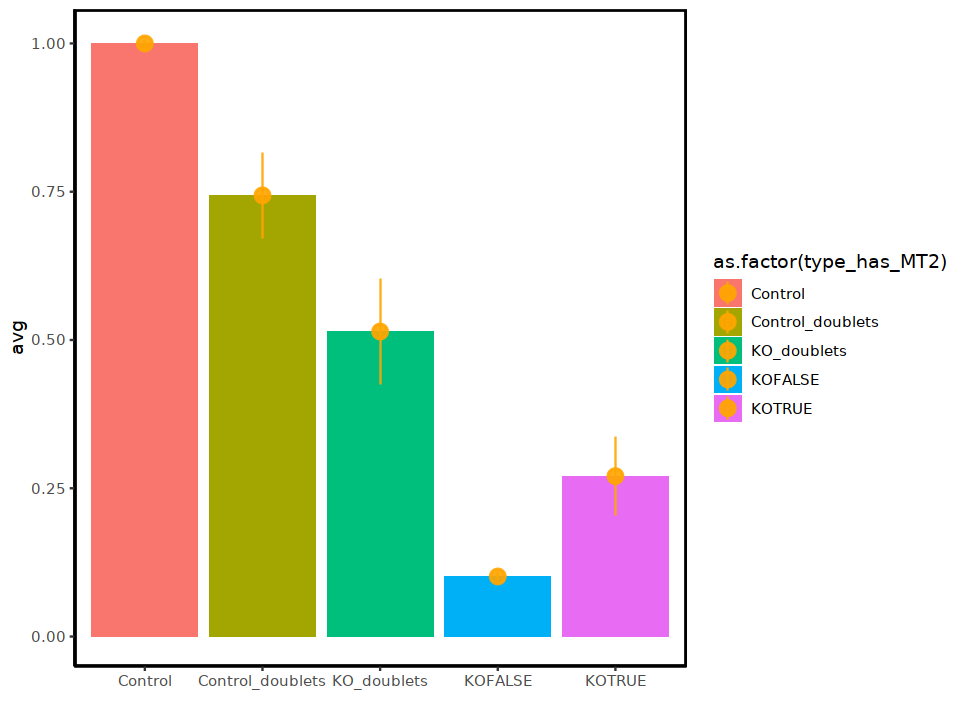

In [150]:
ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = avg, fill = as.factor(type_has_MT2))) + 
geom_col()+
#geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), width=.2,position=position_dodge(.9)) +
#geom_pointrange(aes(x=nr_mutation, y=avg, ymin=avg-sd, ymax=avg+sd), colour="orange", alpha=0.9, size=1.3)+
geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))


In [151]:
dim(all.exp2.doublets.df)
all.exp2.doublets.df_sample1 <- all.exp2.doublets.df

[1] 34060     6

## Direct Capture seq sample 2

### remove TSO

In [152]:
output_dir = './tmp/test'
input_dir = '../Direct_perturb_seq/sgRNAcs1/'
fba_input_dir = '/lustre1/project/stg_00064/projects/cropseq/267genes/develop/public_data/Direct_perturb_seq/feature_barcoding_analysis/sgRNAcs1/'

[1] "MT mutation table"

   A    C D(1) D(2) D(3) D(4) D(5)    G I(1) I(2) I(3)    T 
  47    7   20   21   14    5    3    4   80   45    2   20 
[1] "MT mutation type"

  D   I   S 
 63 127  78 
[1] "MT mutation structure"

gRNA Rest  TSO 
 101   48  119 


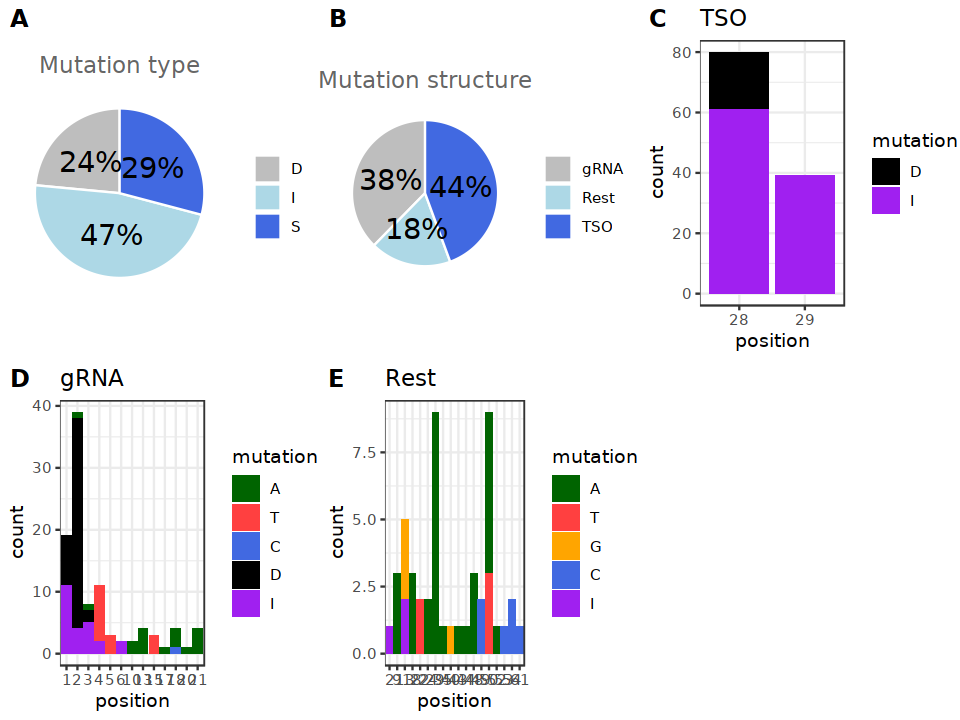

In [153]:
MT <- plot_MT_pattern(input_dir, output_dir)
MT2 <- MT
MT2[which(MT2$structure == 'TSO'), 'position'] <- MT2[which(MT2$structure == 'TSO'), 'position']-30
MT2[which(MT2$structure == 'gRNA'), 'position'] <- MT2[which(MT2$structure == 'gRNA'), 'position'] - 1
MT2[which(MT2$structure == 'Rest'),'position'] <- MT2[which(MT2$structure == 'Rest'),'position']+20

MT2 <- MT2[-which(MT2$position %in% c(-1, -2,0) & MT2$mutation2 %in% c('I','D')),]
######### Needs to be put before factor(MT2$position) otherwise will change the dedup
MT2$dedup <- paste0(MT2$`gene name`, MT2$structure, MT2$`structure length`, MT2$position, MT2$mutation)
tmp <- MT2 %>% group_by(`variant number`) %>% summarise(mutations = list(dedup))
MT2_nodedup <- MT2
MT2 <- MT2[which(!MT2$`variant number` %in% tmp$`variant number`[duplicated(tmp$mutations)]),]
rm(tmp)
#########



In [154]:
#dim(MT2) # presumed real mutant sgRNAs after removal of TSO artifacts without dedup
MT2_list_nodedup <- unique(MT2_nodedup$`variant number`)
length(MT2_list_nodedup)

[1] 121

In [155]:
cells_gRNA_file <- paste0(input_dir, '/cells.gRNA.txt')
n_col = max(count.fields(cells_gRNA_file, sep = "\t"))
cells.gRNA <- read.table(cells_gRNA_file, 
                     header = FALSE, fill = TRUE, stringsAsFactors = FALSE,col.names =1:n_col)

colnames(cells.gRNA)[1:7]= c('cb','feature_order','target','WT','num_UMI_WT', 'MT','num_UMI_MT')
cells.gRNA$cb <- paste0(cells.gRNA$cb,'-1')
cells.gRNA.ori <- cells.gRNA

In [156]:
cells.gRNA <- cells.gRNA.ori
cells.gRNA.WTcounts <- cells.gRNA[,1:5]
for(i in seq(6,n_col-2,2)){
    MT.df <- cells.gRNA[,i:(i+1)]
    colnames(MT.df) <- c('MT','num_UMI_MT')
    MT.notInlist <- MT.df[!MT.df$MT %in% MT2_list_nodedup,]
    index <- !MT.df$MT %in% MT2_list_nodedup
    MT.notInlist$num_UMI_MT[is.na(MT.notInlist$num_UMI_MT)] <- 0
    cells.gRNA.WTcounts$num_UMI_WT[index] <- cells.gRNA.WTcounts$num_UMI_WT[index] + MT.notInlist$num_UMI_MT
    cells.gRNA[index,i:(i+1)] <- NA # make MT not in list as NA
}
cells.gRNA[,1:5] <- cells.gRNA.WTcounts
for(i in seq(1, nrow(cells.gRNA))){
    num_MT <- (sum(!is.na(cells.gRNA[i,])) - 5)/2 #updated number of gRNA
    if(cells.gRNA[i,5] > 0){
        cells.gRNA$feature_order[i] <- num_MT + 1
    }else{
        cells.gRNA$feature_order[i] <- num_MT
    }
}
# now feature order is no longer accumulated 
cells.num_features <- cells.gRNA %>% group_by(cb) %>% summarise(num_features = sum(feature_order))
#cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(is_MT))
cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(contain_MT, is_MT))

# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


In [157]:
table(cells.num_features$num_features)
sum(table(cells.num_features$num_features))


   1    2    3    4    5    6    8 
5135 2089  604  108   20    7    1 

[1] 7964

In [158]:
sum(cells.num_features$num_features) # cells (actual cells, count multiplets multiple times)
tmp <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0))
# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA
sum(cells.gRNA[which(cells.gRNA$num_UMI_WT > 0),'feature_order']-1) + sum(cells.gRNA[which(cells.gRNA$num_UMI_WT == 0),'feature_order'])
# cells with mutations (multiplets count as multiple)

[1] 11707

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


[1] 2837

Rows: 8725 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


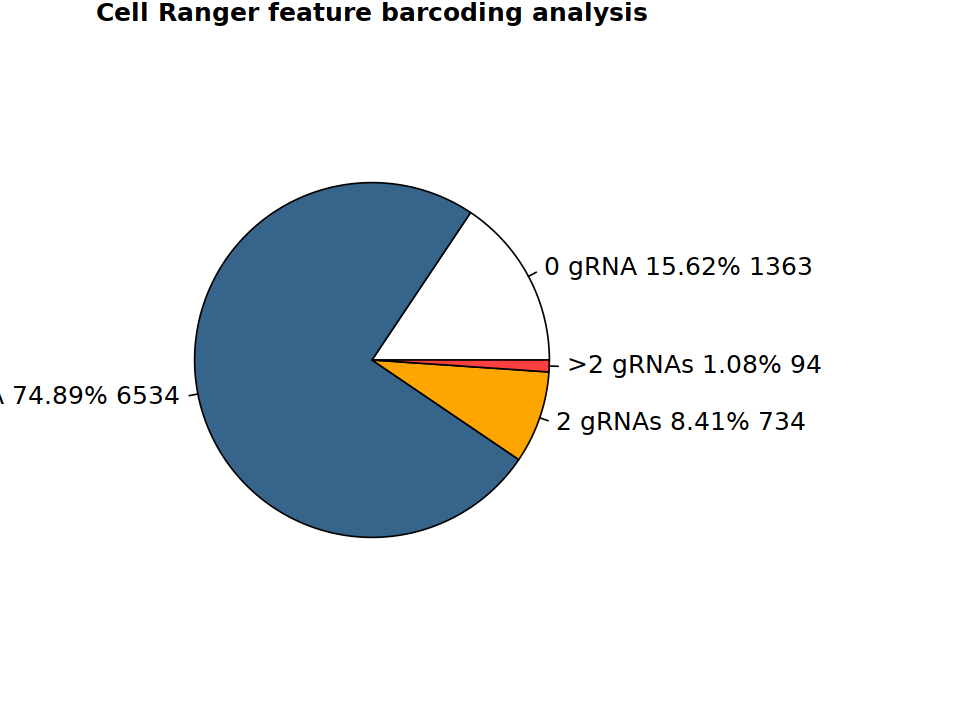

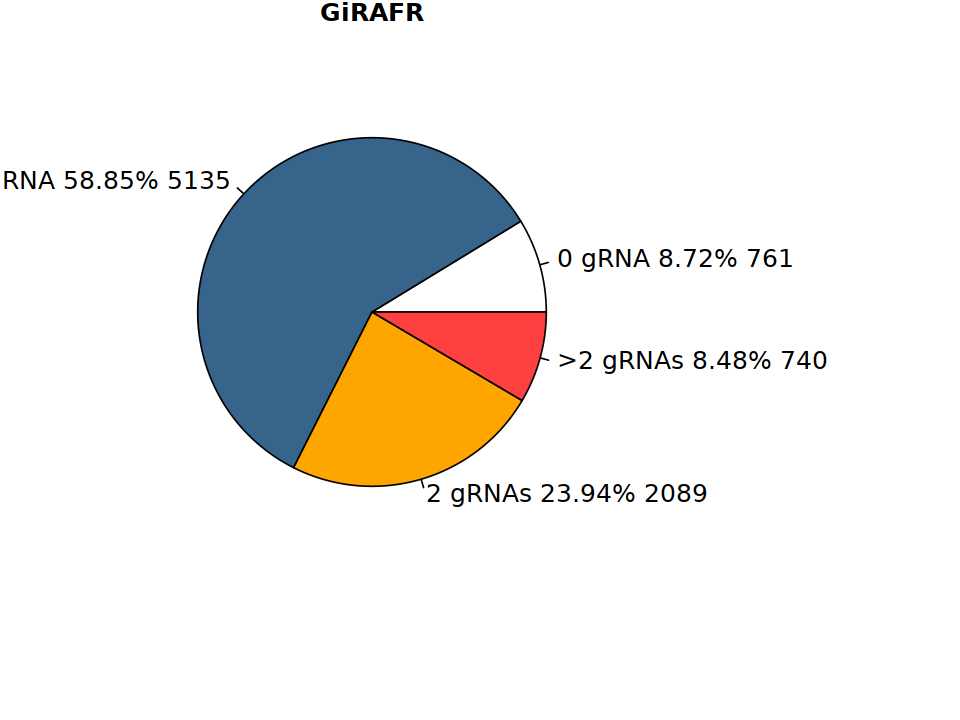

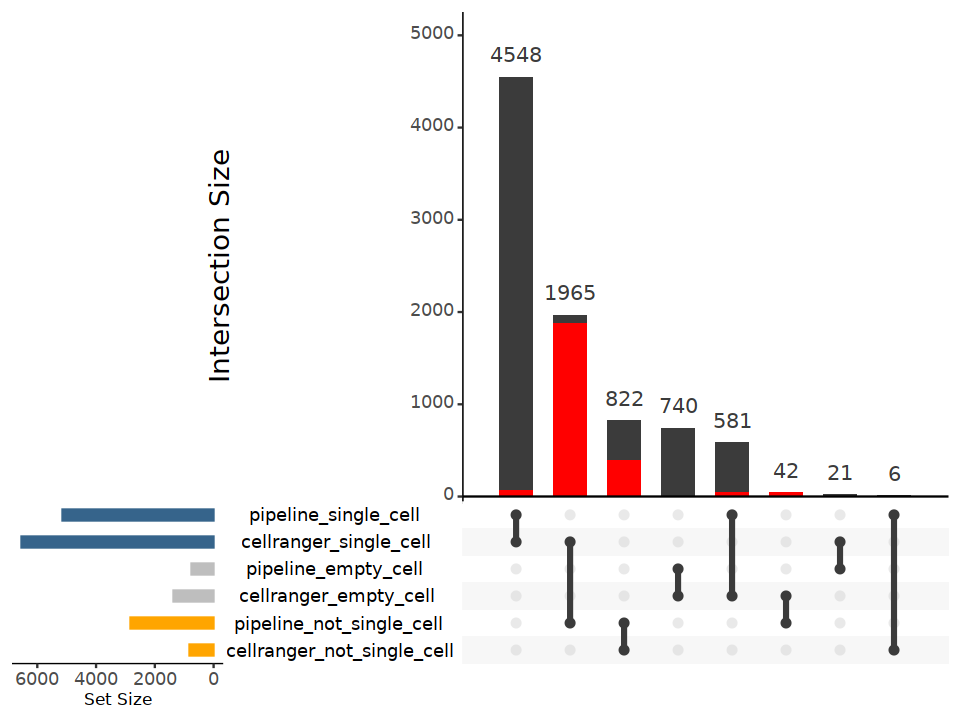

In [159]:
protospacer_file <- paste0(fba_input_dir, '/outs/crispr_analysis/protospacer_calls_per_cell.csv')
barcodes_file <- paste0(fba_input_dir, '/outs/filtered_feature_bc_matrix/barcodes.tsv.gz')
protospacer_calls_per_cell <-read.csv(protospacer_file, stringsAsFactors = FALSE)
cellranger_barcode <- read_csv(barcodes_file, col_names = FALSE)


pipeline_NotEmpty <- cells.num_features$cb
pipeline_Single <- cells.num_features$cb[which(cells.num_features$num_features == 1)]
par(mar = c(1,1,1,10))
slices1 <- c(nrow(cellranger_barcode) - sum(table(protospacer_calls_per_cell$num_features)),
        as.vector(table(protospacer_calls_per_cell$num_features)[1]),
        as.vector(table(protospacer_calls_per_cell$num_features)[2]),
        sum(table(protospacer_calls_per_cell$num_features)[-(1:2)]))
lbls1 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct1 <- round(slices1/sum(slices1)*100, digit =2 )
lbls1 <- paste(lbls1, pct1) # add percents to labels
lbls1 <- paste(lbls1,"%",sep="") # ad % to labels
lbls1 <- paste(lbls1, slices1, sep =' ')
pie(slices1, labels = lbls1, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"), 
    main = 'Cell Ranger feature barcoding analysis')

par(mar = c(5,1,1,10))
slices2 <- c(nrow(cellranger_barcode) - sum(table(cells.num_features$num_features)),
        as.vector(table(cells.num_features$num_features)[1]),
        as.vector(table(cells.num_features$num_features)[2]),
        sum(table(cells.num_features$num_features)[-(1:2)]))
lbls2 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct2 <- round(slices2/sum(slices2)*100, digit = 2)
lbls2 <- paste(lbls2, pct2) # add percents to labels
lbls2 <- paste(lbls2,"%",sep="") # ad % to labels
lbls2 <- paste(lbls2, slices2, sep =' ')
pie(slices2, labels = lbls2, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"),
   main = 'GiRAFR')

all_barcodes <- as.data.frame(cellranger_barcode)
all_barcodes$pipeline_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 1, 0)
all_barcodes$pipeline_empty_cell <- ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 0, 1)
all_barcodes$pipeline_not_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 0, 
                                            ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 1, 0))

all_barcodes$cellranger_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 1, 0)
all_barcodes$cellranger_empty_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 0, 1)
all_barcodes$cellranger_not_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 0, 
                                            ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 1, 0))
all_barcodes <- merge(all_barcodes, cells.has_MT, by.x = 'X1', by.y = 'cb', all.x = TRUE)



Myfunc <- function(row) {data <- (row["has_MT"] == TRUE)}
p <- upset(data = all_barcodes, 
      queries = list(list(query = Myfunc, color = "red", active = T)),
      sets = c('cellranger_not_single_cell','pipeline_not_single_cell',
           'cellranger_empty_cell','pipeline_empty_cell',
           'cellranger_single_cell','pipeline_single_cell'), order.by = "freq",keep.order = TRUE,sets.bar.color=c("orange","orange","grey","grey","steelblue4","steelblue4"), 
      point.size =2.5,line.size = 1.3,text.scale = c(2, 1.5, 1.2, 1.5, 1.5, 2))

p


In [160]:
table(all_barcodes[which(all_barcodes$cellranger_empty_cell == 1),'has_MT'])


FALSE  TRUE 
  539    84 

In [161]:
table(all_barcodes$has_MT)


FALSE  TRUE 
 5547  2417 

### Analysis impact of mutant gRNA and doublets

In [162]:
input_dir

[1] "../Direct_perturb_seq/sgRNAcs1/"

In [163]:
cells.gRNA.single.MT <- read.table(paste0(input_dir, 'cells.gRNA.single.MT.txt'), stringsAsFactors = FALSE)
cells.gRNA.single.MT$target <- sapply(strsplit(cells.gRNA.single.MT$V3,"_"), `[`, 1)
cells.gRNA.single.MT[grepl('NegCtrl',cells.gRNA.single.MT$target),]$target <- 'Control'
cells.gRNA.single.MT$is_WT <- !grepl(pattern = 'variant',cells.gRNA.single.MT$V3)
#table(cells.gRNA.single.MT$is_WT)
cells.gRNA.single.MT$cb = paste0(cells.gRNA.single.MT$V1, '-1')

In [164]:
diff_cb <- pipeline_Single[!pipeline_Single %in% cells.gRNA.single.MT$cb]

In [165]:
length(diff_cb)

[1] 3554

pipeline_Single

In [166]:
all.matrix <- Read10X(paste0(fba_input_dir,'/outs/filtered_feature_bc_matrix/'))
expression.seurat.ori = CreateSeuratObject(counts = all.matrix$`Gene Expression`)
expression.seurat <- subset(expression.seurat.ori, cells = pipeline_Single)

expression.seurat <- NormalizeData(object = expression.seurat, normalization.method = "LogNormalize", scale.factor = 10000)
rownames(cells.gRNA.single.MT) <- cells.gRNA.single.MT$cb
expression.seurat@meta.data$KO <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'target']
expression.seurat@meta.data$is_WT <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'is_WT']
expression.seurat@meta.data$mutation <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'V5']
expression.seurat@meta.data$cb <- rownames(expression.seurat@meta.data)

10X data contains more than one type and is being returned as a list containing matrices of each type.



New single cells after removal of TSO shown as NA

In [167]:
sum(is.na(expression.seurat@meta.data$KO)) 
# should be same as length(diff_cb) 

[1] 3554

In [168]:
rownames(cells.has_MT) <- cells.has_MT$cb
expression.seurat@meta.data$has_MT <- cells.has_MT[rownames(expression.seurat@meta.data), ]$has_MT

Warning message:
“Setting row names on a tibble is deprecated.”


In [169]:
diff_cb_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% diff_cb),]
rownames(diff_cb_gRNA) <- diff_cb_gRNA$cb

In [170]:
# replace KO NA into target
expression.seurat@meta.data$KO[which(expression.seurat@meta.data$cb %in% diff_cb)] <- 
sapply(strsplit(diff_cb_gRNA[rownames(expression.seurat@meta.data[which(expression.seurat@meta.data$cb %in% diff_cb),]), 'target'], '_'), `[`, 1)

In [171]:
table(expression.seurat@meta.data$is_WT, expression.seurat@meta.data$has_MT)
# has some discrepancy 

       
        FALSE TRUE
  FALSE  1473  106
  TRUE      2    0

In [172]:
#expression.seurat@meta.data[which(expression.seurat@meta.data$is_WT == FALSE & expression.seurat@meta.data$has_MT == FALSE),]

In [173]:
expression.seurat$KO[grepl('NegCtrl', expression.seurat$KO)] <- 'Control'
expression.seurat$KO[which(expression.seurat$KO == 'SRPR')] <- 'SRPRA'
expression.seurat$KO[which(expression.seurat$KO == 'ATP5B')] <- 'ATP5F1B'

In [174]:
unique(expression.seurat$KO)

[1] "TMEM167A" "Control"  "TTI1"     "SRPRA"    "QARS"     "OST4"    
 [7] "SEC61G"   "ATP5F1B"  "CARS"     "SRP68"    "SRP72"    "TTI2"    
[13] "UFM1"     "EIF2B2"   "SRPRB"    "DAD1"     "SCYL1"    "TMED10"  
[19] "EIF2B3"   "TELO2"    "MRPL39"   "YIPF5"    "TMED2"    "DDRGK1"  
[25] "TIMM23"   "HARS"     "SEC61A1"  "EIF2B4"   "IER3IP1"  "DDOST"   
[31] "UFL1"

In [175]:
targets <- unique(expression.seurat@meta.data$KO)
targets <- targets[targets!='Control']
all.exp2.df <- data.frame()
CTRL_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == 'Control'),])
for(gene in targets){
        KO_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == gene),])
        tmp.df <- rbind(data.frame(expression = expression.seurat@assays$RNA@data[gene, KO_cells], type = 'KO'),
            data.frame(expression = expression.seurat@assays$RNA@data[gene, CTRL_cells], type = 'Control'))

        tmp.df$target = gene
        tmp.df$cb = rownames(tmp.df)
        all.exp2.df <- rbind(all.exp2.df, tmp.df)
}

Target gene expression in Control

In [176]:
avg.exp.control <- all.exp2.df[which(all.exp2.df$type == 'Control'),] %>% group_by(target) %>% summarise(avg = mean(expression))
avg.exp.control <- as.data.frame(avg.exp.control)
rownames(avg.exp.control) <- avg.exp.control$target

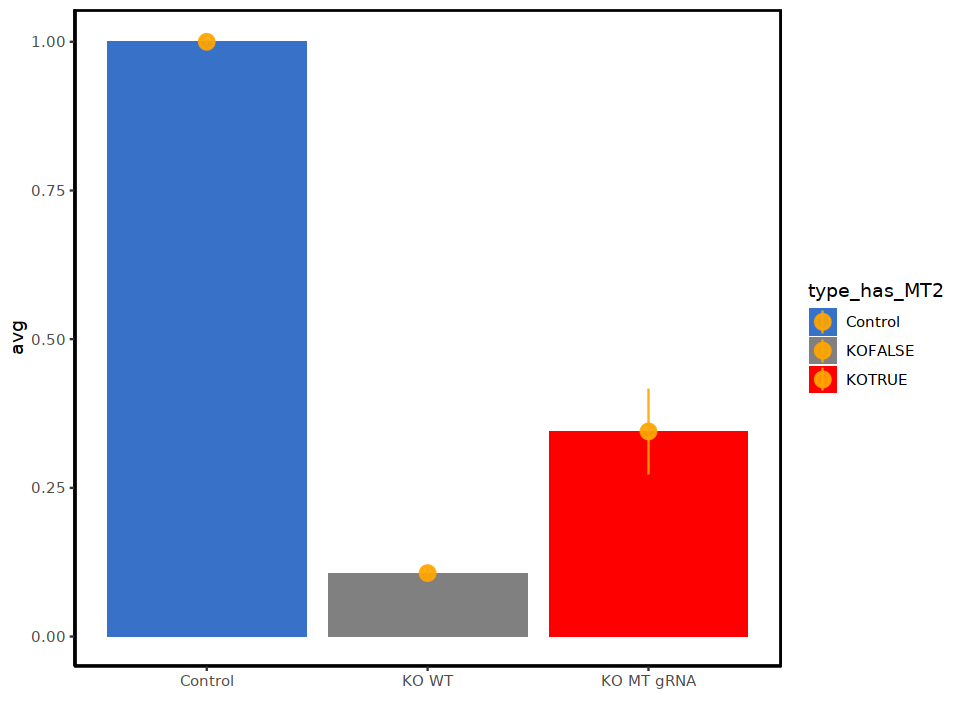

In [177]:
#all.exp2.MT.df <- merge(all.exp2.df, cells.gRNA.single.MT[,c(4,5,8,9)], by = 'cb')
all.exp2.MT.df <- merge(all.exp2.df, expression.seurat@meta.data[,c(4,6,7,8)], by = 'cb')
all.exp2.MT.df$type_has_MT <- paste0(all.exp2.MT.df$type, all.exp2.MT.df$has_MT)

all.exp2.MT.df$type_has_MT2 <- all.exp2.MT.df$type_has_MT
all.exp2.MT.df[which(all.exp2.MT.df$type_has_MT == 'ControlFALSE' |
    all.exp2.MT.df$type_has_MT == 'ControlNA' |
    all.exp2.MT.df$type_has_MT == 'ControlTRUE'),'type_has_MT2'] <- 'Control'


all.exp2.MT.df$expression_norm <- all.exp2.MT.df$expression/avg.exp.control[all.exp2.MT.df$target,'avg']

# high_exp_targets <- avg.exp.control$target[order(avg.exp.control$avg, decreasing = T)]
# tmp.df <- all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets), c('tmp','expression_norm')]

tmp.df <- all.exp2.MT.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm),
                                                 sem = sd(expression_norm)/sqrt(n))

p1 <- ggplot(tmp.df, aes(x = type_has_MT2, y = avg, fill = type_has_MT2)) + geom_col()+
        geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
        theme_classic()+
        xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
        scale_fill_manual(breaks = c("Control", "KOFALSE","KOTRUE"),
                          values=c("#3771c8", "#808080",'#ff0000'))+
        scale_x_discrete(limits = c("Control", "KOFALSE", "KOTRUE"), labels=c("Control" = "Control", "KOFALSE" = "KO WT", "KOTRUE" = "KO MT gRNA"))

print(p1)

### Analysis impact of doublets/multiplets

In [178]:
new_doublets <- all_barcodes[which(all_barcodes$pipeline_not_single_cell == 1 & all_barcodes$cellranger_single_cell == 1), 'X1']
length(new_doublets) 
# pipeline identified doubets, cellranger as single

[1] 1965

For new doublets, following scenarios:
1. doublets with the mutant gRNA and wildtype gRNA targeting the same gene, 
2. doublets with the mutant gRNA and wildtype gRNA targeting the different gene
3. doublets with two wildtype gRNA targeting the same gene
4. doublets with two wildtype gRNA targeting different gene
5. doublets with two mutant gRNAs targeting different gene

In [179]:
new_doublets_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% new_doublets),] # the mutant gRNA and wildtype gRNA targeting the same gene,

In [180]:
new_doublets_type1 <- new_doublets_gRNA[which(new_doublets_gRNA$feature_order >= 2),]

In [181]:
new_doublets_gRNA2 <- as.data.frame(new_doublets_gRNA[which(new_doublets_gRNA$feature_order < 2),] %>% group_by(cb) %>% summarise(target = list(target), UMIs = list(num_UMI_WT)))


In [182]:
new_doublets_gRNA2$KO <- lapply(new_doublets_gRNA2$target, function(x) sapply(strsplit(x, '_'), `[`, 1))

In [183]:
new_doublets_gRNA2$KO <- lapply(new_doublets_gRNA2$KO, function(x) ifelse(grepl('NegCtrl',x),'Control',x))

In [184]:
if1 <- lapply(new_doublets_gRNA2$KO, function(x) x[1]== x[2])
if2 <- lapply(new_doublets_gRNA2$UMIs, function(x) x[1]>0 & x[2] > 0)
              
new_doublets_type_unknown <- c()
new_doublets_type2 <- c()
new_doublets_type3 <- c()
new_doublets_type4 <- c()
new_doublets_type5 <- c()
for(i in 1:nrow(new_doublets_gRNA2)){
    if(is.na(if1[i]) | is.na(if2[i])){
        new_doublets_type_unknown <- rbind(new_doublets_type_unknown, new_doublets_gRNA2[i,])
    }else{
    if(if1[i] == TRUE & if2[i] == TRUE){ # two wiltype gRNA targeting the same target
        new_doublets_type3 <- rbind(new_doublets_type3, new_doublets_gRNA2[i,])
    }else if(if1[i] == TRUE & if2[i] == FALSE){ #  mutant gRNA and wildtype gRNA or two muatnt targeting the same gene
        new_doublets_type2 <- rbind(new_doublets_type2, new_doublets_gRNA2[i,])
    }else if(if1[i] == FALSE & if2[i] == TRUE){# two wildtype gRNA targeting different gene
        new_doublets_type4 <- rbind(new_doublets_type4, new_doublets_gRNA2[i,]) 
    }else if(if1[i] == FALSE & if2[i] == FALSE){ # mutant gRNA and wildtype gRNA or two muatnt  different gene 
        new_doublets_type5 <- rbind(new_doublets_type5, new_doublets_gRNA2[i,])
    }else{
        print('unknown error')
    }
    }
}

In [185]:
nrow(new_doublets_type1)
nrow(new_doublets_type2)
nrow(new_doublets_type3)
nrow(new_doublets_type4)
nrow(new_doublets_type5)
nrow(new_doublets_type_unknown)

[1] 1865

NULL

[1] 8

[1] 83

[1] 12

[1] 47

In [186]:
new_doublets_subset <- rbind(new_doublets_type4, new_doublets_type5)$cb
length(new_doublets_subset)

[1] 95

In [187]:
seurat.object.doublets <- subset(expression.seurat.ori, cells = new_doublets_subset)
seurat.object.doublets <- NormalizeData(object = seurat.object.doublets, normalization.method = "LogNormalize", scale.factor = 10000)
seurat.object.doublets

An object of class Seurat 
33538 features across 95 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data

In [188]:
head(rbind(new_doublets_type4, new_doublets_type5))
table(cells.num_features[which(cells.num_features$cb %in% new_doublets_subset),'num_features'])


,cb,target,UMIs,KO
,<chr>,<list>,<list>,<list>
1,AAACGAATCTACCACC-1,"NegCtrl2_gRNA1_gene, EIF2B3_gRNA1_gene","14, 424","Control, EIF2B3"
3,AACGGGACATGCCGGT-1,"NegCtrl2_gRNA1_gene, SRP68_gRNA1_gene","6, 202","Control, SRP68"
7,AAGGAATAGCTGAAAT-1,"NegCtrl2_gRNA1_gene, QARS_gRNA1_gene","10, 207","Control, QARS"
9,ACAGAAAGTAGGGAGG-1,"NegCtrl3_gRNA1_gene, SEC61G_gRNA1_gene , ATP5B_gRNA1_gene","34, 23, 56","Control, SEC61G , ATP5B"
10,ACATCCCTCGAGAATA-1,"TIMM23_gRNA1_gene, HARS_gRNA1_gene","191, 36","TIMM23, HARS"
13,ACCATTTTCATGCATG-1,"NegCtrl2_gRNA1_gene, OST4_gRNA1_gene","11, 1248","Control, OST4"


num_features
 2  3  4 
91  3  1 

In [189]:
protospacer.df <- read.csv(protospacer_file)
rownames(protospacer.df) <- protospacer.df$cell_barcode

In [190]:
seurat.object.doublets@meta.data <- cbind(seurat.object.doublets@meta.data, protospacer.df[colnames(seurat.object.doublets),])
seurat.object.doublets$KO <- sapply(strsplit(seurat.object.doublets@meta.data$feature_call, '_'), `[`, 1)

In [191]:
seurat.object.doublets$KO[grepl('NegCtrl', seurat.object.doublets$KO)] <- 'Control'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'SRPR')] <- 'SRPRA'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'ATP5B')] <- 'ATP5F1B'

In [192]:
doublets_targets <- unique(seurat.object.doublets$KO)[-which(unique(seurat.object.doublets$KO) == 'Control')] # remove 'neg'
doublets.exp.df <- data.frame()
CTRL_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == 'Control'),])

for(gene in doublets_targets){
    KO_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == gene),])
   tmp.df <- rbind(data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, KO_cells], type = 'KO_doublets'),
                    data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, CTRL_cells], type = 'Control_doublets'))
   tmp.df$target = gene
   tmp.df$cb = c(KO_cells, CTRL_cells)
   doublets.exp.df <- rbind(doublets.exp.df, tmp.df)
}

In [193]:
doublets.exp.df$type_has_MT2 <- doublets.exp.df$type

In [194]:
doublets.exp.df$expression_norm <- doublets.exp.df$expression/avg.exp.control[doublets.exp.df$target,'avg']

In [195]:
all.exp2.doublets.df <- rbind(doublets.exp.df, all.exp2.MT.df[, c('expression', 'type', 'target', 'cb', 'type_has_MT2', 'expression_norm')])

In [196]:
table(all.exp2.doublets.df$type_has_MT)


         Control Control_doublets      KO_doublets          KOFALSE 
           53130              216               87             3263 
          KOTRUE 
             101 

In [197]:
tmp.df <- all.exp2.doublets.df
tmp.df <- tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
tmp.df

type_has_MT2,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,53130,1.0000000,1.0813535,0.004691350
Control_doublets,216,1.0088522,0.9577023,0.065163386
KOFALSE,3263,0.1066225,0.4451410,0.007792719
KOTRUE,101,0.3448739,0.7338523,0.073021032
KO_doublets,87,0.3364880,0.5620455,0.060257601


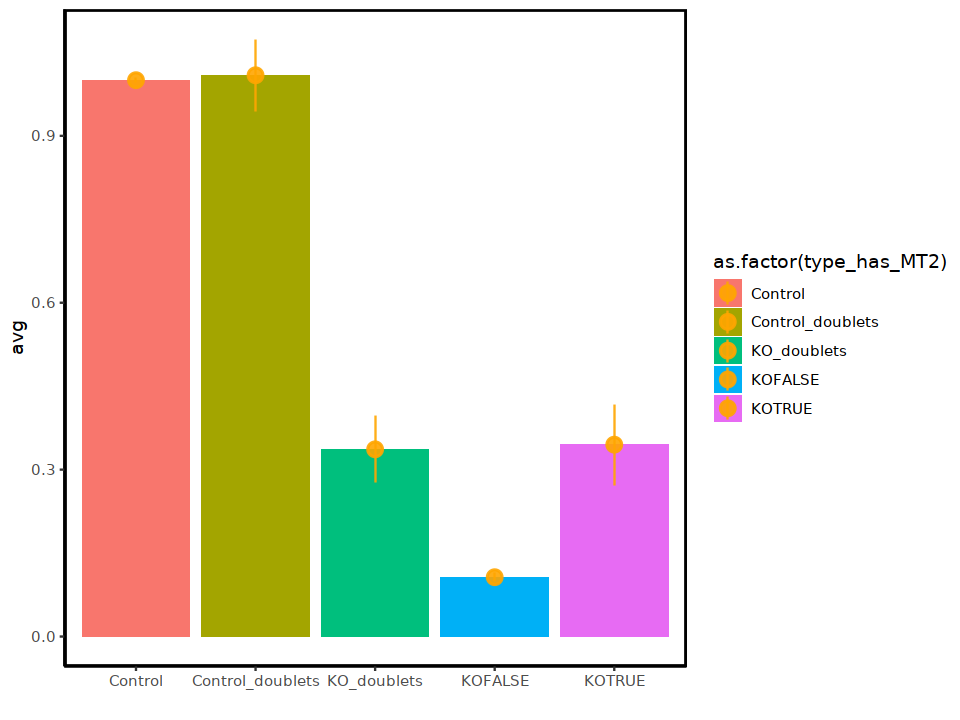

In [198]:
ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = avg, fill = as.factor(type_has_MT2))) + 
geom_col()+
#geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), width=.2,position=position_dodge(.9)) +
#geom_pointrange(aes(x=nr_mutation, y=avg, ymin=avg-sd, ymax=avg+sd), colour="orange", alpha=0.9, size=1.3)+
geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))


In [199]:
dim(all.exp2.doublets.df)
all.exp2.doublets.df_sample2 <- all.exp2.doublets.df

[1] 56797     6

## Combine two samples

In [200]:
dim(all.exp2.doublets.df_sample1)
dim(all.exp2.doublets.df_sample2)

[1] 34060     6

[1] 56797     6

In [201]:
all.exp2.doublets.df_combine <- rbind(all.exp2.doublets.df_sample1, all.exp2.doublets.df_sample2)

type_has_MT2,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,82980,1.0000000,1.1615512,0.004032289
Control_doublets,360,0.9028451,0.9336778,0.049209140
KOFALSE,7120,0.1037151,0.4552925,0.005395734
KOTRUE,214,0.3055905,0.7167726,0.048997564
KO_doublets,183,0.4297477,0.7466319,0.055192615


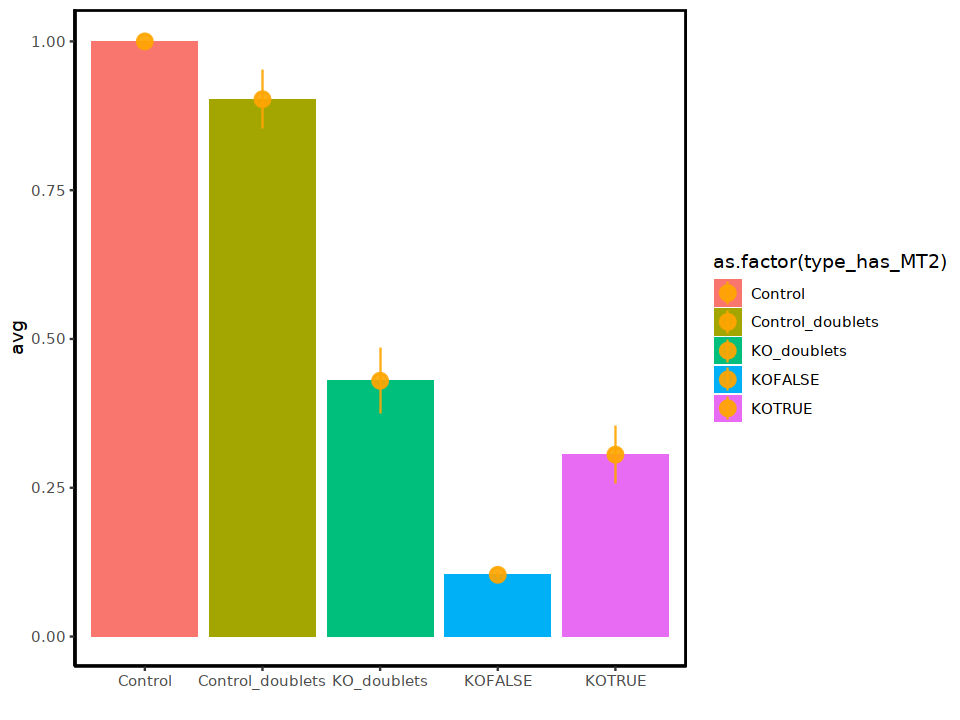

In [202]:
#pdf('Direct_Capture_gRNA_target_exp.pdf')
tmp.df <- all.exp2.doublets.df_combine
tmp.df <- tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
tmp.df

ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = avg, fill = as.factor(type_has_MT2))) + 
geom_col()+
#geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), width=.2,position=position_dodge(.9)) +
#geom_pointrange(aes(x=nr_mutation, y=avg, ymin=avg-sd, ymax=avg+sd), colour="orange", alpha=0.9, size=1.3)+
geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))
#dev.off()

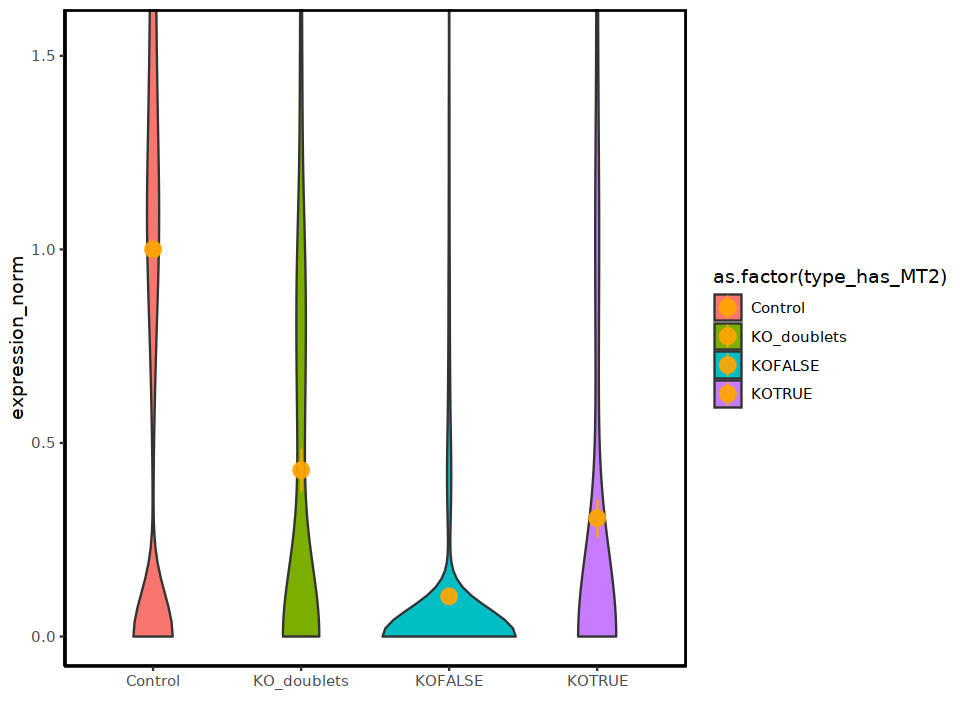

In [209]:
#pdf('Direct_Capture_gRNA_target_exp_violin.pdf')

tmp.df <- all.exp2.doublets.df_combine
tmp.df <- tmp.df[which(tmp.df$type_has_MT2 != 'Control_doublets'),]
tmp <-  tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), 
                                                 sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
ylims <- tmp.df %>%
  group_by(type_has_MT2) %>%
  summarise(Q1 = quantile(expression_norm, 1/4), Q3 = quantile(expression_norm, 3/4)) %>%
  ungroup() %>%
  #get lowest Q1 and highest Q3
  summarise(lowQ1 = min(Q1), highQ3 = max(Q3))

ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = expression_norm, fill = as.factor(type_has_MT2))) + 
geom_violin()+
coord_cartesian(ylim = as.numeric(ylims)*1)+ # zoom in
geom_pointrange(data = tmp, aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem),
                colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))
#dev.off()

# Replogle Cell

## Sample 1

### Remove TSO

In [205]:
output_dir = './tmp/test'
input_dir = '../Replogle_Cell/Lane_1/new_ref/region_A/fix_threshold/'
fba_input_dir = '/lustre1/project/stg_00064/projects/cropseq/267genes/develop/public_data/Replogle_Cell//feature_barcoding_analysis/regionA'

[1] "MT mutation table"

    A     C  D(1) D(10) D(11) D(12) D(13)  D(2)  D(3)  D(4)  D(5)  D(6)  D(7) 
 1063   647  1539     8     2     6     1   927   604   206    34    16     6 
 D(8)  D(9)     G  I(1)  I(2)  I(3)  I(4)  I(5)  I(8)     T 
    5     3   959  2701  2137   393    17     7     1   927 
[1] "MT mutation type"

   D    I    S 
3357 5256 3596 
[1] "MT mutation structure"

gRNA Rest  TSO 
5657  920 5632 


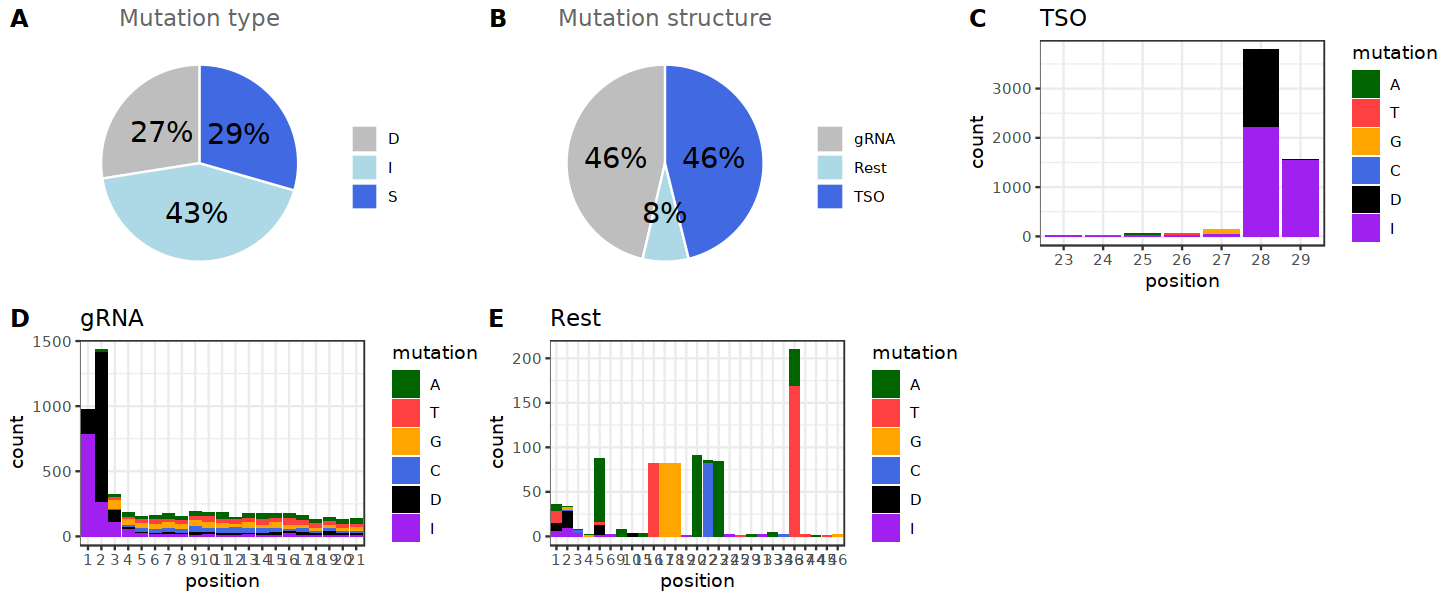

In [206]:

options(repr.plot.width = 12, repr.plot.height = 5)
MT <- plot_MT_pattern(input_dir, output_dir)
MT2 <- MT
MT2[which(MT2$structure == 'TSO'), 'position'] <- MT2[which(MT2$structure == 'TSO'), 'position']-30
MT2[which(MT2$structure == 'gRNA'), 'position'] <- MT2[which(MT2$structure == 'gRNA'), 'position'] - 1
MT2[which(MT2$structure == 'Rest'),'position'] <- MT2[which(MT2$structure == 'Rest'),'position']+20
MT2$mutation2 <- factor(MT2$mutation2, levels = c('A','T','G','C','D','I'))
MT2 <- MT2[-which(MT2$position %in% c(-1, -2,0) & MT2$mutation2 %in% c('I','D')),]
#########
MT2$dedup <- paste0(MT2$`gene name`, MT2$structure, MT2$`structure length`, MT2$position, MT2$mutation)
tmp <- MT2 %>% group_by(`variant number`) %>% summarise(mutations = list(dedup))
MT2_nodedup <- MT2
MT2 <- MT2[which(!MT2$`variant number` %in% tmp$`variant number`[duplicated(tmp$mutations)]),]
rm(tmp)
#########

MT2$position <- factor(MT2$position, levels = seq(-20,55, by =1))

In [207]:
#dim(MT2) # presumed real mutant sgRNAs after removal of TSO artifacts without dedup
MT2_list_nodedup <- unique(MT2_nodedup$`variant number`)
length(MT2_list_nodedup)

[1] 2925

In [208]:
cells_gRNA_file <- paste0(input_dir, '/cells.gRNA.txt')
n_col = max(count.fields(cells_gRNA_file, sep = "\t"))
cells.gRNA <- read.table(cells_gRNA_file, 
                     header = FALSE, fill = TRUE, stringsAsFactors = FALSE,col.names =1:n_col)

colnames(cells.gRNA)[1:7]= c('cb','feature_order','target','WT','num_UMI_WT', 'MT','num_UMI_MT')
cells.gRNA$cb <- paste0(cells.gRNA$cb,'-1')
cells.gRNA.ori <- cells.gRNA

In [209]:
cells.gRNA <- cells.gRNA.ori
cells.gRNA.WTcounts <- cells.gRNA[,1:5]
for(i in seq(6,n_col-2,2)){
    MT.df <- cells.gRNA[,i:(i+1)]
    colnames(MT.df) <- c('MT','num_UMI_MT')
    MT.notInlist <- MT.df[!MT.df$MT %in% MT2_list_nodedup,]
    index <- !MT.df$MT %in% MT2_list_nodedup
    MT.notInlist$num_UMI_MT[is.na(MT.notInlist$num_UMI_MT)] <- 0
    cells.gRNA.WTcounts$num_UMI_WT[index] <- cells.gRNA.WTcounts$num_UMI_WT[index] + MT.notInlist$num_UMI_MT
    cells.gRNA[index,i:(i+1)] <- NA # make MT not in list as NA
}
cells.gRNA[,1:5] <- cells.gRNA.WTcounts
for(i in seq(1, nrow(cells.gRNA))){
    num_MT <- (sum(!is.na(cells.gRNA[i,])) - 5)/2 #updated number of gRNA
    if(cells.gRNA[i,5] > 0){
        cells.gRNA$feature_order[i] <- num_MT + 1
    }else{
        cells.gRNA$feature_order[i] <- num_MT
    }
}
# now feature order is no longer accumulated 
cells.num_features <- cells.gRNA %>% group_by(cb) %>% summarise(num_features = sum(feature_order))
#cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(is_MT))
cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(contain_MT, is_MT))

# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


In [210]:
table(cells.num_features$num_features)
sum(table(cells.num_features$num_features))


   1    2    3    4    5    6    7    8    9   15 
5407 3052 1004  379  137   60   21   13    4    1 

[1] 10078

In [211]:
sum(cells.num_features$num_features) # cells (actual cells, count multiplets multiple times)
tmp <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0))
# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA
sum(cells.gRNA[which(cells.gRNA$num_UMI_WT > 0),'feature_order']-1) + sum(cells.gRNA[which(cells.gRNA$num_UMI_WT == 0),'feature_order'])
# cells with mutations (multiplets count as multiple)

[1] 17386

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


[1] 5643

Rows: 12659 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


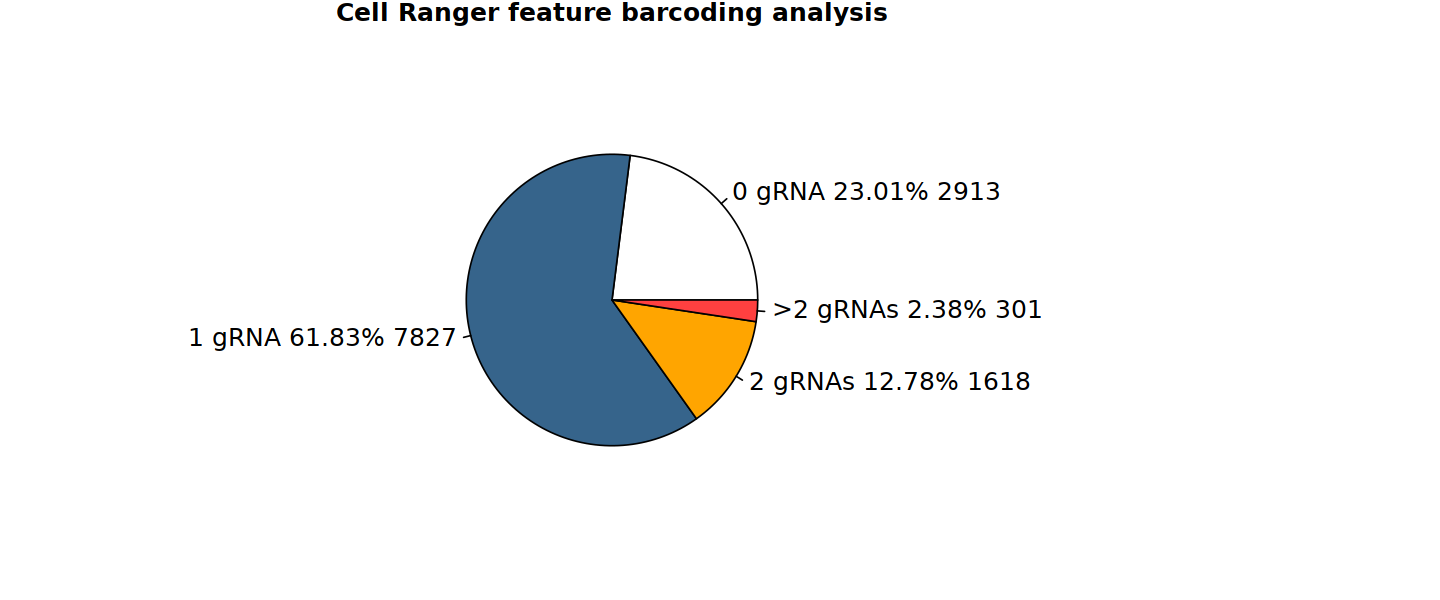

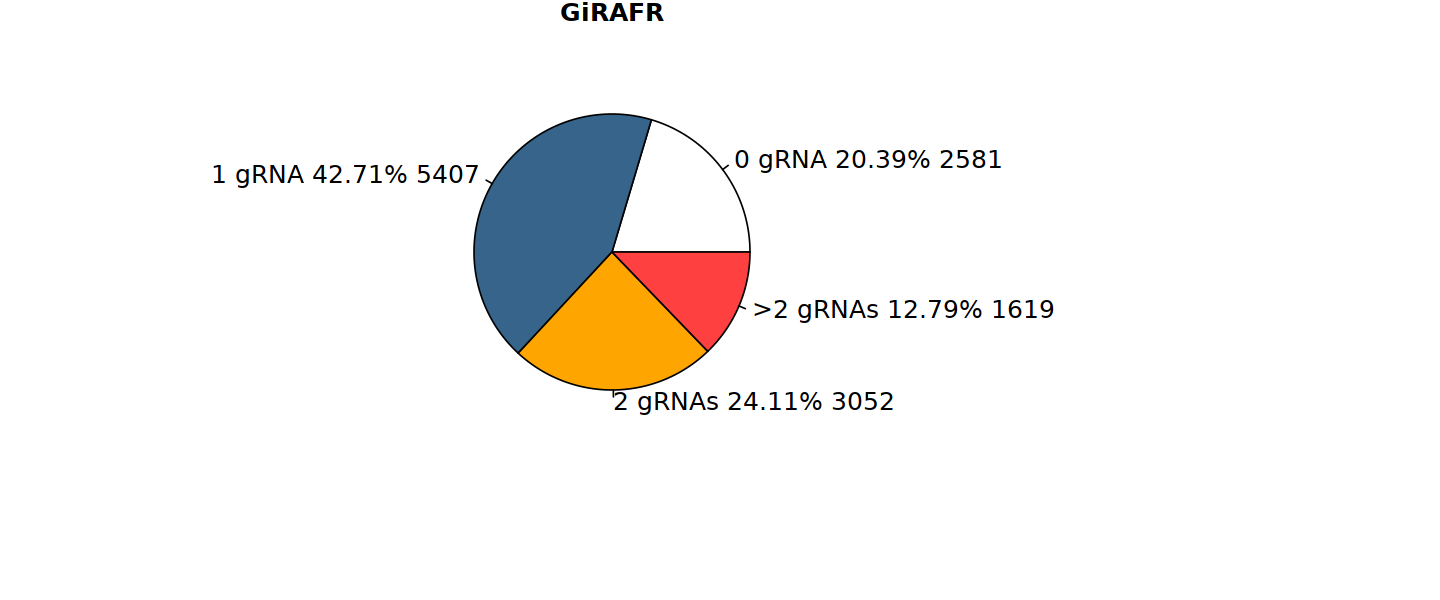

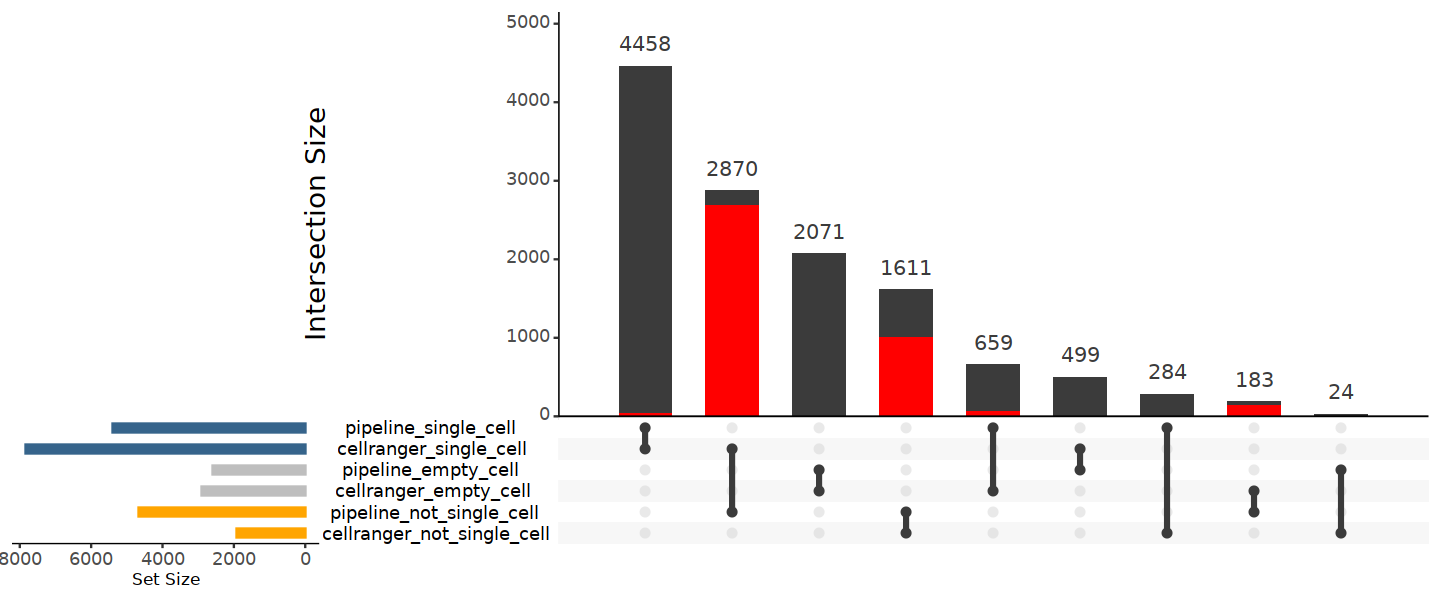

In [212]:
protospacer_file <- paste0(fba_input_dir, '/outs/crispr_analysis/protospacer_calls_per_cell.csv')
barcodes_file <- paste0(fba_input_dir, '/outs/filtered_feature_bc_matrix/barcodes.tsv.gz')
protospacer_calls_per_cell <-read.csv(protospacer_file, stringsAsFactors = FALSE)
cellranger_barcode <- read_csv(barcodes_file, col_names = FALSE)


pipeline_NotEmpty <- cells.num_features$cb
pipeline_Single <- cells.num_features$cb[which(cells.num_features$num_features == 1)]
par(mar = c(1,1,1,10))
slices1 <- c(nrow(cellranger_barcode) - sum(table(protospacer_calls_per_cell$num_features)),
        as.vector(table(protospacer_calls_per_cell$num_features)[1]),
        as.vector(table(protospacer_calls_per_cell$num_features)[2]),
        sum(table(protospacer_calls_per_cell$num_features)[-(1:2)]))
lbls1 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct1 <- round(slices1/sum(slices1)*100, digit =2 )
lbls1 <- paste(lbls1, pct1) # add percents to labels
lbls1 <- paste(lbls1,"%",sep="") # ad % to labels
lbls1 <- paste(lbls1, slices1, sep =' ')
pie(slices1, labels = lbls1, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"), 
    main = 'Cell Ranger feature barcoding analysis')

par(mar = c(5,1,1,10))
slices2 <- c(nrow(cellranger_barcode) - sum(table(cells.num_features$num_features)),
        as.vector(table(cells.num_features$num_features)[1]),
        as.vector(table(cells.num_features$num_features)[2]),
        sum(table(cells.num_features$num_features)[-(1:2)]))
lbls2 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct2 <- round(slices2/sum(slices2)*100, digit = 2)
lbls2 <- paste(lbls2, pct2) # add percents to labels
lbls2 <- paste(lbls2,"%",sep="") # ad % to labels
lbls2 <- paste(lbls2, slices2, sep =' ')
pie(slices2, labels = lbls2, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"),
   main = 'GiRAFR')

all_barcodes <- as.data.frame(cellranger_barcode)
all_barcodes$pipeline_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 1, 0)
all_barcodes$pipeline_empty_cell <- ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 0, 1)
all_barcodes$pipeline_not_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 0, 
                                            ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 1, 0))

all_barcodes$cellranger_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 1, 0)
all_barcodes$cellranger_empty_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 0, 1)
all_barcodes$cellranger_not_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 0, 
                                            ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 1, 0))
all_barcodes <- merge(all_barcodes, cells.has_MT, by.x = 'X1', by.y = 'cb', all.x = TRUE)



Myfunc <- function(row) {data <- (row["has_MT"] == TRUE)}
p <- upset(data = all_barcodes, 
      queries = list(list(query = Myfunc, color = "red", active = T)),
      sets = c('cellranger_not_single_cell','pipeline_not_single_cell',
           'cellranger_empty_cell','pipeline_empty_cell',
           'cellranger_single_cell','pipeline_single_cell'), order.by = "freq",keep.order = TRUE,sets.bar.color=c("orange","orange","grey","grey","steelblue4","steelblue4"), 
      point.size =2.5,line.size = 1.3,text.scale = c(2, 1.5, 1.2, 1.5, 1.5, 2))

p


In [213]:
table(all_barcodes[which(all_barcodes$cellranger_empty_cell == 1),'has_MT'])


FALSE  TRUE 
  643   199 

In [214]:
table(all_barcodes$has_MT)


FALSE  TRUE 
 6138  3927 

### Analysis impact of mutant gRNA and doublets

In [215]:
input_dir

[1] "../Replogle_Cell/Lane_1/new_ref/region_A/fix_threshold/"

In [216]:
cells.gRNA.single.MT <- read.table(paste0(input_dir, 'cells.gRNA.single.MT.txt'), stringsAsFactors = FALSE)
cells.gRNA.single.MT$target <- sapply(strsplit(cells.gRNA.single.MT$V3,"_"), `[`, 2)
cells.gRNA.single.MT[grepl('non-targeting',cells.gRNA.single.MT$target),]$target <- 'Control'
cells.gRNA.single.MT$is_WT <- !grepl(pattern = 'variant',cells.gRNA.single.MT$V3)
#table(cells.gRNA.single.MT$is_WT)
cells.gRNA.single.MT$cb = paste0(cells.gRNA.single.MT$V1, '-1')

In [217]:
diff_cb <- pipeline_Single[!pipeline_Single %in% cells.gRNA.single.MT$cb]

In [218]:
length(diff_cb)

[1] 4372

pipeline_Single

In [219]:
all.matrix <- Read10X(paste0(fba_input_dir,'/outs/filtered_feature_bc_matrix/'))
expression.seurat.ori = CreateSeuratObject(counts = all.matrix$`Gene Expression`)
expression.seurat <- subset(expression.seurat.ori, cells = pipeline_Single)

expression.seurat <- NormalizeData(object = expression.seurat, normalization.method = "LogNormalize", scale.factor = 10000)
rownames(cells.gRNA.single.MT) <- cells.gRNA.single.MT$cb
expression.seurat@meta.data$KO <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'target']
expression.seurat@meta.data$is_WT <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'is_WT']
expression.seurat@meta.data$mutation <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'V5']
expression.seurat@meta.data$cb <- rownames(expression.seurat@meta.data)

10X data contains more than one type and is being returned as a list containing matrices of each type.



New single cells after removal of TSO shown as NA

In [220]:
sum(is.na(expression.seurat@meta.data$KO)) 
# should be same as length(diff_cb) 

[1] 4369

In [221]:
rownames(cells.has_MT) <- cells.has_MT$cb
expression.seurat@meta.data$has_MT <- cells.has_MT[rownames(expression.seurat@meta.data), ]$has_MT

Warning message:
“Setting row names on a tibble is deprecated.”


In [222]:
diff_cb_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% diff_cb),]
rownames(diff_cb_gRNA) <- diff_cb_gRNA$cb

In [223]:
# replace KO NA into target
expression.seurat@meta.data$KO[which(expression.seurat@meta.data$cb %in% diff_cb)] <- 
sapply(strsplit(diff_cb_gRNA[rownames(expression.seurat@meta.data[which(expression.seurat@meta.data$cb %in% diff_cb),]), 'target'], '_'), `[`, 2)

In [224]:
table(expression.seurat@meta.data$is_WT, expression.seurat@meta.data$has_MT)
# has some discrepancy 

       
        FALSE TRUE
  FALSE   912   98
  TRUE     22    0

In [225]:
#expression.seurat@meta.data[which(expression.seurat@meta.data$is_WT == FALSE & expression.seurat@meta.data$has_MT == FALSE),]

In [226]:
expression.seurat$KO[which(expression.seurat$KO == 'non-targeting')] <- 'Control'
expression.seurat$KO[which(expression.seurat$KO == 'GET1')] <- 'WRB'
expression.seurat$KO[which(expression.seurat$KO == 'GET3')] <- 'ASNA1'
expression.seurat$KO[which(expression.seurat$KO == 'MICOS10')] <- 'MINOS1'
expression.seurat$KO[which(expression.seurat$KO == 'PRORP')] <- 'KIAA0391'

In [227]:
#unique(expression.seurat$KO)

In [228]:
targets <- unique(expression.seurat@meta.data$KO)
targets <- targets[targets!='Control']
all.exp2.df <- data.frame()
CTRL_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == 'Control'),])
for(gene in targets){
        KO_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == gene),])
        tmp.df <- rbind(data.frame(expression = expression.seurat@assays$RNA@data[gene, KO_cells], type = 'KO'),
            data.frame(expression = expression.seurat@assays$RNA@data[gene, CTRL_cells], type = 'Control'))

        tmp.df$target = gene
        tmp.df$cb = rownames(tmp.df)
        all.exp2.df <- rbind(all.exp2.df, tmp.df)
}

Target gene expression in Control

In [229]:
avg.exp.control <- all.exp2.df[which(all.exp2.df$type == 'Control'),] %>% group_by(target) %>% summarise(avg = mean(expression))
avg.exp.control <- as.data.frame(avg.exp.control)
rownames(avg.exp.control) <- avg.exp.control$target

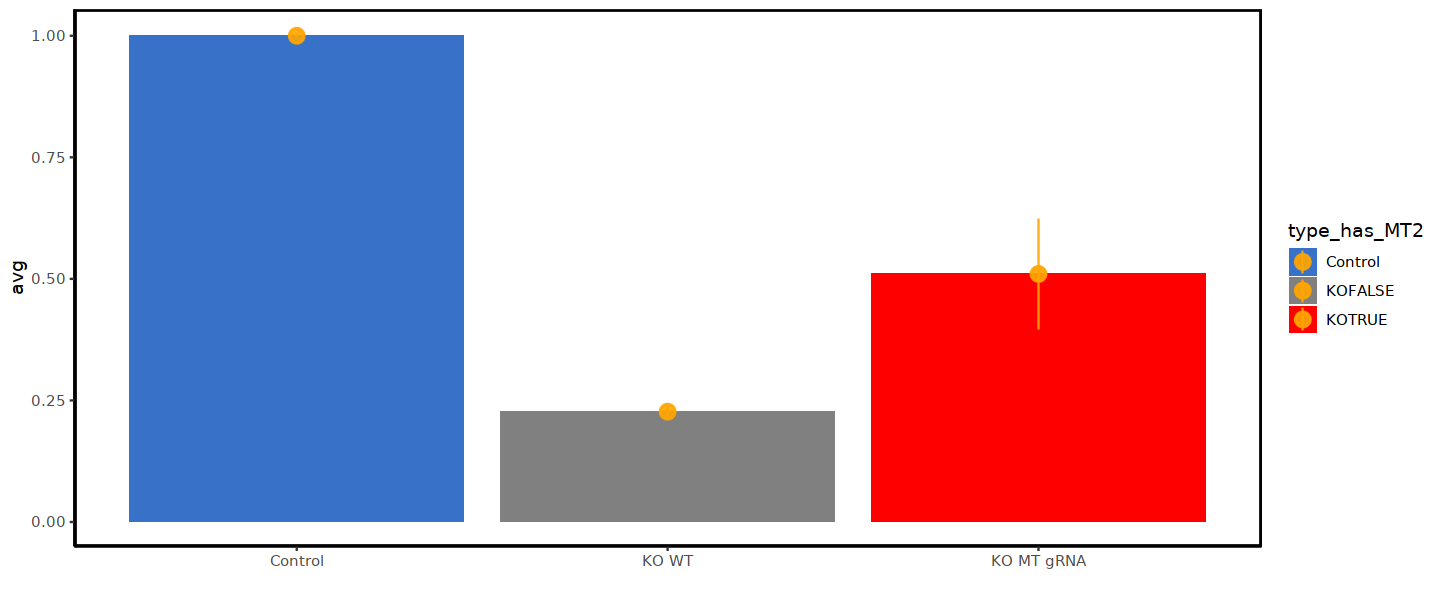

In [230]:
#all.exp2.MT.df <- merge(all.exp2.df, cells.gRNA.single.MT[,c(4,5,8,9)], by = 'cb')
all.exp2.MT.df <- merge(all.exp2.df, expression.seurat@meta.data[,c(4,6,7,8)], by = 'cb')
all.exp2.MT.df$type_has_MT <- paste0(all.exp2.MT.df$type, all.exp2.MT.df$has_MT)

all.exp2.MT.df$type_has_MT2 <- all.exp2.MT.df$type_has_MT
all.exp2.MT.df[which(all.exp2.MT.df$type_has_MT == 'ControlFALSE' |
    all.exp2.MT.df$type_has_MT == 'ControlNA' |
    all.exp2.MT.df$type_has_MT == 'ControlTRUE'),'type_has_MT2'] <- 'Control'

out_target <- avg.exp.control[which(avg.exp.control$avg == 0), 'target']
all.exp2.MT.df <- all.exp2.MT.df[which(!all.exp2.MT.df$target %in% out_target), ]

all.exp2.MT.df$expression_norm <- all.exp2.MT.df$expression/avg.exp.control[all.exp2.MT.df$target,'avg']

# high_exp_targets <- avg.exp.control$target[order(avg.exp.control$avg, decreasing = T)]
# tmp.df <- all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets), c('tmp','expression_norm')]

tmp.df <- all.exp2.MT.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm),
                                                 sem = sd(expression_norm)/sqrt(n))

p1 <- ggplot(tmp.df, aes(x = type_has_MT2, y = avg, fill = type_has_MT2)) + geom_col()+
        geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
        theme_classic()+
        xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
        scale_fill_manual(breaks = c("Control", "KOFALSE","KOTRUE"),
                          values=c("#3771c8", "#808080",'#ff0000'))+
        scale_x_discrete(limits = c("Control", "KOFALSE", "KOTRUE"), labels=c("Control" = "Control", "KOFALSE" = "KO WT", "KOTRUE" = "KO MT gRNA"))

print(p1)

### Analysis impact of doublets/multiplets

In [231]:
new_doublets <- all_barcodes[which(all_barcodes$pipeline_not_single_cell == 1 & all_barcodes$cellranger_single_cell == 1), 'X1']
length(new_doublets) 
# pipeline identified doubets, cellranger as single

[1] 2870

For new doublets, following scenarios:
1. doublets with the mutant gRNA and wildtype gRNA targeting the same gene, 
2. doublets with the mutant gRNA and wildtype gRNA targeting the different gene
3. doublets with two wildtype gRNA targeting the same gene
4. doublets with two wildtype gRNA targeting different gene
5. doublets with two mutant gRNAs targeting different gene

In [232]:
new_doublets_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% new_doublets),] # the mutant gRNA and wildtype gRNA targeting the same gene,

In [233]:
new_doublets_type1 <- new_doublets_gRNA[which(new_doublets_gRNA$feature_order >= 2),]

In [234]:
new_doublets_gRNA2 <- as.data.frame(new_doublets_gRNA[which(new_doublets_gRNA$feature_order < 2),] %>% group_by(cb) %>% summarise(target = list(target), UMIs = list(num_UMI_WT)))


In [235]:
new_doublets_gRNA2$KO <- lapply(new_doublets_gRNA2$target, function(x) sapply(strsplit(x, '_'), `[`, 2))

In [236]:
new_doublets_gRNA2$KO <- lapply(new_doublets_gRNA2$KO, function(x) ifelse(grepl('NegCtrl',x),'Control',x))

In [237]:
if1 <- lapply(new_doublets_gRNA2$KO, function(x) x[1]== x[2])
if2 <- lapply(new_doublets_gRNA2$UMIs, function(x) x[1]>0 & x[2] > 0)
              
new_doublets_type_unknown <- c()
new_doublets_type2 <- c()
new_doublets_type3 <- c()
new_doublets_type4 <- c()
new_doublets_type5 <- c()
for(i in 1:nrow(new_doublets_gRNA2)){
    if(is.na(if1[i]) | is.na(if2[i])){
        new_doublets_type_unknown <- rbind(new_doublets_type_unknown, new_doublets_gRNA2[i,])
    }else{
    if(if1[i] == TRUE & if2[i] == TRUE){ # two wiltype gRNA targeting the same target
        new_doublets_type3 <- rbind(new_doublets_type3, new_doublets_gRNA2[i,])
    }else if(if1[i] == TRUE & if2[i] == FALSE){ #  mutant gRNA and wildtype gRNA or two muatnt targeting the same gene
        new_doublets_type2 <- rbind(new_doublets_type2, new_doublets_gRNA2[i,])
    }else if(if1[i] == FALSE & if2[i] == TRUE){# two wildtype gRNA targeting different gene
        new_doublets_type4 <- rbind(new_doublets_type4, new_doublets_gRNA2[i,]) 
    }else if(if1[i] == FALSE & if2[i] == FALSE){ # mutant gRNA and wildtype gRNA or two muatnt  different gene 
        new_doublets_type5 <- rbind(new_doublets_type5, new_doublets_gRNA2[i,])
    }else{
        print('unknown error')
    }
    }
}

In [238]:
nrow(new_doublets_type1)
nrow(new_doublets_type2)
nrow(new_doublets_type3)
nrow(new_doublets_type4)
nrow(new_doublets_type5)
nrow(new_doublets_type_unknown)

[1] 2629

NULL

NULL

[1] 190

[1] 104

[1] 150

In [239]:
new_doublets_subset <- rbind(new_doublets_type4, new_doublets_type5)$cb
length(new_doublets_subset)

[1] 294

In [240]:
seurat.object.doublets <- subset(expression.seurat.ori, cells = new_doublets_subset)
seurat.object.doublets <- NormalizeData(object = seurat.object.doublets, normalization.method = "LogNormalize", scale.factor = 10000)
seurat.object.doublets

An object of class Seurat 
33538 features across 294 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data

In [241]:
head(rbind(new_doublets_type4, new_doublets_type5))
table(cells.num_features[which(cells.num_features$cb %in% new_doublets_subset),'num_features'])


,cb,target,UMIs,KO
,<chr>,<list>,<list>,<list>
2,AAACGAAGTGTCATTG-1,"2074_DCTN2_P1P2_ENSG00000175203_A_gene, 7295_RHOQ_P1P2_ENSG00000119729_A_gene","25, 159","DCTN2, RHOQ"
3,AAACGCTGTTCTAACG-1,"585_GET3_P1P2_ENSG00000198356_A_gene , 7458_RPL30_P1P2_ENSG00000156482_A_gene","31, 78","GET3 , RPL30"
4,AAAGAACGTCCCACGA-1,"5730_NOC3L_P1P2_ENSG00000173145_A_gene, 4957_MED7_P1P2_ENSG00000155868_A_gene","483, 13","NOC3L, MED7"
6,AACCATGTCCAAGCCG-1,"5600_NELFCD_P1P2_ENSG00000101158_A_gene, 7576_RSL1D1_P1_ENSG00000171490_A_gene","234, 7","NELFCD, RSL1D1"
7,AACCATGTCTAACACG-1,"267_ALG1L_ENST00000340333.3_ENSG00000189366_A_gene, 4088_IK_P1_ENSG00000113141_A_gene","55, 22","ALG1L, IK"
14,AAGTTCGAGTGTTCAC-1,"1568_CHEK1_P1P2_ENSG00000149554_A_gene, 2471_ECT2_P1P2_ENSG00000114346_A_gene","6, 14","CHEK1, ECT2"


num_features
  2   3   4   5   6   8   9 
224  26  21  14   7   1   1 

In [242]:
protospacer.df <- read.csv(protospacer_file)
rownames(protospacer.df) <- protospacer.df$cell_barcode

In [243]:
seurat.object.doublets@meta.data <- cbind(seurat.object.doublets@meta.data, protospacer.df[colnames(seurat.object.doublets),])
seurat.object.doublets$KO <- sapply(strsplit(seurat.object.doublets@meta.data$feature_call, '_'), `[`, 2)

In [244]:
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'non-targeting')] <- 'Control'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'GET1')] <- 'WRB'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'GET3')] <- 'ASNA1'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'MICOS10')] <- 'MINOS1'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'PRORP')] <- 'KIAA0391'

In [245]:
doublets_targets <- unique(seurat.object.doublets$KO)[-which(unique(seurat.object.doublets$KO) == 'Control')] # remove 'neg'
doublets.exp.df <- data.frame()
CTRL_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == 'Control'),])

for(gene in doublets_targets){
    KO_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == gene),])
   tmp.df <- rbind(data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, KO_cells], type = 'KO_doublets'),
                    data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, CTRL_cells], type = 'Control_doublets'))
   tmp.df$target = gene
   tmp.df$cb = c(KO_cells, CTRL_cells)
   doublets.exp.df <- rbind(doublets.exp.df, tmp.df)
}

In [246]:
doublets.exp.df$type_has_MT2 <- doublets.exp.df$type

In [247]:

doublets.exp.df <- doublets.exp.df[which(!doublets.exp.df$target %in% out_target), ]
doublets.exp.df <- doublets.exp.df[which(doublets.exp.df$target %in% unique(avg.exp.control$target)), ] #???

In [248]:
doublets.exp.df$expression_norm <- doublets.exp.df$expression/avg.exp.control[doublets.exp.df$target,'avg']

In [249]:
all.exp2.doublets.df <- rbind(doublets.exp.df, all.exp2.MT.df[, c('expression', 'type', 'target', 'cb', 'type_has_MT2', 'expression_norm')])

In [250]:
table(all.exp2.doublets.df$type_has_MT)


         Control Control_doublets      KO_doublets          KOFALSE 
          295974             1393              229             4554 
          KOTRUE 
              79 

In [251]:
tmp.df <- all.exp2.doublets.df
tmp.df <- tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
tmp.df

type_has_MT2,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,295974,1.0000000,2.4775819,0.004554086
Control_doublets,1393,0.9664307,2.1223518,0.056864577
KOFALSE,4554,0.2269142,0.7847694,0.011629086
KOTRUE,79,0.5101153,1.0149501,0.114190811
KO_doublets,229,0.3528595,1.0066422,0.066520789


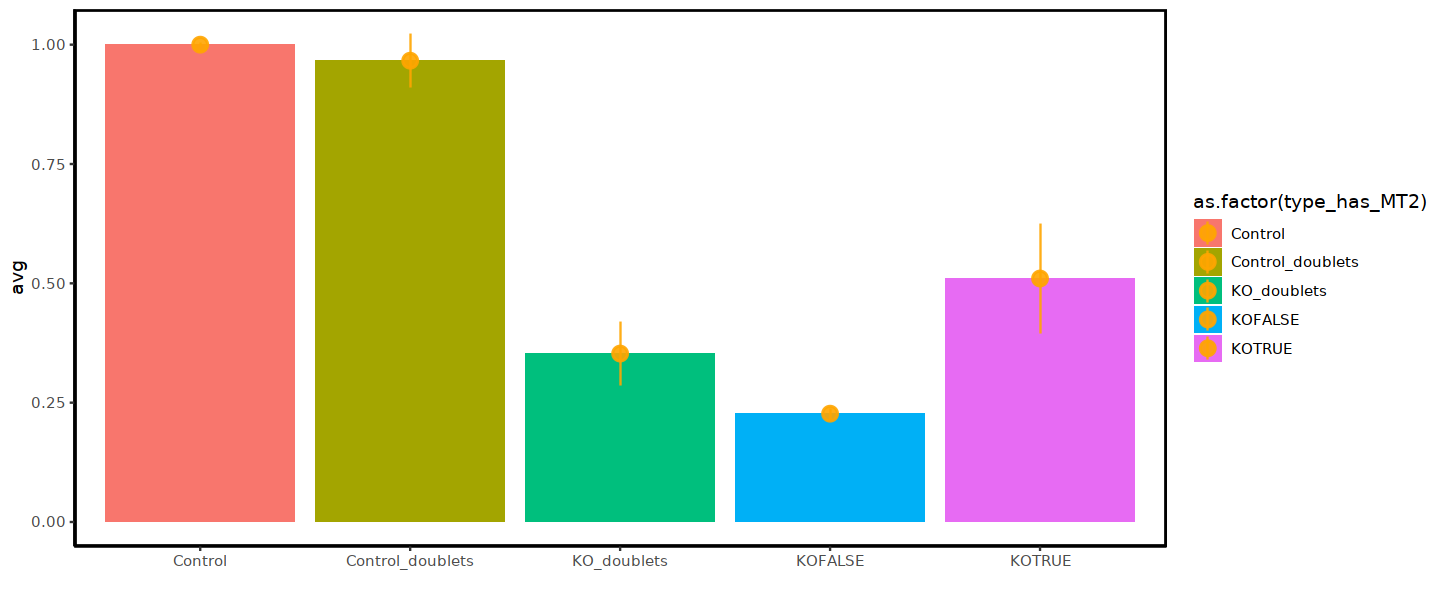

In [252]:
ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = avg, fill = as.factor(type_has_MT2))) + 
geom_col()+
#geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), width=.2,position=position_dodge(.9)) +
#geom_pointrange(aes(x=nr_mutation, y=avg, ymin=avg-sd, ymax=avg+sd), colour="orange", alpha=0.9, size=1.3)+
geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))


In [253]:
dim(all.exp2.doublets.df)
all.exp2.doublets.df_sample1 <- all.exp2.doublets.df

[1] 302229      6

## Sample 2

### Remove TSO

In [254]:
output_dir = './tmp/test'
input_dir = '../Replogle_Cell/Lane_1/new_ref/region_B/fix_threshold/'
fba_input_dir = '/lustre1/project/stg_00064/projects/cropseq/267genes/develop/public_data/Replogle_Cell//feature_barcoding_analysis/regionB/'

[1] "MT mutation table"

    A     C  D(1) D(10) D(11) D(12) D(13)  D(2)  D(3)  D(4)  D(5)  D(6)  D(7) 
  770   684  1446     4     1     1     1   772   384    77    20    12     6 
 D(8)  D(9)     G  I(1)  I(2)  I(3)  I(4)  I(5)  I(6)  I(9)     T 
    2     4   771  2403  1248    77    12     2     1     1   605 
[1] "MT mutation type"

   D    I    S 
2730 3744 2830 
[1] "MT mutation structure"

gRNA Rest  TSO 
4248  601 4455 


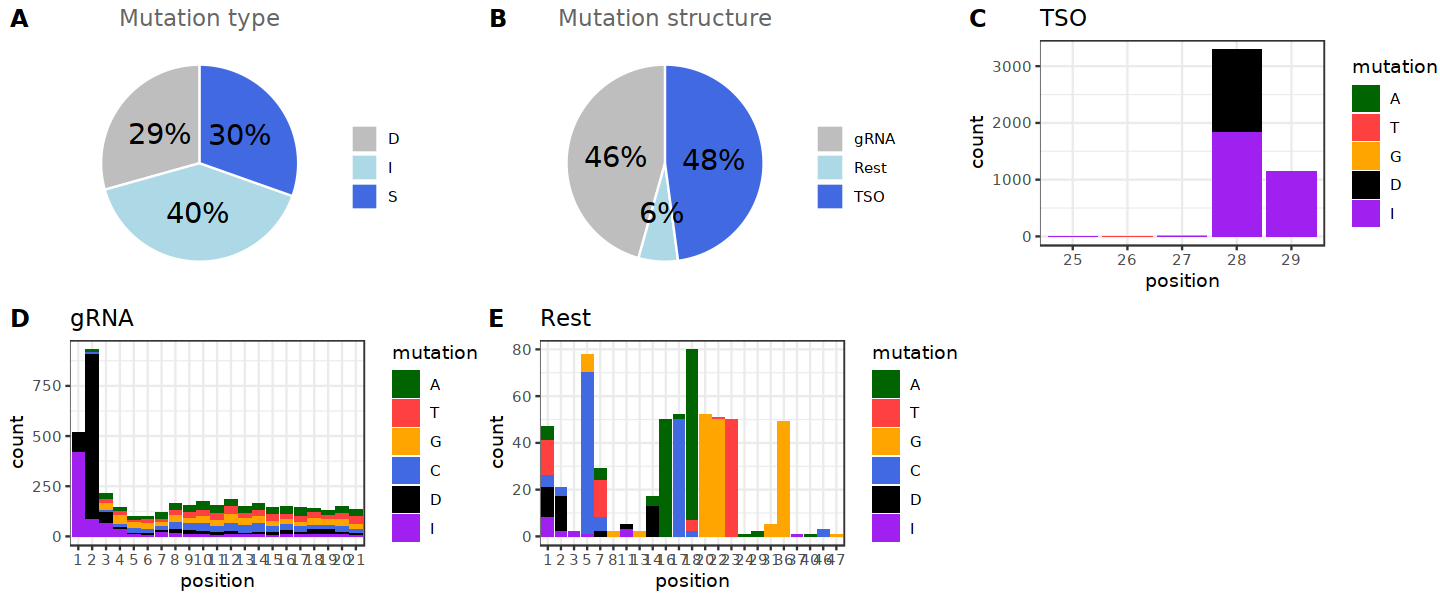

In [255]:

options(repr.plot.width = 12, repr.plot.height = 5)
MT <- plot_MT_pattern(input_dir, output_dir)
MT2 <- MT
MT2[which(MT2$structure == 'TSO'), 'position'] <- MT2[which(MT2$structure == 'TSO'), 'position']-30
MT2[which(MT2$structure == 'gRNA'), 'position'] <- MT2[which(MT2$structure == 'gRNA'), 'position'] - 1
MT2[which(MT2$structure == 'Rest'),'position'] <- MT2[which(MT2$structure == 'Rest'),'position']+20
MT2$mutation2 <- factor(MT2$mutation2, levels = c('A','T','G','C','D','I'))
MT2 <- MT2[-which(MT2$position %in% c(-1, -2,0) & MT2$mutation2 %in% c('I','D')),]
#########
MT2$dedup <- paste0(MT2$`gene name`, MT2$structure, MT2$`structure length`, MT2$position, MT2$mutation)
tmp <- MT2 %>% group_by(`variant number`) %>% summarise(mutations = list(dedup))
MT2_nodedup <- MT2
MT2 <- MT2[which(!MT2$`variant number` %in% tmp$`variant number`[duplicated(tmp$mutations)]),]
rm(tmp)
#########

MT2$position <- factor(MT2$position, levels = seq(-20,55, by =1))

In [256]:
#dim(MT2) # presumed real mutant sgRNAs after removal of TSO artifacts without dedup
MT2_list_nodedup <- unique(MT2_nodedup$`variant number`)
length(MT2_list_nodedup)

[1] 1966

In [257]:
cells_gRNA_file <- paste0(input_dir, '/cells.gRNA.txt')
n_col = max(count.fields(cells_gRNA_file, sep = "\t"))
cells.gRNA <- read.table(cells_gRNA_file, 
                     header = FALSE, fill = TRUE, stringsAsFactors = FALSE,col.names =1:n_col)

colnames(cells.gRNA)[1:7]= c('cb','feature_order','target','WT','num_UMI_WT', 'MT','num_UMI_MT')
cells.gRNA$cb <- paste0(cells.gRNA$cb,'-1')
cells.gRNA.ori <- cells.gRNA

In [258]:
cells.gRNA <- cells.gRNA.ori
cells.gRNA.WTcounts <- cells.gRNA[,1:5]
for(i in seq(6,n_col-2,2)){
    MT.df <- cells.gRNA[,i:(i+1)]
    colnames(MT.df) <- c('MT','num_UMI_MT')
    MT.notInlist <- MT.df[!MT.df$MT %in% MT2_list_nodedup,]
    index <- !MT.df$MT %in% MT2_list_nodedup
    MT.notInlist$num_UMI_MT[is.na(MT.notInlist$num_UMI_MT)] <- 0
    cells.gRNA.WTcounts$num_UMI_WT[index] <- cells.gRNA.WTcounts$num_UMI_WT[index] + MT.notInlist$num_UMI_MT
    cells.gRNA[index,i:(i+1)] <- NA # make MT not in list as NA
}
cells.gRNA[,1:5] <- cells.gRNA.WTcounts
for(i in seq(1, nrow(cells.gRNA))){
    num_MT <- (sum(!is.na(cells.gRNA[i,])) - 5)/2 #updated number of gRNA
    if(cells.gRNA[i,5] > 0){
        cells.gRNA$feature_order[i] <- num_MT + 1
    }else{
        cells.gRNA$feature_order[i] <- num_MT
    }
}
# now feature order is no longer accumulated 
cells.num_features <- cells.gRNA %>% group_by(cb) %>% summarise(num_features = sum(feature_order))
#cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(is_MT))
cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0)) %>% summarise(has_MT=any(contain_MT, is_MT))

# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


In [259]:
table(cells.num_features$num_features)
sum(table(cells.num_features$num_features))


   1    2    3    4    5    6    7    8 
6048 2407  668  242   64   31   12    3 

[1] 9475

In [260]:
sum(cells.num_features$num_features) # cells (actual cells, count multiplets multiple times)
tmp <- cells.gRNA %>% group_by(cb) %>% summarise(contain_MT = (feature_order > 1), is_MT = (num_UMI_WT == 0))
# contain_MT, is_MT
# False, False -> wildtype
# True, False -> contain mutant gRNA also WT
# False, True -> single MT gRNA
# True, True -> multiple MT gRNA
sum(cells.gRNA[which(cells.gRNA$num_UMI_WT > 0),'feature_order']-1) + sum(cells.gRNA[which(cells.gRNA$num_UMI_WT == 0),'feature_order'])
# cells with mutations (multiplets count as multiple)

[1] 14448

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


[1] 3718

Rows: 12659 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


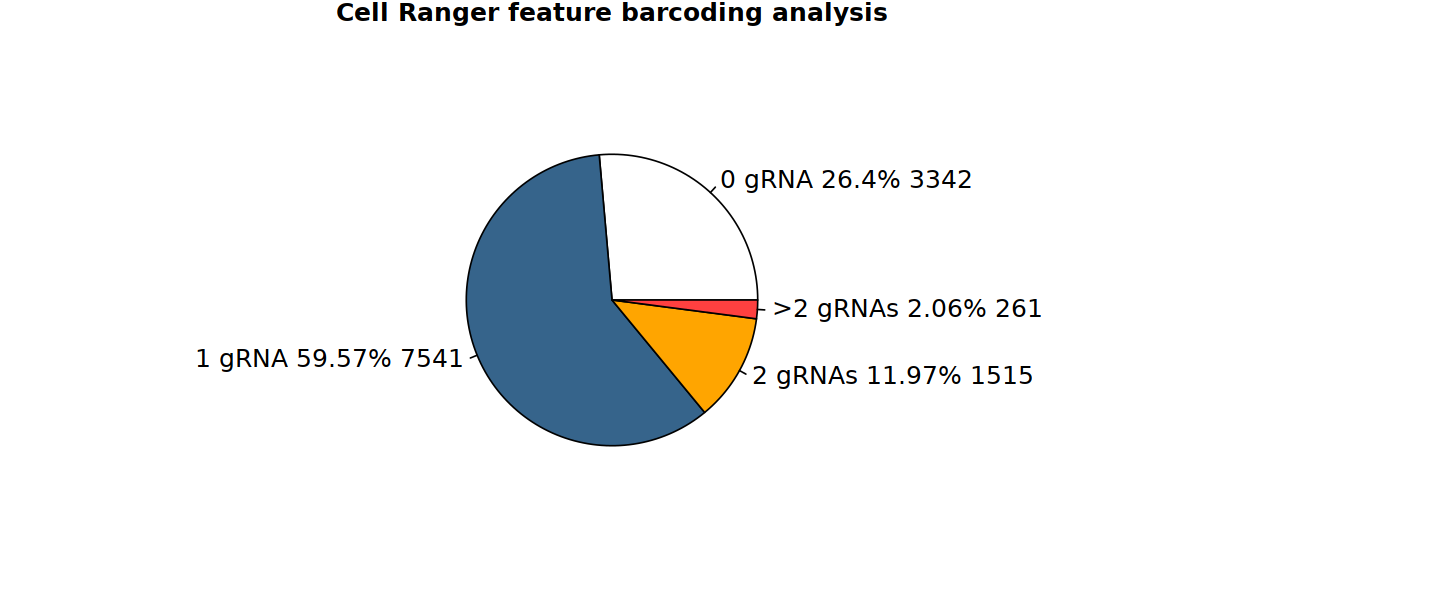

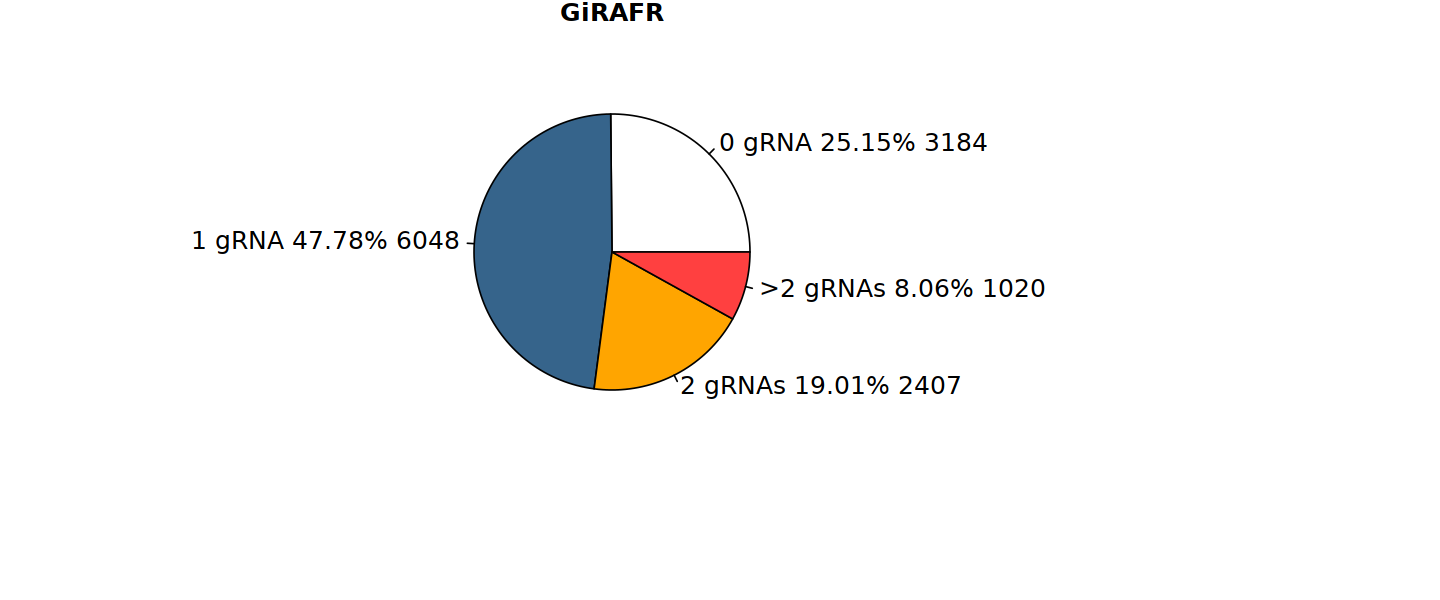

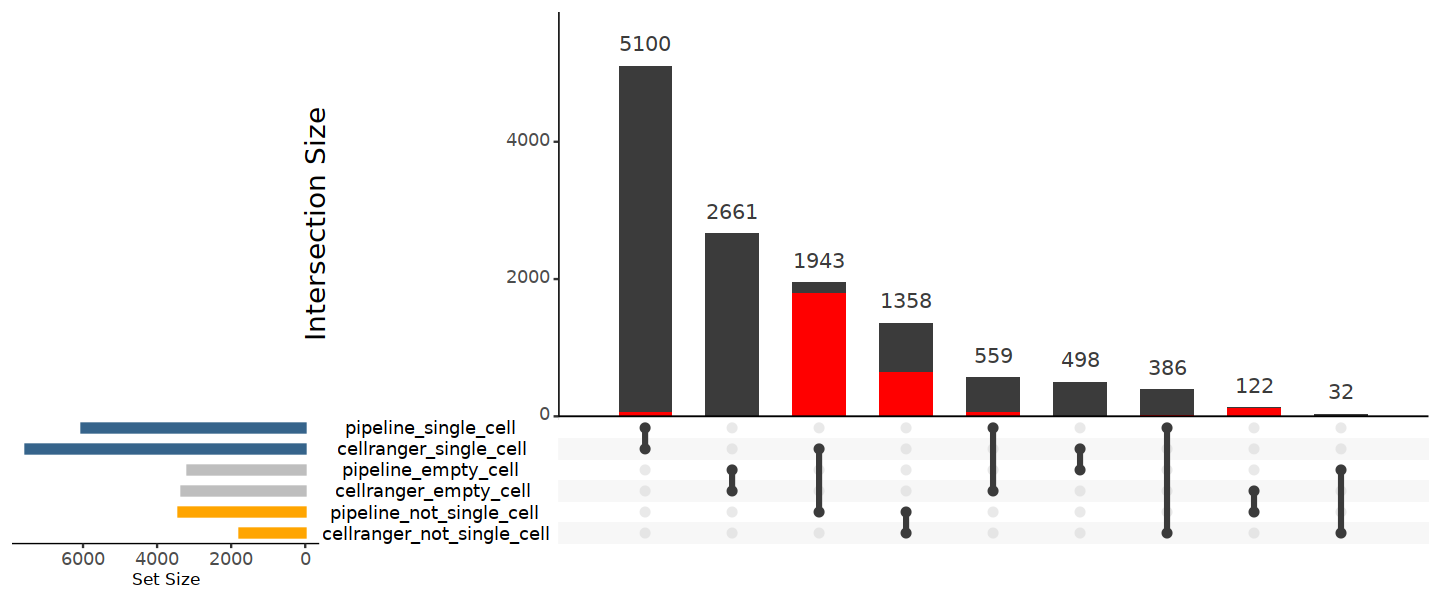

In [261]:
protospacer_file <- paste0(fba_input_dir, '/outs/crispr_analysis/protospacer_calls_per_cell.csv')
barcodes_file <- paste0(fba_input_dir, '/outs/filtered_feature_bc_matrix/barcodes.tsv.gz')
protospacer_calls_per_cell <-read.csv(protospacer_file, stringsAsFactors = FALSE)
cellranger_barcode <- read_csv(barcodes_file, col_names = FALSE)


pipeline_NotEmpty <- cells.num_features$cb
pipeline_Single <- cells.num_features$cb[which(cells.num_features$num_features == 1)]
par(mar = c(1,1,1,10))
slices1 <- c(nrow(cellranger_barcode) - sum(table(protospacer_calls_per_cell$num_features)),
        as.vector(table(protospacer_calls_per_cell$num_features)[1]),
        as.vector(table(protospacer_calls_per_cell$num_features)[2]),
        sum(table(protospacer_calls_per_cell$num_features)[-(1:2)]))
lbls1 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct1 <- round(slices1/sum(slices1)*100, digit =2 )
lbls1 <- paste(lbls1, pct1) # add percents to labels
lbls1 <- paste(lbls1,"%",sep="") # ad % to labels
lbls1 <- paste(lbls1, slices1, sep =' ')
pie(slices1, labels = lbls1, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"), 
    main = 'Cell Ranger feature barcoding analysis')

par(mar = c(5,1,1,10))
slices2 <- c(nrow(cellranger_barcode) - sum(table(cells.num_features$num_features)),
        as.vector(table(cells.num_features$num_features)[1]),
        as.vector(table(cells.num_features$num_features)[2]),
        sum(table(cells.num_features$num_features)[-(1:2)]))
lbls2 <- c('0 gRNA','1 gRNA', '2 gRNAs', '>2 gRNAs')
pct2 <- round(slices2/sum(slices2)*100, digit = 2)
lbls2 <- paste(lbls2, pct2) # add percents to labels
lbls2 <- paste(lbls2,"%",sep="") # ad % to labels
lbls2 <- paste(lbls2, slices2, sep =' ')
pie(slices2, labels = lbls2, cex = 1.2,radius = 0.8, col = c("white","steelblue4","orange","brown1"),
   main = 'GiRAFR')

all_barcodes <- as.data.frame(cellranger_barcode)
all_barcodes$pipeline_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 1, 0)
all_barcodes$pipeline_empty_cell <- ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 0, 1)
all_barcodes$pipeline_not_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 0, 
                                            ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 1, 0))

all_barcodes$cellranger_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 1, 0)
all_barcodes$cellranger_empty_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 0, 1)
all_barcodes$cellranger_not_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 0, 
                                            ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 1, 0))
all_barcodes <- merge(all_barcodes, cells.has_MT, by.x = 'X1', by.y = 'cb', all.x = TRUE)



Myfunc <- function(row) {data <- (row["has_MT"] == TRUE)}
p <- upset(data = all_barcodes, 
      queries = list(list(query = Myfunc, color = "red", active = T)),
      sets = c('cellranger_not_single_cell','pipeline_not_single_cell',
           'cellranger_empty_cell','pipeline_empty_cell',
           'cellranger_single_cell','pipeline_single_cell'), order.by = "freq",keep.order = TRUE,sets.bar.color=c("orange","orange","grey","grey","steelblue4","steelblue4"), 
      point.size =2.5,line.size = 1.3,text.scale = c(2, 1.5, 1.2, 1.5, 1.5, 2))

p


In [262]:
table(all_barcodes[which(all_barcodes$cellranger_empty_cell == 1),'has_MT'])


FALSE  TRUE 
  518   163 

In [263]:
table(all_barcodes$has_MT)


FALSE  TRUE 
 6806  2662 

### Analysis impact of mutant gRNA and doublets

In [264]:
input_dir

[1] "../Replogle_Cell/Lane_1/new_ref/region_B/fix_threshold/"

In [265]:
cells.gRNA.single.MT <- read.table(paste0(input_dir, 'cells.gRNA.single.MT.txt'), stringsAsFactors = FALSE)
cells.gRNA.single.MT$target <- sapply(strsplit(cells.gRNA.single.MT$V3,"_"), `[`, 2)
cells.gRNA.single.MT[grepl('non-targeting',cells.gRNA.single.MT$target),]$target <- 'Control'
cells.gRNA.single.MT$is_WT <- !grepl(pattern = 'variant',cells.gRNA.single.MT$V3)
#table(cells.gRNA.single.MT$is_WT)
cells.gRNA.single.MT$cb = paste0(cells.gRNA.single.MT$V1, '-1')

In [266]:
diff_cb <- pipeline_Single[!pipeline_Single %in% cells.gRNA.single.MT$cb]

In [267]:
length(diff_cb)

[1] 4579

pipeline_Single

In [268]:
all.matrix <- Read10X(paste0(fba_input_dir,'/outs/filtered_feature_bc_matrix/'))
expression.seurat.ori = CreateSeuratObject(counts = all.matrix$`Gene Expression`)
expression.seurat <- subset(expression.seurat.ori, cells = pipeline_Single)

expression.seurat <- NormalizeData(object = expression.seurat, normalization.method = "LogNormalize", scale.factor = 10000)
rownames(cells.gRNA.single.MT) <- cells.gRNA.single.MT$cb
expression.seurat@meta.data$KO <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'target']
expression.seurat@meta.data$is_WT <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'is_WT']
expression.seurat@meta.data$mutation <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'V5']
expression.seurat@meta.data$cb <- rownames(expression.seurat@meta.data)

10X data contains more than one type and is being returned as a list containing matrices of each type.



New single cells after removal of TSO shown as NA

In [269]:
sum(is.na(expression.seurat@meta.data$KO)) 
# should be same as length(diff_cb) 

[1] 4577

In [270]:
rownames(cells.has_MT) <- cells.has_MT$cb
expression.seurat@meta.data$has_MT <- cells.has_MT[rownames(expression.seurat@meta.data), ]$has_MT

Warning message:
“Setting row names on a tibble is deprecated.”


In [271]:
diff_cb_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% diff_cb),]
rownames(diff_cb_gRNA) <- diff_cb_gRNA$cb

In [272]:
# replace KO NA into target
expression.seurat@meta.data$KO[which(expression.seurat@meta.data$cb %in% diff_cb)] <- 
sapply(strsplit(diff_cb_gRNA[rownames(expression.seurat@meta.data[which(expression.seurat@meta.data$cb %in% diff_cb),]), 'target'], '_'), `[`, 2)

In [273]:
table(expression.seurat@meta.data$is_WT, expression.seurat@meta.data$has_MT)
# has some discrepancy 

       
        FALSE TRUE
  FALSE   866  122
  TRUE    480    0

In [274]:
#expression.seurat@meta.data[which(expression.seurat@meta.data$is_WT == FALSE & expression.seurat@meta.data$has_MT == FALSE),]

In [275]:
expression.seurat$KO[which(expression.seurat$KO == 'non-targeting')] <- 'Control'
expression.seurat$KO[which(expression.seurat$KO == 'GET1')] <- 'WRB'
expression.seurat$KO[which(expression.seurat$KO == 'GET3')] <- 'ASNA1'
expression.seurat$KO[which(expression.seurat$KO == 'MICOS10')] <- 'MINOS1'
expression.seurat$KO[which(expression.seurat$KO == 'PRORP')] <- 'KIAA0391'

In [276]:
#unique(expression.seurat$KO)

In [277]:
targets <- unique(expression.seurat@meta.data$KO)
targets <- targets[targets!='Control']
all.exp2.df <- data.frame()
CTRL_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == 'Control'),])
for(gene in targets){
        KO_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == gene),])
        tmp.df <- rbind(data.frame(expression = expression.seurat@assays$RNA@data[gene, KO_cells], type = 'KO'),
            data.frame(expression = expression.seurat@assays$RNA@data[gene, CTRL_cells], type = 'Control'))

        tmp.df$target = gene
        tmp.df$cb = rownames(tmp.df)
        all.exp2.df <- rbind(all.exp2.df, tmp.df)
}

Target gene expression in Control

In [278]:
avg.exp.control <- all.exp2.df[which(all.exp2.df$type == 'Control'),] %>% group_by(target) %>% summarise(avg = mean(expression))
avg.exp.control <- as.data.frame(avg.exp.control)
rownames(avg.exp.control) <- avg.exp.control$target

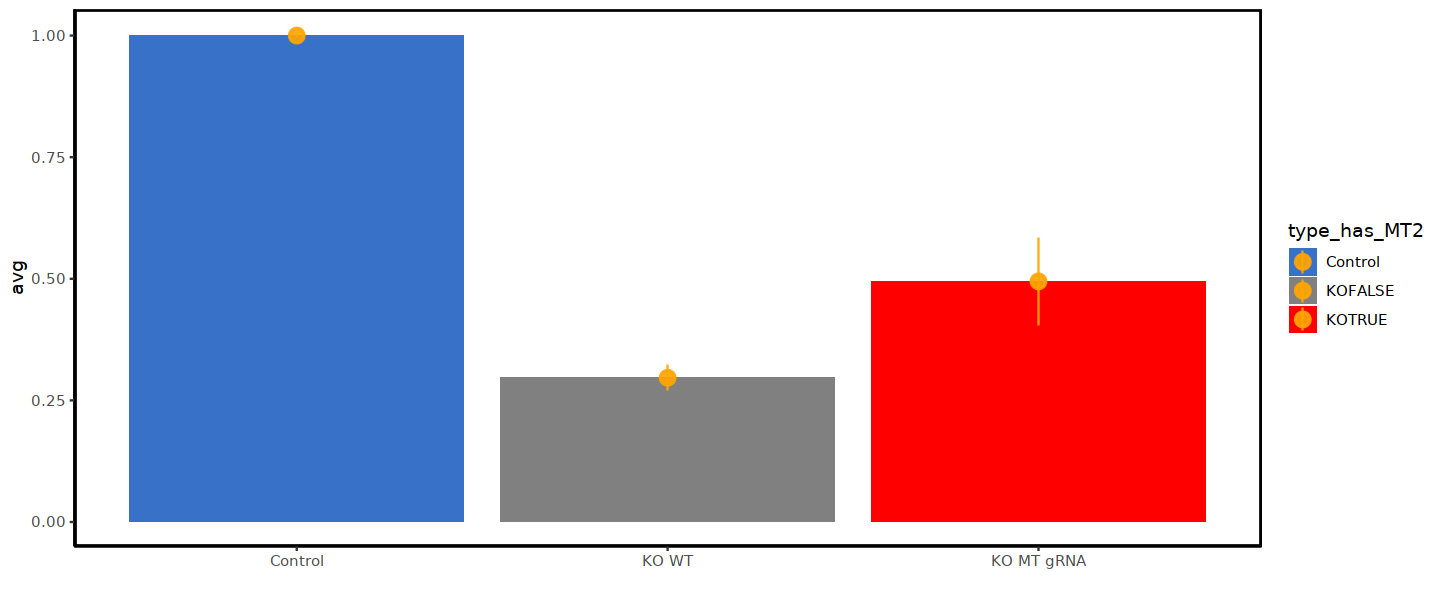

In [279]:
#all.exp2.MT.df <- merge(all.exp2.df, cells.gRNA.single.MT[,c(4,5,8,9)], by = 'cb')
all.exp2.MT.df <- merge(all.exp2.df, expression.seurat@meta.data[,c(4,6,7,8)], by = 'cb')
all.exp2.MT.df$type_has_MT <- paste0(all.exp2.MT.df$type, all.exp2.MT.df$has_MT)

all.exp2.MT.df$type_has_MT2 <- all.exp2.MT.df$type_has_MT
all.exp2.MT.df[which(all.exp2.MT.df$type_has_MT == 'ControlFALSE' |
    all.exp2.MT.df$type_has_MT == 'ControlNA' |
    all.exp2.MT.df$type_has_MT == 'ControlTRUE'),'type_has_MT2'] <- 'Control'

out_target <- avg.exp.control[which(avg.exp.control$avg == 0), 'target']
all.exp2.MT.df <- all.exp2.MT.df[which(!all.exp2.MT.df$target %in% out_target), ]

all.exp2.MT.df$expression_norm <- all.exp2.MT.df$expression/avg.exp.control[all.exp2.MT.df$target,'avg']

# high_exp_targets <- avg.exp.control$target[order(avg.exp.control$avg, decreasing = T)]
# tmp.df <- all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets), c('tmp','expression_norm')]

tmp.df <- all.exp2.MT.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm),
                                                 sem = sd(expression_norm)/sqrt(n))

p1 <- ggplot(tmp.df, aes(x = type_has_MT2, y = avg, fill = type_has_MT2)) + geom_col()+
        geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
        theme_classic()+
        xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
        scale_fill_manual(breaks = c("Control", "KOFALSE","KOTRUE"),
                          values=c("#3771c8", "#808080",'#ff0000'))+
        scale_x_discrete(limits = c("Control", "KOFALSE", "KOTRUE"), labels=c("Control" = "Control", "KOFALSE" = "KO WT", "KOTRUE" = "KO MT gRNA"))

print(p1)

### Analysis impact of doublets/multiplets

In [280]:
new_doublets <- all_barcodes[which(all_barcodes$pipeline_not_single_cell == 1 & all_barcodes$cellranger_single_cell == 1), 'X1']
length(new_doublets) 
# pipeline identified doubets, cellranger as single

[1] 1943

For new doublets, following scenarios:
1. doublets with the mutant gRNA and wildtype gRNA targeting the same gene, 
2. doublets with the mutant gRNA and wildtype gRNA targeting the different gene
3. doublets with two wildtype gRNA targeting the same gene
4. doublets with two wildtype gRNA targeting different gene
5. doublets with two mutant gRNAs targeting different gene

In [281]:
new_doublets_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% new_doublets),] # the mutant gRNA and wildtype gRNA targeting the same gene,

In [282]:
new_doublets_type1 <- new_doublets_gRNA[which(new_doublets_gRNA$feature_order >= 2),]

In [283]:
new_doublets_gRNA2 <- as.data.frame(new_doublets_gRNA[which(new_doublets_gRNA$feature_order < 2),] %>% group_by(cb) %>% summarise(target = list(target), UMIs = list(num_UMI_WT)))


In [284]:
new_doublets_gRNA2$KO <- lapply(new_doublets_gRNA2$target, function(x) sapply(strsplit(x, '_'), `[`, 2))

In [285]:
new_doublets_gRNA2$KO <- lapply(new_doublets_gRNA2$KO, function(x) ifelse(grepl('NegCtrl',x),'Control',x))

In [286]:
if1 <- lapply(new_doublets_gRNA2$KO, function(x) x[1]== x[2])
if2 <- lapply(new_doublets_gRNA2$UMIs, function(x) x[1]>0 & x[2] > 0)
              
new_doublets_type_unknown <- c()
new_doublets_type2 <- c()
new_doublets_type3 <- c()
new_doublets_type4 <- c()
new_doublets_type5 <- c()
for(i in 1:nrow(new_doublets_gRNA2)){
    if(is.na(if1[i]) | is.na(if2[i])){
        new_doublets_type_unknown <- rbind(new_doublets_type_unknown, new_doublets_gRNA2[i,])
    }else{
    if(if1[i] == TRUE & if2[i] == TRUE){ # two wiltype gRNA targeting the same target
        new_doublets_type3 <- rbind(new_doublets_type3, new_doublets_gRNA2[i,])
    }else if(if1[i] == TRUE & if2[i] == FALSE){ #  mutant gRNA and wildtype gRNA or two muatnt targeting the same gene
        new_doublets_type2 <- rbind(new_doublets_type2, new_doublets_gRNA2[i,])
    }else if(if1[i] == FALSE & if2[i] == TRUE){# two wildtype gRNA targeting different gene
        new_doublets_type4 <- rbind(new_doublets_type4, new_doublets_gRNA2[i,]) 
    }else if(if1[i] == FALSE & if2[i] == FALSE){ # mutant gRNA and wildtype gRNA or two muatnt  different gene 
        new_doublets_type5 <- rbind(new_doublets_type5, new_doublets_gRNA2[i,])
    }else{
        print('unknown error')
    }
    }
}

In [287]:
nrow(new_doublets_type1)
nrow(new_doublets_type2)
nrow(new_doublets_type3)
nrow(new_doublets_type4)
nrow(new_doublets_type5)
nrow(new_doublets_type_unknown)

[1] 1688

NULL

NULL

[1] 156

[1] 127

[1] 77

In [288]:
new_doublets_subset <- rbind(new_doublets_type4, new_doublets_type5)$cb
length(new_doublets_subset)

[1] 283

In [289]:
seurat.object.doublets <- subset(expression.seurat.ori, cells = new_doublets_subset)
seurat.object.doublets <- NormalizeData(object = seurat.object.doublets, normalization.method = "LogNormalize", scale.factor = 10000)
seurat.object.doublets

An object of class Seurat 
33538 features across 283 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data

In [290]:
head(rbind(new_doublets_type4, new_doublets_type5))
table(cells.num_features[which(cells.num_features$cb %in% new_doublets_subset),'num_features'])

,cb,target,UMIs,KO
,<chr>,<list>,<list>,<list>
3,AAAGTCCTCTTTCGAT-1,"5908_NUTF2_P1P2_ENSG00000102898_B_gene, 8458_SSRP1_P1P2_ENSG00000149136_B_gene","22, 3","NUTF2, SSRP1"
4,AACAAAGGTATCTTCT-1,"2502_EFTUD2_P1P2_ENSG00000108883_B_gene, 4001_HYPK_P1P2_ENSG00000242028_B_gene","5, 4","EFTUD2, HYPK"
5,AACAACCTCATCGGGC-1,"5430_NAA38_P1P2_ENSG00000183011_B_gene, 8426_SRRT_P1P2_ENSG00000087087_B_gene","15, 4","NAA38, SRRT"
6,AACAACCTCTCTATGT-1,"2487_EEF1G_P1P2_ENSG00000254772_B_gene, 7434_RPL12_P1P2_ENSG00000197958_B_gene","50, 4","EEF1G, RPL12"
10,AAGAACACACTGGAAG-1,"8921_TIMM23B_P1P2_ENSG00000204152_B_gene , 8922_TIMM23_ENST00000260867.4_ENSG00000265354_B_gene","17, 40","TIMM23B, TIMM23"
11,AAGCCATTCGGTATGT-1,"3517_GPS1_P1P2_ENSG00000169727_B_gene , 6681_PPP2R1A_P1_ENSG00000105568_B_gene","22, 3","GPS1 , PPP2R1A"


num_features
  2   3   4   5   6   7 
235  20  16   5   5   2 

In [291]:
protospacer.df <- read.csv(protospacer_file)
rownames(protospacer.df) <- protospacer.df$cell_barcode

In [292]:
seurat.object.doublets@meta.data <- cbind(seurat.object.doublets@meta.data, protospacer.df[colnames(seurat.object.doublets),])
seurat.object.doublets$KO <- sapply(strsplit(seurat.object.doublets@meta.data$feature_call, '_'), `[`, 2)

In [293]:
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'non-targeting')] <- 'Control'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'GET1')] <- 'WRB'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'GET3')] <- 'ASNA1'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'MICOS10')] <- 'MINOS1'
seurat.object.doublets$KO[which(seurat.object.doublets$KO == 'PRORP')] <- 'KIAA0391'

In [294]:
doublets_targets <- unique(seurat.object.doublets$KO)[-which(unique(seurat.object.doublets$KO) == 'Control')] # remove 'neg'
doublets.exp.df <- data.frame()
CTRL_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == 'Control'),])

for(gene in doublets_targets){
    KO_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == gene),])
   tmp.df <- rbind(data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, KO_cells], type = 'KO_doublets'),
                    data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, CTRL_cells], type = 'Control_doublets'))
   tmp.df$target = gene
   tmp.df$cb = c(KO_cells, CTRL_cells)
   doublets.exp.df <- rbind(doublets.exp.df, tmp.df)
}

In [295]:
doublets.exp.df$type_has_MT2 <- doublets.exp.df$type

In [296]:

doublets.exp.df <- doublets.exp.df[which(!doublets.exp.df$target %in% out_target), ]
doublets.exp.df <- doublets.exp.df[which(doublets.exp.df$target %in% unique(avg.exp.control$target)), ] #???

In [297]:
doublets.exp.df$expression_norm <- doublets.exp.df$expression/avg.exp.control[doublets.exp.df$target,'avg']

In [298]:
all.exp2.doublets.df <- rbind(doublets.exp.df, all.exp2.MT.df[, c('expression', 'type', 'target', 'cb', 'type_has_MT2', 'expression_norm')])

In [299]:
table(all.exp2.doublets.df$type_has_MT)


         Control Control_doublets      KO_doublets          KOFALSE 
          342954             1680              208             5154 
          KOTRUE 
             100 

In [300]:
tmp.df <- all.exp2.doublets.df
tmp.df <- tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
tmp.df

type_has_MT2,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,342954,1.0000000,2.4393693,0.004165428
Control_doublets,1680,1.0989586,3.6369890,0.088733446
KOFALSE,5154,0.2965056,1.8882452,0.026301843
KOTRUE,100,0.4946559,0.9083273,0.090832734
KO_doublets,208,0.3574509,0.7557314,0.052400547


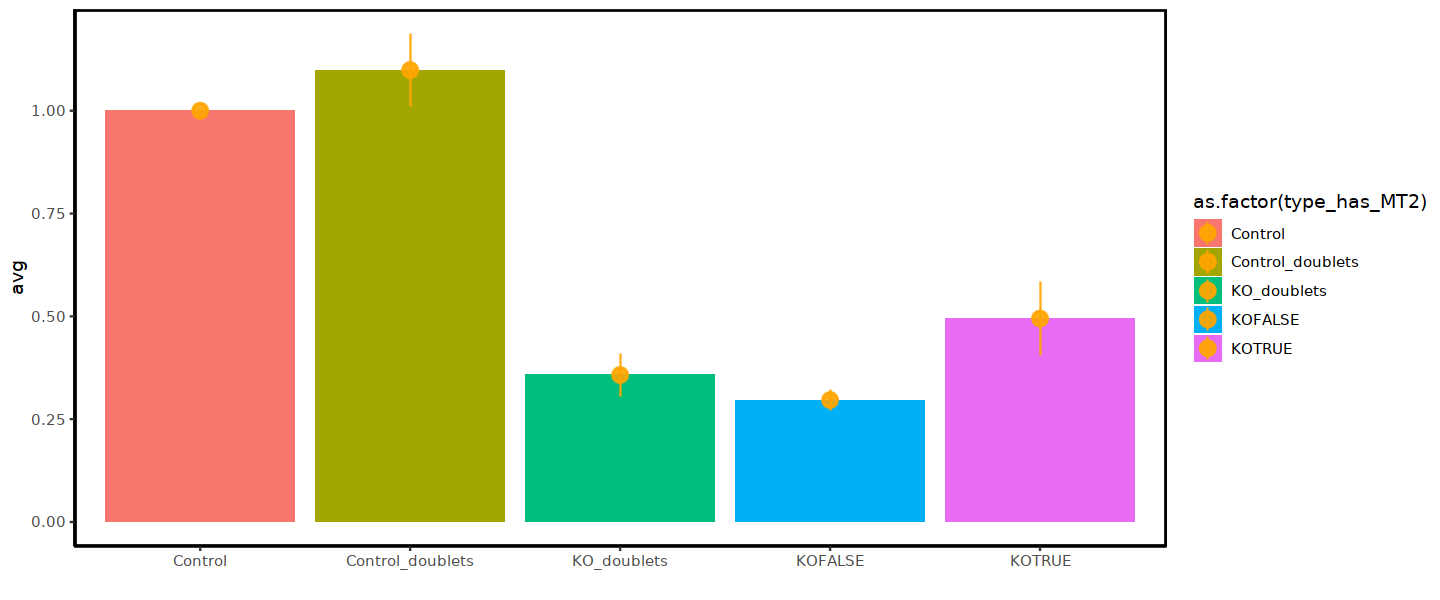

In [301]:
ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = avg, fill = as.factor(type_has_MT2))) + 
geom_col()+
#geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), width=.2,position=position_dodge(.9)) +
#geom_pointrange(aes(x=nr_mutation, y=avg, ymin=avg-sd, ymax=avg+sd), colour="orange", alpha=0.9, size=1.3)+
geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))


In [302]:
dim(all.exp2.doublets.df)
all.exp2.doublets.df_sample2 <- all.exp2.doublets.df

[1] 350096      6

## Combine two samples

In [303]:
dim(all.exp2.doublets.df_sample1)
dim(all.exp2.doublets.df_sample2)

[1] 302229      6

[1] 350096      6

In [304]:
all.exp2.doublets.df_combine <- rbind(all.exp2.doublets.df_sample1, all.exp2.doublets.df_sample2)

type_has_MT2,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,638928,1.0000000,2.4571427,0.003074004
Control_doublets,3073,1.0388833,3.0454862,0.054938318
KOFALSE,9708,0.2638604,1.4774358,0.014994905
KOTRUE,179,0.5014787,0.9541188,0.071314187
KO_doublets,437,0.3550449,0.8950233,0.042814772


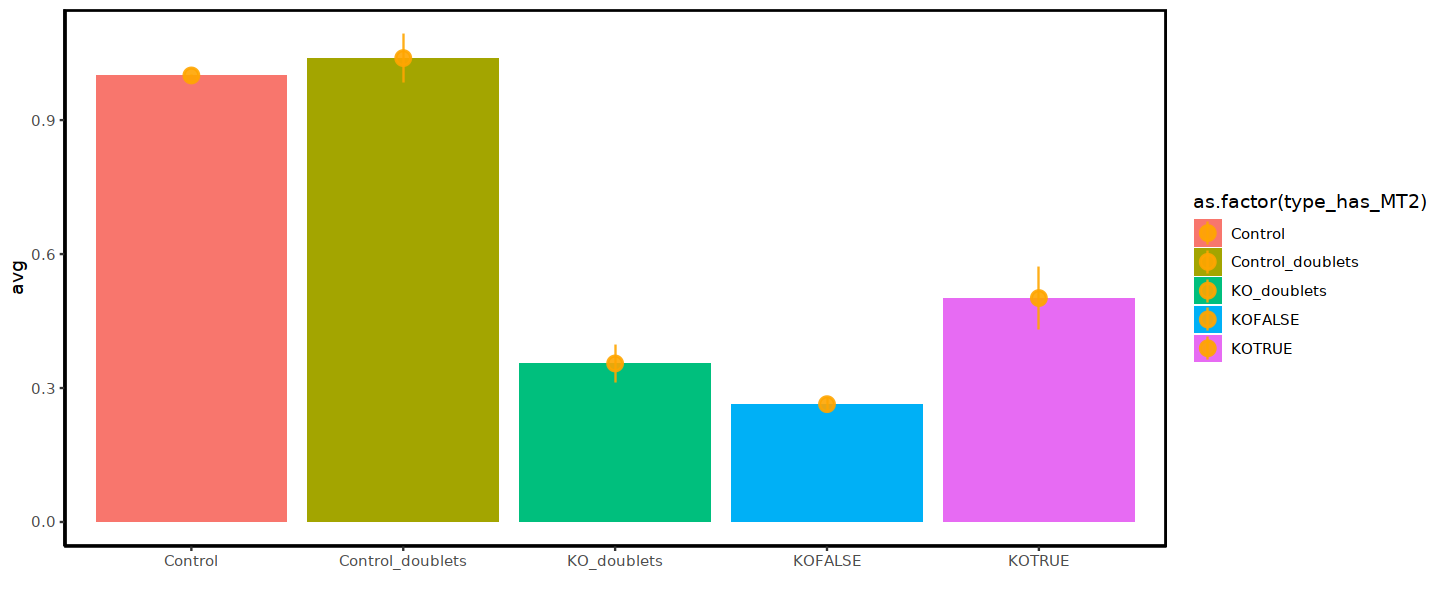

In [305]:
#pdf('Replogle_Cell_gRNA_target_exp.pdf')
tmp.df <- all.exp2.doublets.df_combine
tmp.df <- tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
tmp.df

ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = avg, fill = as.factor(type_has_MT2))) + 
geom_col()+
#geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), width=.2,position=position_dodge(.9)) +
#geom_pointrange(aes(x=nr_mutation, y=avg, ymin=avg-sd, ymax=avg+sd), colour="orange", alpha=0.9, size=1.3)+
geom_pointrange(aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))
#dev.off()

In [307]:
table(tmp.df$type_has_MT2)


         Control Control_doublets      KO_doublets          KOFALSE 
          638928             3073              437             9708 
          KOTRUE 
             179 

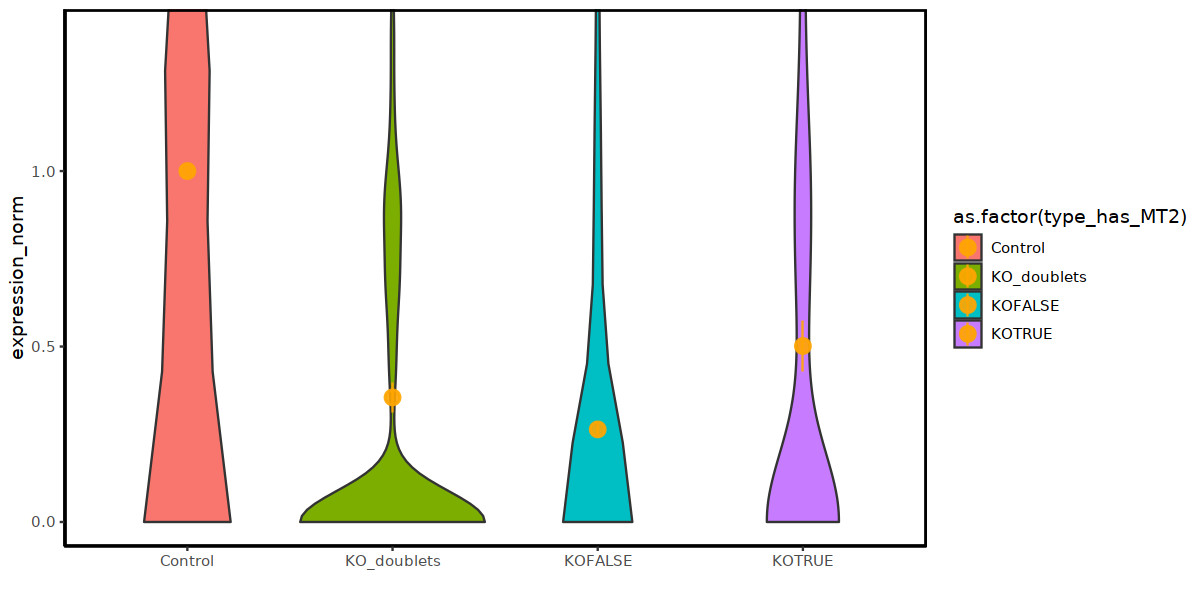

In [318]:
#pdf('Replogle_Cell_gRNA_target_exp_violin.pdf')
tmp.df <- tmp.df[which(tmp.df$type_has_MT2 != 'Control_doublets'),]
tmp <-  tmp.df %>% group_by(type_has_MT2) %>% summarise(n = n(), avg = mean(expression_norm), 
                                                 sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
ylims <- tmp.df %>%
  group_by(type_has_MT2) %>%
  summarise(Q1 = quantile(expression_norm, 1/4), Q3 = quantile(expression_norm, 3/4)) %>%
  ungroup() %>%
  #get lowest Q1 and highest Q3
  summarise(lowQ1 = min(Q1), highQ3 = max(Q3))

ggplot(tmp.df, 
       aes(
           x = type_has_MT2, 
           y = expression_norm, fill = as.factor(type_has_MT2))) + 
geom_violin()+
coord_cartesian(ylim = as.numeric(ylims)*1)+ # zoom in
geom_pointrange(data = tmp, aes(x=type_has_MT2, y=avg, ymin=avg-sem, ymax=avg+sem),
                colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))
#dev.off()